In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# OPV NN1

### This notebook to uses only OPV processing conditions to predict device performance.


# Dataset definition

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

print (f'device_df shape: {device_df.shape}')
print (f'test_df shape: {test_df.shape}')
device_df.head()

device_df shape: (366, 9)
test_df shape: (10, 60)


,Unnamed: 0,PCE,VocL,Jsc,FF,Substrate,Device,Time (min),Temp (C)
0,0,0.000000,0.000000,0.078981,0.066177,1,5,0,0
1,1,0.088229,1.000000,0.026882,0.000000,7,5,0,0
2,2,0.185014,0.934181,0.000000,0.565143,7,6,0,0
3,3,0.187694,0.915305,0.008375,0.570857,7,2,0,0
4,4,0.190771,0.928501,0.058959,0.436489,1,1,0,0


In [4]:
x_train = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
y_train = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_test = test_df[['Anneal_time', 'Anneal_temp']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

# Fit model with variety of learning rates and epochs to find best hyperparameters

In [5]:
%autoreload

def fit(model, lr, epochs):
    
    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    
    #empty list to hold loss per epoch
    train_epoch_losses = []
    pce_train_epoch_losses = []
    voc_train_epoch_losses = []
    jsc_train_epoch_losses = []
    ff_train_epoch_losses = []

    test_epoch_losses = []
    pce_test_epoch_losses = []
    voc_test_epoch_losses = []
    jsc_test_epoch_losses = []
    ff_test_epoch_losses = []

    pce_test_epoch_accuracies = []
    voc_test_epoch_accuracies = []
    jsc_test_epoch_accuracies = []
    ff_test_epoch_accuracies = []
    test_epoch_accuracies = []

    pce_test_epoch_r2 = []
    voc_test_epoch_r2 = []
    jsc_test_epoch_r2 = []
    ff_test_epoch_r2 = []
    test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(epochs):
        print('On epoch ', epoch)

    #     save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    #     model_name = "OPV_NN2"
    #     model_path = save_dir+model_name+'*.pt'
    #     if epoch < 10:
    #         save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    #     else:
    #         save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'

    #     if glob.glob(model_path) != []:
    #         model_states = glob.glob(model_path)
    #         model_states = sorted(model_states)
    #         previous_model = model_states[-1]    

    #         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)

        model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,                                                                                                     training_data_set = training_data_set,
                                                                                                             optimizer = optimizer)
        train_epoch_losses.append(train_loss)
        pce_train_epoch_losses.append(pce_train_loss)
        voc_train_epoch_losses.append(voc_train_loss)
        jsc_train_epoch_losses.append(jsc_train_loss)
        ff_train_epoch_losses.append(ff_train_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_df_model(model = model,
                                                                  testing_data_set = testing_data_set)
        pce_test_epoch_losses.append(test_losses[0])
        voc_test_epoch_losses.append(test_losses[1])
        jsc_test_epoch_losses.append(test_losses[2])
        ff_test_epoch_losses.append(test_losses[3])

        tot_tst_loss = sum(test_losses)
        test_epoch_losses.append(tot_tst_loss)

        pce_test_epoch_accuracies.append(test_accs[0])
        voc_test_epoch_accuracies.append(test_accs[1])
        jsc_test_epoch_accuracies.append(test_accs[2])
        ff_test_epoch_accuracies.append(test_accs[3])

        tot_tst_acc = sum(test_accs)
        test_epoch_accuracies.append(tot_tst_acc)

        pce_test_epoch_r2.append(test_r2s[0])
        voc_test_epoch_r2.append(test_r2s[1])
        jsc_test_epoch_r2.append(test_r2s[2])
        ff_test_epoch_r2.append(test_r2s[3])

        tot_tst_r2 = sum(test_r2s)
        test_epoch_r2s.append(tot_tst_r2)

        #nuts.save_trained_model(save_path, epoch, model, optimizer)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))
    best_r2_indx = test_epoch_r2s.index(max(test_epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': pce_test_epoch_losses,
        'voc_loss': voc_test_epoch_losses,
        'jsc_loss': jsc_test_epoch_losses,
        'ff_loss': ff_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'pce_acc': pce_test_epoch_accuracies,
        'voc_acc': voc_test_epoch_accuracies,
        'jsc_acc': jsc_test_epoch_accuracies,
        'ff_acc': ff_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        'pce_r2': pce_test_epoch_r2,
        'voc_r2': voc_test_epoch_r2,
        'jsc_r2': jsc_test_epoch_r2,
        'ff_r2': ff_test_epoch_r2,
        'test_r2s': test_epoch_r2s,
        'train_pce_loss': pce_train_epoch_losses,
        'train_voc_loss': voc_train_epoch_losses,
        'train_jsc_loss': jsc_train_epoch_losses,
        'train_ff_loss': ff_train_epoch_losses
    }

    return fit_results

In [22]:
%autoreload

# Hyper parameters
num_epochs = 500
learning_rate = 1e-5

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

in_dims = int(x_train.shape[1]) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

In [23]:
%autoreload

cv_fits = {}

kf = KFold(n_splits = 5)

for fold, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
    print(f'Fold # {fold}')
    print('-----------------------------')
    
    train_loader, test_loader = nuts.get_fold_dataloaders_df(x_train, y_train, train_index, test_index)
        
    model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
    model.apply(nuts.init_weights)
    
    cv_fits[fold] = nuts.CV_OPV_fit(model, train_loader, test_loader, lr = learning_rate, epochs = num_epochs)


Fold # 0
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 1442.0770263671875
                              Voc = 1365.193115234375
                              Jsc = 1888.4403076171875
                              FF = 2368.80419921875
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 1439.868408203125
                              Voc = 1383.015380859375
                              Jsc = 2039.4891357421875
                              FF = 2136.444580078125
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 1440.7259521484375
                              Voc = 1399.5035400390625
                              Jsc = 2101.83056640625
                              FF = 1975.4482421875
Finished epoch  2
On epoch  3


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1433.288818359375
                              Voc = 1406.2271728515625
                              Jsc = 2094.412109375
                              FF = 1860.9222412109375
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 1441.464599609375
                              Voc = 1413.2462158203125
                              Jsc = 2150.93115234375
                              FF = 1778.608642578125
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 1446.868408203125
                              Voc = 1420.8243408203125
                              Jsc = 2187.973876953125
                              FF = 1713.3079833984375
Finished epoch  5
On epoch  6


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1449.507080078125
                              Voc = 1425.619873046875
                              Jsc = 2201.804443359375
                              FF = 1659.285888671875
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 1452.578857421875
                              Voc = 1430.8331298828125
                              Jsc = 2203.298095703125
                              FF = 1614.890625
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 1451.493408203125
                              Voc = 1435.99267578125
                              Jsc = 2219.6787109375
                              FF = 1577.2015380859375
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 1452.533447265625
                              Voc = nan
                              Jsc = 2235.373046875
                              FF = 1548.816162109375
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 1453.7706298828125
        

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1451.4046630859375
                              Voc = nan
                              Jsc = 2235.49072265625
                              FF = 1504.662841796875
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 1446.19091796875
                              Voc = nan
                              Jsc = 2215.394775390625
                              FF = 1488.439697265625
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 1442.3509521484375
                              Voc = nan
                              Jsc = 2208.91162109375
                              FF = 1474.576416015625
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 1438.094482421875
                              Voc = nan
                              Jsc = 2195.599365234375
                              FF = 1462.871826171875
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 1435.580810546875
                              Voc =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1433.9674072265625
                              Voc = nan
                              Jsc = 2214.582275390625
                              FF = 1459.832275390625
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 1432.5980224609375
                              Voc = nan
                              Jsc = 2214.567138671875
                              FF = 1458.8262939453125
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 1430.7120361328125
                              Voc = nan
                              Jsc = 2207.827392578125
                              FF = 1459.6722412109375
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 1428.7833251953125
                              Voc = nan
                              Jsc = 2207.95849609375
                              FF = 1461.6810302734375
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 1428.144775390625
                            

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1427.0430908203125
                              Voc = nan
                              Jsc = 2213.35498046875
                              FF = 1464.40380859375
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 1427.513671875
                              Voc = nan
                              Jsc = 2216.650634765625
                              FF = 1465.2210693359375
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 1427.9979248046875
                              Voc = nan
                              Jsc = 2213.611328125
                              FF = 1466.593505859375
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 1425.6690673828125
                              Voc = nan
                              Jsc = 2217.142333984375
                              FF = 1468.3046875
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 1426.379150390625
                              Voc = nan
   

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1424.8602294921875
                              Voc = nan
                              Jsc = 2224.137939453125
                              FF = 1473.3985595703125
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 1423.539794921875
                              Voc = nan
                              Jsc = 2221.26171875
                              FF = 1476.01318359375
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 1424.8607177734375
                              Voc = nan
                              Jsc = 2225.107177734375
                              FF = 1477.49609375
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 1425.1519775390625
                              Voc = nan
                              Jsc = 2221.842041015625
                              FF = 1478.8719482421875
Finished epoch  29
On epoch  30


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1424.9949951171875
                              Voc = nan
                              Jsc = 2218.36865234375
                              FF = 1480.571044921875
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 1423.84912109375
                              Voc = nan
                              Jsc = 2216.33349609375
                              FF = 1483.4317626953125
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 1423.7235107421875
                              Voc = nan
                              Jsc = 2214.442138671875
                              FF = 1484.5753173828125
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 1423.3387451171875
                              Voc = nan
                              Jsc = 2206.9140625
                              FF = 1486.193603515625
Finished epoch  33
On epoch  34


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1422.7266845703125
                              Voc = nan
                              Jsc = 2208.413818359375
                              FF = 1487.9593505859375
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PCE = 1420.831298828125
                              Voc = nan
                              Jsc = 2210.145263671875
                              FF = 1489.72314453125
Finished epoch  35
On epoch  36


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 1420.2254638671875
                              Voc = nan
                              Jsc = 2217.482177734375
                              FF = 1491.3094482421875
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 1421.41748046875
                              Voc = nan
                              Jsc = 2217.9072265625
                              FF = 1493.7340087890625
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 1422.45166015625
                              Voc = nan
                              Jsc = 2218.031005859375
                              FF = 1495.702880859375
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 1423.1971435546875
                              Voc = nan
                              Jsc = 2215.699462890625
                              FF = 1497.56884765625
Finished epoch  39
On epoch  40


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1427.0535888671875
                              Voc = nan
                              Jsc = 2205.29638671875
                              FF = 1499.490478515625
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 1428.153076171875
                              Voc = nan
                              Jsc = 2211.033447265625
                              FF = 1501.579345703125
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 1427.5672607421875
                              Voc = nan
                              Jsc = 2216.88720703125
                              FF = 1502.49072265625
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 1428.4105224609375
                              Voc = nan
                              Jsc = 2215.151123046875
                              FF = 1503.00634765625
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 1428.081298828125
                              Voc =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1428.596923828125
                              Voc = nan
                              Jsc = 2202.857421875
                              FF = 1506.815673828125
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 1429.1339111328125
                              Voc = nan
                              Jsc = 2198.279296875
                              FF = 1507.7359619140625
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 1430.803466796875
                              Voc = nan
                              Jsc = 2189.710693359375
                              FF = 1508.49658203125
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 1428.835693359375
                              Voc = nan
                              Jsc = 2190.50244140625
                              FF = 1510.3277587890625
Finished epoch  48
On epoch  49


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1428.7008056640625
                              Voc = nan
                              Jsc = 2184.58154296875
                              FF = 1511.645263671875
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 1427.8001708984375
                              Voc = nan
                              Jsc = 2186.092529296875
                              FF = 1514.1072998046875
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 1429.144775390625
                              Voc = nan
                              Jsc = 2175.254638671875
                              FF = 1515.5445556640625
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 1428.4970703125
                              Voc = nan
                              Jsc = 2181.974365234375
                              FF = 1515.70703125
Finished epoch  52
On epoch  53


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1426.507568359375
                              Voc = nan
                              Jsc = 2175.2880859375
                              FF = 1517.2596435546875
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 1426.71044921875
                              Voc = nan
                              Jsc = 2172.789306640625
                              FF = 1518.90771484375
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 1426.39404296875
                              Voc = nan
                              Jsc = 2169.2861328125
                              FF = 1519.9146728515625
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 1425.5714111328125
                              Voc = nan
                              Jsc = 2167.266845703125
                              FF = 1520.9771728515625
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 1428.3101806640625
                              Voc = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1426.690185546875
                              Voc = nan
                              Jsc = 2156.664794921875
                              FF = 1523.4871826171875
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 1425.644287109375
                              Voc = nan
                              Jsc = 2148.620361328125
                              FF = 1524.3402099609375
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 1427.819580078125
                              Voc = nan
                              Jsc = 2147.756591796875
                              FF = 1525.32666015625
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 1425.4970703125
                              Voc = nan
                              Jsc = 2145.583984375
                              FF = 1526.14111328125
Finished epoch  61
On epoch  62


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1426.5245361328125
                              Voc = nan
                              Jsc = 2143.75244140625
                              FF = 1526.8365478515625
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 1425.05810546875
                              Voc = nan
                              Jsc = 2140.749267578125
                              FF = 1528.1881103515625
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 1422.1171875
                              Voc = nan
                              Jsc = 2139.1533203125
                              FF = 1529.419189453125
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 1420.5543212890625
                              Voc = nan
                              Jsc = 2136.554443359375
                              FF = 1530.599853515625
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 1419.0330810546875
                              Voc = 14

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1418.9197998046875
                              Voc = 1447.134765625
                              Jsc = 2138.50390625
                              FF = 1530.84814453125
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 1417.1915283203125
                              Voc = nan
                              Jsc = 2140.61572265625
                              FF = 1531.2833251953125
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 1418.4149169921875
                              Voc = 1447.4344482421875
                              Jsc = 2132.79541015625
                              FF = 1532.2647705078125
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 1416.6143798828125
                              Voc = 1446.7235107421875
                              Jsc = 2132.461669921875
                              FF = 1532.8790283203125
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 1414.188842

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1413.4012451171875
                              Voc = 1447.0543212890625
                              Jsc = 2119.478759765625
                              FF = 1533.7158203125
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 1412.908935546875
                              Voc = 1447.3994140625
                              Jsc = 2117.8251953125
                              FF = 1533.9100341796875
Finished epoch  73
On epoch  74
Total Epoch Testing MAPE: PCE = 1414.684814453125
                              Voc = 1444.417236328125
                              Jsc = 2109.007568359375
                              FF = 1534.2357177734375
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 1414.681396484375
                              Voc = 1444.5579833984375
                              Jsc = 2110.3046875
                              FF = 1533.5576171875
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 1412

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1412.1134033203125
                              Voc = 1444.052001953125
                              Jsc = 2114.78173828125
                              FF = 1534.6390380859375
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 1408.66943359375
                              Voc = 1444.791015625
                              Jsc = 2115.222412109375
                              FF = 1534.927001953125
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 1409.1048583984375
                              Voc = 1442.86474609375
                              Jsc = 2116.648193359375
                              FF = 1534.491943359375
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 1409.7947998046875
                              Voc = 1443.4134521484375
                              Jsc = 2114.4072265625
                              FF = 1534.4625244140625
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

                              Voc = 1443.0264892578125
                              Jsc = 2122.2099609375
                              FF = 1534.0592041015625
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 1410.375732421875
                              Voc = 1442.9515380859375
                              Jsc = 2122.20068359375
                              FF = 1535.05908203125
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 1409.7938232421875
                              Voc = 1442.6767578125
                              Jsc = 2121.620849609375
                              FF = 1535.9281005859375
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 1408.7083740234375
                              Voc = 1443.6695556640625
                              Jsc = 2124.491455078125
                              FF = 1535.4564208984375
Finished epoch  85
On epoch  86


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1410.9990234375
                              Voc = 1444.6397705078125
                              Jsc = 2121.180419921875
                              FF = 1534.7784423828125
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: PCE = 1410.8748779296875
                              Voc = 1444.828369140625
                              Jsc = 2116.638427734375
                              FF = 1534.638427734375
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 1408.4832763671875
                              Voc = 1444.1610107421875
                              Jsc = 2113.424072265625
                              FF = 1533.6197509765625
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 1408.8890380859375
                              Voc = 1442.6153564453125
                              Jsc = 2121.862548828125
                              FF = 1533.8778076171875
Finished epoch  89
On epoch  90
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1410.8450927734375
                              Voc = 1444.195556640625
                              Jsc = 2126.726318359375
                              FF = 1534.060791015625
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 1409.8858642578125
                              Voc = 1443.425537109375
                              Jsc = 2127.55859375
                              FF = 1534.6185302734375
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 1409.0142822265625
                              Voc = 1443.7587890625
                              Jsc = 2124.989990234375
                              FF = 1535.088134765625
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 1407.40771484375
                              Voc = 1443.8131103515625
                              Jsc = 2121.222900390625
                              FF = 1536.2237548828125
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1407.2412109375
                              Voc = 1443.1795654296875
                              Jsc = 2116.483642578125
                              FF = 1536.0648193359375
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 1408.47509765625
                              Voc = 1444.6173095703125
                              Jsc = 2116.489501953125
                              FF = 1536.4652099609375
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 1409.1982421875
                              Voc = 1443.8653564453125
                              Jsc = 2115.9150390625
                              FF = 1536.9088134765625
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 1408.8045654296875
                              Voc = 1444.0816650390625
                              Jsc = 2115.981201171875
                              FF = 1537.003662109375
Finished epoch  99
On epoch  100
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.278076171875
                              Voc = 1444.1934814453125
                              Jsc = 2109.109375
                              FF = 1536.5950927734375
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 1405.2158203125
                              Voc = 1444.085693359375
                              Jsc = 2105.164306640625
                              FF = 1536.1710205078125
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 1405.615478515625
                              Voc = 1444.246337890625
                              Jsc = 2106.11767578125
                              FF = 1537.4193115234375
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 1404.6185302734375
                              Voc = 1443.637451171875
                              Jsc = 2100.58154296875
                              FF = 1537.7447509765625
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.87158203125
                              Voc = 1442.8134765625
                              Jsc = 2095.929931640625
                              FF = 1538.3096923828125
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 1403.4007568359375
                              Voc = 1442.212158203125
                              Jsc = 2095.89111328125
                              FF = 1538.7464599609375
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 1405.2998046875
                              Voc = 1442.748779296875
                              Jsc = 2103.96337890625
                              FF = 1538.9139404296875
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 1404.85205078125
                              Voc = 1443.326171875
                              Jsc = 2099.481689453125
                              FF = 1538.3070068359375
Finished epoch  109
On epoch  110
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.2403564453125
                              Voc = 1443.1767578125
                              Jsc = 2105.260009765625
                              FF = 1536.957763671875
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 1405.4886474609375
                              Voc = 1442.91064453125
                              Jsc = 2118.18017578125
                              FF = 1536.8375244140625
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 1405.8486328125
                              Voc = 1443.2354736328125
                              Jsc = 2122.7275390625
                              FF = 1538.581787109375
Finished epoch  113
On epoch  114
Total Epoch Testing MAPE: PCE = 1406.9906005859375
                              Voc = 1443.6673583984375
                              Jsc = 2125.68017578125
                              FF = 1539.1591796875
Finished epoch  114
On epoch  115


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.986572265625
                              Voc = 1444.3714599609375
                              Jsc = 2124.655517578125
                              FF = 1539.350341796875
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 1407.67822265625
                              Voc = 1445.0972900390625
                              Jsc = 2127.959228515625
                              FF = 1540.3353271484375
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 1407.5419921875
                              Voc = 1444.56640625
                              Jsc = 2127.59716796875
                              FF = 1539.572265625
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 1406.689453125
                              Voc = 1444.95654296875
                              Jsc = 2125.4560546875
                              FF = 1539.587646484375
Finished epoch  118
On epoch  119


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1407.583984375
                              Voc = 1443.88525390625
                              Jsc = 2120.80615234375
                              FF = 1540.4814453125
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 1407.98193359375
                              Voc = 1444.33544921875
                              Jsc = 2117.106201171875
                              FF = 1541.064453125
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 1407.4652099609375
                              Voc = 1443.8287353515625
                              Jsc = 2117.710693359375
                              FF = 1541.641845703125
Finished epoch  121
On epoch  122
Total Epoch Testing MAPE: PCE = 1406.7841796875
                              Voc = 1444.5689697265625
                              Jsc = 2111.76953125
                              FF = 1541.9229736328125
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 14

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.5623779296875
                              Voc = 1445.4888916015625
                              Jsc = 2106.7587890625
                              FF = 1542.39697265625
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 1405.521728515625
                              Voc = 1444.842041015625
                              Jsc = 2107.830078125
                              FF = 1542.9588623046875
Finished epoch  125
On epoch  126
Total Epoch Testing MAPE: PCE = 1403.1038818359375
                              Voc = 1445.422119140625
                              Jsc = 2111.4765625
                              FF = 1542.666015625
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE: PCE = 1402.2784423828125
                              Voc = 1444.45166015625
                              Jsc = 2112.21630859375
                              FF = 1543.2183837890625
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1398.635498046875
                              Voc = 1446.1260986328125
                              Jsc = 2117.794921875
                              FF = 1543.6231689453125
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 1401.7171630859375
                              Voc = 1445.805419921875
                              Jsc = 2125.40234375
                              FF = 1542.856201171875
Finished epoch  130
On epoch  131
Total Epoch Testing MAPE: PCE = 1402.715576171875
                              Voc = 1446.5064697265625
                              Jsc = 2131.63330078125
                              FF = 1544.8385009765625
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 1402.7015380859375
                              Voc = 1445.615234375
                              Jsc = 2133.514404296875
                              FF = 1545.1522216796875
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1403.4222412109375
                              Voc = 1445.1553955078125
                              Jsc = 2121.58544921875
                              FF = 1544.3280029296875
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 1401.486572265625
                              Voc = 1445.7171630859375
                              Jsc = 2118.707275390625
                              FF = 1544.09033203125
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 1400.9864501953125
                              Voc = 1446.81591796875
                              Jsc = 2122.041015625
                              FF = 1544.063232421875
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 1401.57275390625
                              Voc = 1447.2276611328125
                              Jsc = 2121.455078125
                              FF = 1544.1719970703125
Finished epoch  137
On epoch  138
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1401.1904296875
                              Voc = 1447.0989990234375
                              Jsc = 2122.0654296875
                              FF = 1542.19091796875
Finished epoch  139
On epoch  140
Total Epoch Testing MAPE: PCE = 1403.0904541015625
                              Voc = 1447.6583251953125
                              Jsc = 2119.645751953125
                              FF = 1543.3992919921875
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 1405.0916748046875
                              Voc = 1446.6881103515625
                              Jsc = 2121.250244140625
                              FF = 1543.8243408203125
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 1404.0848388671875
                              Voc = 1447.453369140625
                              Jsc = 2123.8056640625
                              FF = 1543.365966796875
Finished epoch  142
On epoch  143
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.292724609375
                              Voc = nan
                              Jsc = 2113.09619140625
                              FF = 1543.1585693359375
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 1404.7156982421875
                              Voc = nan
                              Jsc = 2119.651611328125
                              FF = 1542.9610595703125
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 1403.94091796875
                              Voc = nan
                              Jsc = 2111.29345703125
                              FF = 1542.5894775390625
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 1401.6094970703125
                              Voc = nan
                              Jsc = 2108.685791015625
                              FF = 1542.7379150390625
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 1400.68359375
                           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1402.1207275390625
                              Voc = nan
                              Jsc = 2108.814208984375
                              FF = 1543.7384033203125
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 1400.6370849609375
                              Voc = 1447.342529296875
                              Jsc = 2104.946044921875
                              FF = 1542.9002685546875
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 1399.4971923828125
                              Voc = 1447.0513916015625
                              Jsc = 2101.3291015625
                              FF = 1543.7398681640625
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 1401.0814208984375
                              Voc = 1447.0496826171875
                              Jsc = 2092.49560546875
                              FF = 1544.3232421875
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1402.6138916015625
                              Voc = nan
                              Jsc = 2099.631591796875
                              FF = 1545.1552734375
Finished epoch  154
On epoch  155
Total Epoch Testing MAPE: PCE = 1402.5565185546875
                              Voc = nan
                              Jsc = 2098.05126953125
                              FF = 1545.8101806640625
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 1403.1968994140625
                              Voc = nan
                              Jsc = 2093.955810546875
                              FF = 1546.0533447265625
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 1405.5010986328125
                              Voc = nan
                              Jsc = 2093.177490234375
                              FF = 1544.372314453125
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 1405.290771484375
                       

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.0638427734375
                              Voc = 1447.3802490234375
                              Jsc = 2100.64404296875
                              FF = 1544.34765625
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 1406.02734375
                              Voc = nan
                              Jsc = 2102.943359375
                              FF = 1544.1064453125
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 1405.1031494140625
                              Voc = nan
                              Jsc = 2098.8642578125
                              FF = 1544.3670654296875
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 1405.338623046875
                              Voc = nan
                              Jsc = 2099.04833984375
                              FF = 1544.6517333984375
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 1407.568359375
                           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.757080078125
                              Voc = nan
                              Jsc = 2105.3583984375
                              FF = 1545.3780517578125
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 1406.591552734375
                              Voc = nan
                              Jsc = 2108.91748046875
                              FF = 1545.27734375
Finished epoch  165
On epoch  166
Total Epoch Testing MAPE: PCE = 1403.95361328125
                              Voc = nan
                              Jsc = 2106.083984375
                              FF = 1545.16259765625
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 1404.7978515625
                              Voc = nan
                              Jsc = 2106.1552734375
                              FF = 1545.7657470703125
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 1406.1170654296875
                              Voc = nan

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1409.08056640625
                              Voc = nan
                              Jsc = 2101.956787109375
                              FF = 1545.575927734375
Finished epoch  169
On epoch  170
Total Epoch Testing MAPE: PCE = 1407.2105712890625
                              Voc = nan
                              Jsc = 2097.321044921875
                              FF = 1546.02294921875
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 1405.39501953125
                              Voc = nan
                              Jsc = 2103.19482421875
                              FF = 1545.3289794921875
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 1404.8377685546875
                              Voc = 1447.0015869140625
                              Jsc = 2103.884765625
                              FF = 1543.86572265625
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 1405.0733642578125
               

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.0322265625
                              Voc = 1447.240234375
                              Jsc = 2098.53271484375
                              FF = 1545.2646484375
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 1402.9891357421875
                              Voc = nan
                              Jsc = 2105.8134765625
                              FF = 1545.1514892578125
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 1403.900390625
                              Voc = 1446.8255615234375
                              Jsc = 2107.796142578125
                              FF = 1544.5035400390625
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 1402.693115234375
                              Voc = nan
                              Jsc = 2116.1337890625
                              FF = 1545.593017578125
Finished epoch  177
On epoch  178
Total Epoch Testing MAPE: PCE = 1405.798095703125
         

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.3909912109375
                              Voc = nan
                              Jsc = 2114.716064453125
                              FF = 1544.790283203125
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 1407.636474609375
                              Voc = nan
                              Jsc = 2117.815185546875
                              FF = 1543.539794921875
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 1406.9407958984375
                              Voc = nan
                              Jsc = 2116.211669921875
                              FF = 1543.5806884765625
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 1406.626953125
                              Voc = nan
                              Jsc = 2121.26416015625
                              FF = 1542.916748046875
Finished epoch  182
On epoch  183


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.35693359375
                              Voc = nan
                              Jsc = 2121.91064453125
                              FF = 1543.9368896484375
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 1406.9373779296875
                              Voc = 1447.075439453125
                              Jsc = 2121.798828125
                              FF = 1544.254150390625
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 1405.9105224609375
                              Voc = nan
                              Jsc = 2125.726806640625
                              FF = 1544.6336669921875
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 1404.5439453125
                              Voc = nan
                              Jsc = 2119.112060546875
                              FF = 1543.47509765625
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 1403.0576171875
                  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1403.8765869140625
                              Voc = 1447.0924072265625
                              Jsc = 2113.525146484375
                              FF = 1543.18701171875
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 1403.4407958984375
                              Voc = 1446.1087646484375
                              Jsc = 2117.69384765625
                              FF = 1542.9490966796875
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 1403.6109619140625
                              Voc = 1445.8994140625
                              Jsc = 2119.2109375
                              FF = 1542.656494140625
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 1402.0460205078125
                              Voc = nan
                              Jsc = 2117.907470703125
                              FF = 1541.52685546875
Finished epoch  191
On epoch  192


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.313720703125
                              Voc = nan
                              Jsc = 2121.857666015625
                              FF = 1541.946533203125
Finished epoch  192
On epoch  193
Total Epoch Testing MAPE: PCE = 1405.8321533203125
                              Voc = 1445.791259765625
                              Jsc = 2130.857421875
                              FF = 1544.0662841796875
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 1405.7894287109375
                              Voc = 1445.71337890625
                              Jsc = 2133.623046875
                              FF = 1544.426025390625
Finished epoch  194
On epoch  195


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.6942138671875
                              Voc = 1444.796875
                              Jsc = 2129.63916015625
                              FF = 1544.5667724609375
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 1402.22119140625
                              Voc = 1445.3111572265625
                              Jsc = 2124.31591796875
                              FF = 1544.4552001953125
Finished epoch  196
On epoch  197
Total Epoch Testing MAPE: PCE = 1401.2593994140625
                              Voc = 1445.765625
                              Jsc = 2126.079345703125
                              FF = 1544.144287109375
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 1405.374755859375
                              Voc = 1446.3076171875
                              Jsc = 2122.0146484375
                              FF = 1544.50048828125
Finished epoch  198
On epoch  199


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.7197265625
                              Voc = 1446.166748046875
                              Jsc = 2123.4697265625
                              FF = 1544.779052734375
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 1406.353515625
                              Voc = nan
                              Jsc = 2125.447998046875
                              FF = 1545.7718505859375
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 1404.5052490234375
                              Voc = nan
                              Jsc = 2127.718505859375
                              FF = 1545.0205078125
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 1405.5531005859375
                              Voc = nan
                              Jsc = 2124.822509765625
                              FF = 1546.126953125
Finished epoch  202
On epoch  203


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.5072021484375
                              Voc = nan
                              Jsc = 2125.965087890625
                              FF = 1546.4185791015625
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 1405.4266357421875
                              Voc = 1444.840576171875
                              Jsc = 2127.570068359375
                              FF = 1547.0694580078125
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 1404.646728515625
                              Voc = 1444.1754150390625
                              Jsc = 2122.77783203125
                              FF = 1547.1143798828125
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 1406.0069580078125
                              Voc = 1442.5089111328125
                              Jsc = 2123.606689453125
                              FF = 1547.600830078125
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti


                              Voc = 1443.228271484375
                              Jsc = 2113.177001953125
                              FF = 1548.281494140625
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 1408.7608642578125
                              Voc = 1442.28564453125
                              Jsc = 2123.830078125
                              FF = 1547.7266845703125
Finished epoch  208
On epoch  209
Total Epoch Testing MAPE: PCE = 1408.572265625
                              Voc = 1439.9881591796875
                              Jsc = 2127.551513671875
                              FF = 1547.45751953125
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 1407.74169921875
                              Voc = 1440.39111328125
                              Jsc = 2123.6650390625
                              FF = 1546.3543701171875
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 1406.9832763671875
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1408.739990234375
                              Voc = 1441.00439453125
                              Jsc = 2127.0146484375
                              FF = 1545.6328125
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 1407.1082763671875
                              Voc = 1441.272216796875
                              Jsc = 2124.30029296875
                              FF = 1545.165771484375
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 1407.7801513671875
                              Voc = 1441.37158203125
                              Jsc = 2123.5126953125
                              FF = 1544.661376953125
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 1408.8848876953125
                              Voc = 1439.1885986328125
                              Jsc = 2122.944091796875
                              FF = 1544.843017578125
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1410.452880859375
                              Voc = 1438.687744140625
                              Jsc = 2138.288818359375
                              FF = 1544.84619140625
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 1409.7127685546875
                              Voc = 1438.85498046875
                              Jsc = 2136.92333984375
                              FF = 1545.2119140625
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 1409.867919921875
                              Voc = 1439.6063232421875
                              Jsc = 2138.48193359375
                              FF = 1545.340576171875
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 1411.2176513671875
                              Voc = 1439.4666748046875
                              Jsc = 2134.573974609375
                              FF = 1544.5701904296875
Finished epoch  220
On epoch  221


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1411.31884765625
                              Voc = 1439.392333984375
                              Jsc = 2143.412353515625
                              FF = 1544.5474853515625
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 1411.0521240234375
                              Voc = 1437.971923828125
                              Jsc = 2154.685302734375
                              FF = 1545.2408447265625
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 1410.956787109375
                              Voc = 1438.846923828125
                              Jsc = 2159.57568359375
                              FF = 1546.0411376953125
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 1411.84716796875
                              Voc = 1440.22216796875
                              Jsc = 2166.0576171875
                              FF = 1544.8951416015625
Finished epoch  224
On epoch  225
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.2532958984375
                              Voc = 1439.287841796875
                              Jsc = 2173.846435546875
                              FF = 1545.6685791015625
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 1414.5582275390625
                              Voc = 1440.048828125
                              Jsc = 2181.25439453125
                              FF = 1547.02734375
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 1413.1474609375
                              Voc = 1439.116455078125
                              Jsc = 2185.72265625
                              FF = 1546.16748046875
Finished epoch  228
On epoch  229
Total Epoch Testing MAPE: PCE = 1412.5982666015625
                              Voc = 1439.9158935546875
                              Jsc = 2178.2197265625
                              FF = 1546.078125
Finished epoch  229
On epoch  230
Total Epoch Testing MAPE: PCE = 1412.3

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1413.0943603515625
                              Voc = 1439.3193359375
                              Jsc = 2181.537353515625
                              FF = 1546.7613525390625
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 1414.63623046875
                              Voc = 1438.6976318359375
                              Jsc = 2172.48828125
                              FF = 1546.3673095703125
Finished epoch  232
On epoch  233
Total Epoch Testing MAPE: PCE = 1413.928466796875
                              Voc = 1439.2061767578125
                              Jsc = 2170.820556640625
                              FF = 1547.5899658203125
Finished epoch  233
On epoch  234
Total Epoch Testing MAPE: PCE = 1413.2802734375
                              Voc = 1439.7314453125
                              Jsc = 2166.054443359375
                              FF = 1547.4951171875
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.203369140625
                              Voc = 1439.85302734375
                              Jsc = 2161.31787109375
                              FF = 1547.416259765625
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 1416.51904296875
                              Voc = 1438.84326171875
                              Jsc = 2165.474853515625
                              FF = 1546.981201171875
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 1414.4488525390625
                              Voc = 1439.4986572265625
                              Jsc = 2166.70849609375
                              FF = 1547.93896484375
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 1414.9132080078125
                              Voc = 1439.9329833984375
                              Jsc = 2168.7451171875
                              FF = 1547.4310302734375
Finished epoch  239
On epoch  240
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1415.5904541015625
                              Voc = 1440.4915771484375
                              Jsc = 2158.150390625
                              FF = 1548.8756103515625
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 1417.9246826171875
                              Voc = 1440.466064453125
                              Jsc = 2156.611572265625
                              FF = 1547.570556640625
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 1417.6094970703125
                              Voc = 1439.8187255859375
                              Jsc = 2161.5947265625
                              FF = 1546.52734375
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 1415.9334716796875
                              Voc = 1440.7821044921875
                              Jsc = 2158.645263671875
                              FF = 1546.6722412109375
Finished epoch  244
On epoch  245
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1415.9686279296875
                              Voc = 1443.5413818359375
                              Jsc = 2164.3642578125
                              FF = 1545.327880859375
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 1415.9403076171875
                              Voc = 1442.9488525390625
                              Jsc = 2172.27734375
                              FF = 1545.66064453125
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 1416.5147705078125
                              Voc = 1444.5086669921875
                              Jsc = 2167.669189453125
                              FF = 1546.2967529296875
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 1417.0511474609375
                              Voc = 1443.615966796875
                              Jsc = 2169.405029296875
                              FF = 1546.16650390625
Finished epoch  249
On epoch  250
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1415.06201171875
                              Voc = 1445.3751220703125
                              Jsc = 2164.096435546875
                              FF = 1546.7135009765625
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 1413.3743896484375
                              Voc = 1445.5089111328125
                              Jsc = 2159.68212890625
                              FF = 1547.57080078125
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 1411.2928466796875
                              Voc = 1445.73876953125
                              Jsc = 2162.492431640625
                              FF = 1548.1168212890625
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 1412.8582763671875
                              Voc = 1444.697998046875
                              Jsc = 2160.869140625
                              FF = 1546.39306640625
Finished epoch  254
On epoch  255
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1413.481201171875
                              Voc = 1444.6688232421875
                              Jsc = 2165.021240234375
                              FF = 1548.5550537109375
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 1413.4171142578125
                              Voc = 1444.658447265625
                              Jsc = 2166.556396484375
                              FF = 1547.024169921875
Finished epoch  257
On epoch  258
Total Epoch Testing MAPE: PCE = 1412.9622802734375
                              Voc = 1444.0772705078125
                              Jsc = 2170.26318359375
                              FF = 1547.13037109375
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 1414.3106689453125
                              Voc = 1444.0904541015625
                              Jsc = 2167.368896484375
                              FF = 1545.165771484375
Finished epoch  259
On epoch  260


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.665283203125
                              Voc = 1443.4307861328125
                              Jsc = 2166.422119140625
                              FF = 1544.4180908203125
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 1414.250732421875
                              Voc = 1443.3077392578125
                              Jsc = 2168.050048828125
                              FF = 1544.472900390625
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 1411.9825439453125
                              Voc = 1443.855224609375
                              Jsc = 2168.47412109375
                              FF = 1545.803466796875
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 1413.56396484375
                              Voc = 1444.5706787109375
                              Jsc = 2162.862548828125
                              FF = 1546.2166748046875
Finished epoch  263
On epoch  264
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.099609375
                              Voc = 1444.1668701171875
                              Jsc = 2164.69677734375
                              FF = 1545.025634765625
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 1415.706787109375
                              Voc = 1443.8707275390625
                              Jsc = 2165.090576171875
                              FF = 1546.012451171875
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 1417.3037109375
                              Voc = 1440.15966796875
                              Jsc = 2166.19384765625
                              FF = 1545.593505859375
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 1416.8077392578125
                              Voc = 1440.3861083984375
                              Jsc = 2160.370361328125
                              FF = 1546.755859375
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.7501220703125
                              Voc = 1440.01123046875
                              Jsc = 2159.1513671875
                              FF = 1547.794189453125
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 1414.8636474609375
                              Voc = 1438.5396728515625
                              Jsc = 2161.14892578125
                              FF = 1547.861328125
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 1416.4810791015625
                              Voc = 1439.831298828125
                              Jsc = 2154.45751953125
                              FF = 1547.196044921875
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 1412.3572998046875
                              Voc = 1440.197998046875
                              Jsc = 2164.131591796875
                              FF = 1546.6285400390625
Finished epoch  273
On epoch  274


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1412.1810302734375
                              Voc = 1439.938720703125
                              Jsc = 2163.270263671875
                              FF = 1545.520263671875
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 1411.578857421875
                              Voc = 1439.52783203125
                              Jsc = 2155.710693359375
                              FF = 1545.9405517578125
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 1410.6771240234375
                              Voc = 1439.8297119140625
                              Jsc = 2160.714111328125
                              FF = 1546.3363037109375
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 1410.348388671875
                              Voc = 1439.468017578125
                              Jsc = 2166.68212890625
                              FF = 1545.6739501953125
Finished epoch  277
On epoch  278
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1411.101318359375
                              Voc = 1439.8740234375
                              Jsc = 2165.5068359375
                              FF = 1545.908203125
Finished epoch  279
On epoch  280
Total Epoch Testing MAPE: PCE = 1410.8160400390625
                              Voc = 1440.3692626953125
                              Jsc = 2170.903076171875
                              FF = 1546.2471923828125
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 1409.525634765625
                              Voc = 1439.9991455078125
                              Jsc = 2174.515869140625
                              FF = 1546.13916015625
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 1409.4437255859375
                              Voc = 1441.8870849609375
                              Jsc = 2177.542724609375
                              FF = 1546.4583740234375
Finished epoch  282
On epoch  283


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1410.0233154296875
                              Voc = 1442.029052734375
                              Jsc = 2173.47265625
                              FF = 1545.694091796875
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 1409.390625
                              Voc = 1441.692626953125
                              Jsc = 2176.164794921875
                              FF = 1546.4246826171875
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 1408.6221923828125
                              Voc = 1442.4619140625
                              Jsc = 2170.39501953125
                              FF = 1546.533447265625
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 1410.0224609375
                              Voc = 1442.004150390625
                              Jsc = 2158.95361328125
                              FF = 1545.590087890625
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 1

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1412.3428955078125
                              Voc = 1443.326416015625
                              Jsc = 2165.1005859375
                              FF = 1544.4853515625
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 1412.7303466796875
                              Voc = 1444.12890625
                              Jsc = 2169.110595703125
                              FF = 1544.5166015625
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 1414.205810546875
                              Voc = 1442.2379150390625
                              Jsc = 2173.396240234375
                              FF = 1544.326171875
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 1414.07177734375
                              Voc = 1442.3048095703125
                              Jsc = 2177.10595703125
                              FF = 1543.4931640625
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 1

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.1522216796875
                              Voc = 1439.4033203125
                              Jsc = 2176.635986328125
                              FF = 1542.9095458984375
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 1413.77099609375
                              Voc = 1440.2025146484375
                              Jsc = 2178.486328125
                              FF = 1542.6768798828125
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 1413.8828125
                              Voc = 1440.30908203125
                              Jsc = 2178.258056640625
                              FF = 1541.84619140625
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 1411.943603515625
                              Voc = 1442.666748046875
                              Jsc = 2174.012451171875
                              FF = 1542.9334716796875
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1413.530029296875
                              Voc = 1445.1309814453125
                              Jsc = 2185.43505859375
                              FF = 1542.9071044921875
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 1412.494873046875
                              Voc = nan
                              Jsc = 2185.4609375
                              FF = 1543.39404296875
Finished epoch  299
On epoch  300
Total Epoch Testing MAPE: PCE = 1412.2183837890625
                              Voc = nan
                              Jsc = 2188.677490234375
                              FF = 1543.9522705078125
Finished epoch  300
On epoch  301
Total Epoch Testing MAPE: PCE = 1411.6676025390625
                              Voc = 1445.292724609375
                              Jsc = 2193.778564453125
                              FF = 1543.9217529296875
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 1409.744873046875

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1410.9324951171875
                              Voc = nan
                              Jsc = 2191.18212890625
                              FF = 1543.379638671875
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 1412.324951171875
                              Voc = nan
                              Jsc = 2186.89111328125
                              FF = 1542.54296875
Finished epoch  304
On epoch  305
Total Epoch Testing MAPE: PCE = 1413.2125244140625
                              Voc = nan
                              Jsc = 2182.498291015625
                              FF = 1543.3739013671875
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 1413.6278076171875
                              Voc = nan
                              Jsc = 2180.701904296875
                              FF = 1542.7840576171875
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 1415.65283203125
                            

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1414.3060302734375
                              Voc = nan
                              Jsc = 2177.8544921875
                              FF = 1542.352294921875
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 1410.2109375
                              Voc = nan
                              Jsc = 2180.4482421875
                              FF = 1541.9537353515625
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 1410.14111328125
                              Voc = nan
                              Jsc = 2179.292724609375
                              FF = 1542.2532958984375
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 1409.7353515625
                              Voc = nan
                              Jsc = 2183.6669921875
                              FF = 1542.083740234375
Finished epoch  311
On epoch  312
Total Epoch Testing MAPE: PCE = 1409.615478515625
                              Voc = n

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1411.664306640625
                              Voc = 1444.878662109375
                              Jsc = 2177.2255859375
                              FF = 1542.4947509765625
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 1411.4881591796875
                              Voc = 1443.9197998046875
                              Jsc = 2184.107421875
                              FF = 1541.88818359375
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 1410.0919189453125
                              Voc = 1444.560791015625
                              Jsc = 2188.18408203125
                              FF = 1542.8912353515625
Finished epoch  315
On epoch  316
Total Epoch Testing MAPE: PCE = 1411.941162109375
                              Voc = 1442.8408203125
                              Jsc = 2194.4541015625
                              FF = 1542.659423828125
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1412.029052734375
                              Voc = 1443.618408203125
                              Jsc = 2196.43701171875
                              FF = 1541.216064453125
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 1410.046142578125
                              Voc = 1444.760498046875
                              Jsc = 2192.984619140625
                              FF = 1541.84912109375
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 1410.86328125
                              Voc = 1444.684814453125
                              Jsc = 2194.65380859375
                              FF = 1540.9127197265625
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 1409.68896484375
                              Voc = 1444.4786376953125
                              Jsc = 2194.982421875
                              FF = 1540.937255859375
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1410.7471923828125
                              Voc = nan
                              Jsc = 2195.79248046875
                              FF = 1538.9298095703125
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 1410.485595703125
                              Voc = nan
                              Jsc = 2194.121826171875
                              FF = 1538.299560546875
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 1409.89794921875
                              Voc = nan
                              Jsc = 2190.6689453125
                              FF = 1539.177001953125
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 1411.1317138671875
                              Voc = nan
                              Jsc = 2190.63525390625
                              FF = 1539.4334716796875
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 1409.2918701171875
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1409.70166015625
                              Voc = nan
                              Jsc = 2191.0390625
                              FF = 1539.931884765625
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 1410.0518798828125
                              Voc = nan
                              Jsc = 2190.8515625
                              FF = 1540.203369140625
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 1409.1195068359375
                              Voc = nan
                              Jsc = 2187.932861328125
                              FF = 1540.6995849609375
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 1406.9132080078125
                              Voc = nan
                              Jsc = 2189.162109375
                              FF = 1540.9002685546875
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 1405.47998046875
                              Voc = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.037353515625
                              Voc = nan
                              Jsc = 2182.25634765625
                              FF = 1539.9935302734375
Finished epoch  337
On epoch  338
Total Epoch Testing MAPE: PCE = 1404.959228515625
                              Voc = nan
                              Jsc = 2172.91162109375
                              FF = 1540.23681640625
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 1405.668701171875
                              Voc = nan
                              Jsc = 2173.90673828125
                              FF = 1539.17578125
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 1404.0477294921875
                              Voc = nan
                              Jsc = 2167.032958984375
                              FF = 1540.005126953125
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 1404.7232666015625
                              V

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.985595703125
                              Voc = nan
                              Jsc = 2167.136962890625
                              FF = 1541.818115234375
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 1406.9791259765625
                              Voc = 1444.9468994140625
                              Jsc = 2163.727294921875
                              FF = 1543.0792236328125
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 1407.24169921875
                              Voc = 1445.2955322265625
                              Jsc = 2168.504638671875
                              FF = 1542.2933349609375
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 1405.8206787109375
                              Voc = 1445.0823974609375
                              Jsc = 2171.276611328125
                              FF = 1542.351806640625
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1403.0618896484375
                              Voc = 1444.0740966796875
                              Jsc = 2181.815673828125
                              FF = 1540.6531982421875
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 1404.670654296875
                              Voc = 1444.7645263671875
                              Jsc = 2176.136474609375
                              FF = 1539.7545166015625
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 1405.349609375
                              Voc = 1445.8175048828125
                              Jsc = 2175.082275390625
                              FF = 1540.0533447265625
Finished epoch  349
On epoch  350
Total Epoch Testing MAPE: PCE = 1405.2696533203125
                              Voc = 1446.8890380859375
                              Jsc = 2180.425537109375
                              FF = 1539.8291015625
Finished epoch  350
On epoch  351
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1402.9193115234375
                              Voc = nan
                              Jsc = 2170.92333984375
                              FF = 1539.8751220703125
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 1402.917236328125
                              Voc = nan
                              Jsc = 2172.939453125
                              FF = 1539.5489501953125
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 1401.8577880859375
                              Voc = nan
                              Jsc = 2169.4443359375
                              FF = 1538.5634765625
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 1398.796142578125
                              Voc = nan
                              Jsc = 2175.91943359375
                              FF = 1538.895263671875
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 1397.003662109375
                              V

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1398.8992919921875
                              Voc = nan
                              Jsc = 2186.87158203125
                              FF = 1538.0333251953125
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 1398.3282470703125
                              Voc = nan
                              Jsc = 2187.864990234375
                              FF = 1537.581298828125
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 1398.9908447265625
                              Voc = nan
                              Jsc = 2198.754150390625
                              FF = 1538.153564453125
Finished epoch  359
On epoch  360
Total Epoch Testing MAPE: PCE = 1397.4580078125
                              Voc = nan
                              Jsc = 2197.5869140625
                              FF = 1537.392822265625
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 1398.3013916015625
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1399.0281982421875
                              Voc = nan
                              Jsc = 2202.454345703125
                              FF = 1535.1143798828125
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 1398.065185546875
                              Voc = nan
                              Jsc = 2201.5166015625
                              FF = 1533.931884765625
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 1397.512451171875
                              Voc = nan
                              Jsc = 2204.893798828125
                              FF = 1534.283935546875
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 1399.151123046875
                              Voc = nan
                              Jsc = 2208.818603515625
                              FF = 1534.40234375
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 1399.3448486328125
                             

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1399.994384765625
                              Voc = nan
                              Jsc = 2201.619873046875
                              FF = 1537.1435546875
Finished epoch  367
On epoch  368
Total Epoch Testing MAPE: PCE = 1400.31103515625
                              Voc = nan
                              Jsc = 2206.251220703125
                              FF = 1537.347412109375
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 1402.108642578125
                              Voc = nan
                              Jsc = 2208.758056640625
                              FF = 1537.84326171875
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 1402.910400390625
                              Voc = nan
                              Jsc = 2204.012939453125
                              FF = 1539.682373046875
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 1404.485595703125
                              

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.420654296875
                              Voc = nan
                              Jsc = 2204.745849609375
                              FF = 1540.383544921875
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 1406.7061767578125
                              Voc = nan
                              Jsc = 2203.88720703125
                              FF = 1540.0179443359375
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 1407.3642578125
                              Voc = nan
                              Jsc = 2202.844482421875
                              FF = 1538.3658447265625
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 1408.1170654296875
                              Voc = nan
                              Jsc = 2204.976318359375
                              FF = 1537.463623046875
Finished epoch  375
On epoch  376
Total Epoch Testing MAPE: PCE = 1409.0111083984375
                        

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1408.80419921875
                              Voc = nan
                              Jsc = 2207.36669921875
                              FF = 1536.5328369140625
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 1407.962158203125
                              Voc = nan
                              Jsc = 2203.08154296875
                              FF = 1536.978759765625
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 1406.598876953125
                              Voc = nan
                              Jsc = 2194.081787109375
                              FF = 1536.755126953125
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 1405.82373046875
                              Voc = 1445.61669921875
                              Jsc = 2196.352783203125
                              FF = 1536.2481689453125
Finished epoch  380
On epoch  381
Total Epoch Testing MAPE: PCE = 1408.005859375
                  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1407.4573974609375
                              Voc = 1445.05859375
                              Jsc = 2201.19189453125
                              FF = 1533.711669921875
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 1407.4931640625
                              Voc = 1445.218994140625
                              Jsc = 2201.034912109375
                              FF = 1534.321533203125
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 1406.0260009765625
                              Voc = 1443.9560546875
                              Jsc = 2195.332763671875
                              FF = 1534.177734375
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 1406.0048828125
                              Voc = 1443.586181640625
                              Jsc = 2196.359619140625
                              FF = 1535.7279052734375
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.92626953125
                              Voc = 1443.666015625
                              Jsc = 2195.92138671875
                              FF = 1534.590576171875
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 1406.0244140625
                              Voc = 1443.0849609375
                              Jsc = 2193.82275390625
                              FF = 1534.634521484375
Finished epoch  388
On epoch  389
Total Epoch Testing MAPE: PCE = 1404.955078125
                              Voc = 1443.5662841796875
                              Jsc = 2192.88037109375
                              FF = 1534.5692138671875
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 1406.1513671875
                              Voc = 1443.1795654296875
                              Jsc = 2198.216552734375
                              FF = 1533.95361328125
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 14

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1403.6138916015625
                              Voc = 1442.500244140625
                              Jsc = 2201.456298828125
                              FF = 1534.4219970703125
Finished epoch  392
On epoch  393
Total Epoch Testing MAPE: PCE = 1404.4971923828125
                              Voc = 1443.1846923828125
                              Jsc = 2211.5986328125
                              FF = 1534.7247314453125
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 1404.0565185546875
                              Voc = 1442.8812255859375
                              Jsc = 2208.658447265625
                              FF = 1534.7518310546875
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 1405.1181640625
                              Voc = 1442.1500244140625
                              Jsc = 2208.037841796875
                              FF = 1534.1632080078125
Finished epoch  395
On epoch  396
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.1275634765625
                              Voc = 1441.697265625
                              Jsc = 2207.97900390625
                              FF = 1534.552978515625
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 1404.384765625
                              Voc = 1441.565185546875
                              Jsc = 2206.93408203125
                              FF = 1535.2896728515625
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 1404.18505859375
                              Voc = 1442.1583251953125
                              Jsc = 2205.150146484375
                              FF = 1535.937744140625
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 1403.5189208984375
                              Voc = 1442.7530517578125
                              Jsc = 2196.88134765625
                              FF = 1536.935546875
Finished epoch  400
On epoch  401
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1403.4735107421875
                              Voc = 1445.55615234375
                              Jsc = 2195.796630859375
                              FF = 1537.0572509765625
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 1403.93994140625
                              Voc = 1444.867919921875
                              Jsc = 2197.01953125
                              FF = 1536.00048828125
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 1404.610107421875
                              Voc = nan
                              Jsc = 2198.234375
                              FF = 1536.5430908203125
Finished epoch  404
On epoch  405
Total Epoch Testing MAPE: PCE = 1404.3463134765625
                              Voc = nan
                              Jsc = 2193.85888671875
                              FF = 1535.6405029296875
Finished epoch  405
On epoch  406


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1402.8709716796875
                              Voc = 1444.186767578125
                              Jsc = 2189.7958984375
                              FF = 1536.2384033203125
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 1403.252197265625
                              Voc = nan
                              Jsc = 2193.421630859375
                              FF = 1536.23388671875
Finished epoch  407
On epoch  408
Total Epoch Testing MAPE: PCE = 1404.398193359375
                              Voc = 1443.151611328125
                              Jsc = 2189.05078125
                              FF = 1534.6181640625
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 1404.6190185546875
                              Voc = nan
                              Jsc = 2181.771240234375
                              FF = 1534.6146240234375
Finished epoch  409
On epoch  410


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.8455810546875
                              Voc = 1442.394775390625
                              Jsc = 2182.35107421875
                              FF = 1533.623779296875
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 1405.42919921875
                              Voc = 1441.9072265625
                              Jsc = 2181.681640625
                              FF = 1532.364501953125
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 1407.214111328125
                              Voc = 1441.585205078125
                              Jsc = 2177.247314453125
                              FF = 1532.7847900390625
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 1407.9775390625
                              Voc = 1440.909423828125
                              Jsc = 2180.07958984375
                              FF = 1533.8736572265625
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1407.156494140625
                              Voc = 1438.244140625
                              Jsc = 2183.572265625
                              FF = 1532.885986328125
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 1409.658447265625
                              Voc = 1438.8133544921875
                              Jsc = 2181.83642578125
                              FF = 1532.4544677734375
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 1410.8623046875
                              Voc = 1438.7864990234375
                              Jsc = 2180.6376953125
                              FF = 1532.5179443359375
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 1407.6851806640625
                              Voc = 1439.1207275390625
                              Jsc = 2184.13134765625
                              FF = 1532.09033203125
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.1651611328125
                              Voc = 1439.6368408203125
                              Jsc = 2171.797119140625
                              FF = 1531.76123046875
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 1405.304443359375
                              Voc = 1440.0220947265625
                              Jsc = 2167.126953125
                              FF = 1531.927001953125
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 1406.7430419921875
                              Voc = 1439.6712646484375
                              Jsc = 2167.445068359375
                              FF = 1531.6361083984375
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 1407.7554931640625
                              Voc = 1440.035888671875
                              Jsc = 2169.25244140625
                              FF = 1531.439453125
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1408.2679443359375
                              Voc = 1438.4102783203125
                              Jsc = 2161.408447265625
                              FF = 1530.761474609375
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 1405.4156494140625
                              Voc = 1438.24560546875
                              Jsc = 2151.187255859375
                              FF = 1530.5162353515625
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 1405.08740234375
                              Voc = 1438.0174560546875
                              Jsc = 2152.28515625
                              FF = 1531.5601806640625
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 1406.0631103515625
                              Voc = 1438.3443603515625
                              Jsc = 2149.57275390625
                              FF = 1531.3743896484375
Finished epoch  427
On epoch  428
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti


                              Voc = 1439.8643798828125
                              Jsc = 2154.816162109375
                              FF = 1530.9500732421875
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 1408.091796875
                              Voc = 1440.9134521484375
                              Jsc = 2155.12841796875
                              FF = 1530.2196044921875
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 1406.73193359375
                              Voc = 1440.743408203125
                              Jsc = 2164.754150390625
                              FF = 1530.2646484375
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 1406.6353759765625
                              Voc = 1439.605224609375
                              Jsc = 2171.727294921875
                              FF = 1531.06591796875
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.732177734375
                              Voc = 1439.30615234375
                              Jsc = 2176.065673828125
                              FF = 1531.5087890625
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 1406.306884765625
                              Voc = 1439.575439453125
                              Jsc = 2175.9716796875
                              FF = 1531.45703125
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 1406.7838134765625
                              Voc = 1440.7825927734375
                              Jsc = 2174.52197265625
                              FF = 1531.89794921875
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 1406.7730712890625
                              Voc = 1441.4400634765625
                              Jsc = 2176.231689453125
                              FF = 1532.1378173828125
Finished epoch  435
On epoch  436
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.1597900390625
                              Voc = 1442.846923828125
                              Jsc = 2165.33251953125
                              FF = 1530.3636474609375
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 1405.1353759765625
                              Voc = 1444.067626953125
                              Jsc = 2168.52197265625
                              FF = 1529.99365234375
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 1406.6082763671875
                              Voc = 1443.21630859375
                              Jsc = 2167.412109375
                              FF = 1530.0362548828125
Finished epoch  439
On epoch  440
Total Epoch Testing MAPE: PCE = 1408.865966796875
                              Voc = 1441.476806640625
                              Jsc = 2172.255615234375
                              FF = 1530.6043701171875
Finished epoch  440
On epoch  441
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.0513916015625
                              Voc = 1442.5467529296875
                              Jsc = 2175.102783203125
                              FF = 1529.6231689453125
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 1407.4080810546875
                              Voc = 1443.6622314453125
                              Jsc = 2169.423828125
                              FF = 1530.1995849609375
Finished epoch  443
On epoch  444
Total Epoch Testing MAPE: PCE = 1406.217529296875
                              Voc = 1443.7415771484375
                              Jsc = 2172.7333984375
                              FF = 1531.110107421875
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 1406.2667236328125
                              Voc = 1443.5535888671875
                              Jsc = 2179.51220703125
                              FF = 1531.2509765625
Finished epoch  445
On epoch  446


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.556884765625
                              Voc = 1443.083740234375
                              Jsc = 2187.013427734375
                              FF = 1531.89501953125
Finished epoch  446
On epoch  447
Total Epoch Testing MAPE: PCE = 1406.603759765625
                              Voc = 1441.338134765625
                              Jsc = 2191.810302734375
                              FF = 1532.942626953125
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 1405.9500732421875
                              Voc = 1442.541748046875
                              Jsc = 2196.287109375
                              FF = 1532.901611328125
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 1406.3865966796875
                              Voc = 1442.2275390625
                              Jsc = 2191.995361328125
                              FF = 1531.6246337890625
Finished epoch  449
On epoch  450
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.4827880859375
                              Voc = 1442.05908203125
                              Jsc = 2194.388916015625
                              FF = 1532.7957763671875
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 1402.8663330078125
                              Voc = 1440.4599609375
                              Jsc = 2184.389404296875
                              FF = 1532.046630859375
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 1403.912353515625
                              Voc = 1441.6240234375
                              Jsc = 2187.423828125
                              FF = 1532.3138427734375
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 1403.7978515625
                              Voc = 1441.6817626953125
                              Jsc = 2189.20556640625
                              FF = 1532.1541748046875
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.97998046875
                              Voc = 1440.996826171875
                              Jsc = 2194.166748046875
                              FF = 1531.5421142578125
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 1405.5157470703125
                              Voc = 1441.56298828125
                              Jsc = 2195.313720703125
                              FF = 1530.4246826171875
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 1404.2674560546875
                              Voc = 1440.1986083984375
                              Jsc = 2198.8671875
                              FF = 1530.474853515625
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 1403.0533447265625
                              Voc = 1440.730712890625
                              Jsc = 2201.011962890625
                              FF = 1531.401611328125
Finished epoch  459
On epoch  460
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1403.3175048828125
                              Voc = 1440.729248046875
                              Jsc = 2197.92431640625
                              FF = 1531.357177734375
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 1402.2603759765625
                              Voc = 1441.762939453125
                              Jsc = 2190.428955078125
                              FF = 1531.41845703125
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 1402.8248291015625
                              Voc = 1440.066650390625
                              Jsc = 2189.789306640625
                              FF = 1531.5438232421875
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 1403.6494140625
                              Voc = 1441.4376220703125
                              Jsc = 2185.083984375
                              FF = 1531.085205078125
Finished epoch  464
On epoch  465


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1404.6044921875
                              Voc = 1439.5301513671875
                              Jsc = 2191.7119140625
                              FF = 1530.3721923828125
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 1402.289794921875
                              Voc = 1439.97607421875
                              Jsc = 2197.07861328125
                              FF = 1530.392822265625
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 1403.16162109375
                              Voc = 1440.3641357421875
                              Jsc = 2197.197021484375
                              FF = 1529.6192626953125
Finished epoch  467
On epoch  468
Total Epoch Testing MAPE: PCE = 1402.880615234375
                              Voc = 1439.264892578125
                              Jsc = 2199.2802734375
                              FF = 1530.692138671875
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.1064453125
                              Voc = 1437.4599609375
                              Jsc = 2203.98291015625
                              FF = 1531.3505859375
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 1408.142333984375
                              Voc = 1436.97802734375
                              Jsc = 2201.19921875
                              FF = 1532.290771484375
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 1405.276123046875
                              Voc = 1437.9293212890625
                              Jsc = 2195.859375
                              FF = 1533.585205078125
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 1404.8011474609375
                              Voc = 1436.645751953125
                              Jsc = 2189.862548828125
                              FF = 1533.7139892578125
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 140

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.9267578125
                              Voc = 1438.239013671875
                              Jsc = 2196.712158203125
                              FF = 1533.1715087890625
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 1405.770263671875
                              Voc = 1438.7457275390625
                              Jsc = 2202.570068359375
                              FF = 1534.149169921875
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 1404.789306640625
                              Voc = 1438.115478515625
                              Jsc = 2198.7919921875
                              FF = 1534.96728515625
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 1407.2021484375
                              Voc = 1438.1307373046875
                              Jsc = 2208.240966796875
                              FF = 1534.4315185546875
Finished epoch  478
On epoch  479


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.7542724609375
                              Voc = 1437.9583740234375
                              Jsc = 2208.8251953125
                              FF = 1533.6754150390625
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 1407.0750732421875
                              Voc = 1438.908935546875
                              Jsc = 2210.528564453125
                              FF = 1533.780517578125
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 1407.4696044921875
                              Voc = 1439.477783203125
                              Jsc = 2214.35693359375
                              FF = 1533.7099609375
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 1408.395263671875
                              Voc = 1439.7989501953125
                              Jsc = 2213.810302734375
                              FF = 1531.6448974609375
Finished epoch  482
On epoch  483
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.8116455078125
                              Voc = 1438.7808837890625
                              Jsc = 2217.261474609375
                              FF = 1532.1790771484375
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 1407.1121826171875
                              Voc = 1439.2540283203125
                              Jsc = 2213.905517578125
                              FF = 1531.3653564453125
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 1407.6104736328125
                              Voc = 1438.8714599609375
                              Jsc = 2209.8115234375
                              FF = 1530.3455810546875
Finished epoch  486
On epoch  487


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1406.6861572265625
                              Voc = 1437.378173828125
                              Jsc = 2210.805908203125
                              FF = 1531.771240234375
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 1407.1199951171875
                              Voc = 1436.3875732421875
                              Jsc = 2211.607177734375
                              FF = 1529.83740234375
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 1405.5582275390625
                              Voc = 1437.5865478515625
                              Jsc = 2219.829833984375
                              FF = 1529.4345703125
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 1402.0775146484375
                              Voc = 1438.0262451171875
                              Jsc = 2221.37255859375
                              FF = 1529.8111572265625
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1402.969970703125
                              Voc = 1437.7099609375
                              Jsc = 2218.65625
                              FF = 1530.46826171875
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 1403.951416015625
                              Voc = 1437.689697265625
                              Jsc = 2215.72314453125
                              FF = 1529.3048095703125
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 1402.6494140625
                              Voc = 1437.353515625
                              Jsc = 2209.710205078125
                              FF = 1529.95361328125
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 1402.224609375
                              Voc = 1438.7830810546875
                              Jsc = 2209.211669921875
                              FF = 1530.5963134765625
Finished epoch  494
On epoch  495
Total Epoch Testing MAPE: PCE = 1404.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 1405.3001708984375
                              Voc = 1439.575439453125
                              Jsc = 2209.65869140625
                              FF = 1529.9532470703125
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 1405.7701416015625
                              Voc = 1438.4874267578125
                              Jsc = 2208.82958984375
                              FF = 1529.9034423828125
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 1401.855712890625
                              Voc = 1438.9722900390625
                              Jsc = 2206.35693359375
                              FF = 1529.09033203125
Finished epoch  498
On epoch  499
Total Epoch Testing MAPE: PCE = 1401.35205078125
                              Voc = 1440.5870361328125
                              Jsc = 2203.47607421875
                              FF = 1528.555908203125
Finished epoch  499
Fold # 1
------------------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 99.81840515136719
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 99.10810852050781
                              Jsc = 100.0
                              FF = 99.38652801513672
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 95.22362518310547
                              Jsc = 100.0
                              FF = 98.95853424072266
Finis

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 81.32511138916016
                              Jsc = 100.0
                              FF = 97.71183013916016
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 61.42805862426758
                              Jsc = 100.0
                              FF = 96.12283325195312
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 99.593017578125
                              Voc = 43.443809509277344
                              Jsc = 99.9741439819336
                              FF = 95.00473022460938
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 98.80357360839844
                              Voc = 29.833295822143555
                              Jsc = 99.93478393554688
                              FF = 93.84471893310547
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 98.04512786865234
                              Voc =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 96.63422393798828
                              Voc = 14.962586402893066
                              Jsc = 99.79946899414062
                              FF = 86.3533935546875
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 95.47875213623047
                              Voc = 14.258062362670898
                              Jsc = 99.58987426757812
                              FF = 82.91101837158203
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 93.66071319580078
                              Voc = 15.484380722045898
                              Jsc = 97.96209716796875
                              FF = 80.64086151123047
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 91.04043579101562
                              Voc = 18.092464447021484
                              Jsc = 97.1470947265625
                              FF = 78.17166900634766
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 82.05436706542969
                              Voc = 22.714529037475586
                              Jsc = 96.3702392578125
                              FF = 74.62641906738281
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 77.8738784790039
                              Voc = 23.353717803955078
                              Jsc = 95.23208618164062
                              FF = 74.01013946533203
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 73.97730255126953
                              Voc = 25.26613998413086
                              Jsc = 94.21966552734375
                              FF = 74.1618881225586
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 65.13360595703125
                              Voc = 26.74277687072754
                              Jsc = 93.6417007446289
                              FF = 72.20088195800781
Finished epoch  18
On epoch  19


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.76347732543945
                              Voc = 25.836933135986328
                              Jsc = 92.02835083007812
                              FF = 71.76177215576172
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 58.36055374145508
                              Voc = 27.042085647583008
                              Jsc = 91.09517669677734
                              FF = 70.72808074951172
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 55.59914779663086
                              Voc = 26.387939453125
                              Jsc = 89.8126220703125
                              FF = 69.52877044677734
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 51.67924880981445
                              Voc = 23.34821891784668
                              Jsc = 90.05935668945312
                              FF = 68.56534576416016
Finished epoch  22
On epoch  23


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.99936294555664
                              Voc = 20.62447738647461
                              Jsc = 89.72344207763672
                              FF = 68.02226257324219
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 47.57164001464844
                              Voc = 17.740510940551758
                              Jsc = 88.28407287597656
                              FF = 68.4730224609375
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 44.9553337097168
                              Voc = 15.086639404296875
                              Jsc = 87.95135498046875
                              FF = 68.03438568115234
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 42.3228759765625
                              Voc = 13.434404373168945
                              Jsc = 88.4302978515625
                              FF = 68.41891479492188
Finished epoch  26
On epoch  27


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 40.68994140625
                              Voc = 11.513252258300781
                              Jsc = 88.26992797851562
                              FF = 68.54104614257812
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 42.17164993286133
                              Voc = 9.49150562286377
                              Jsc = 88.87136840820312
                              FF = 68.91902923583984
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 41.47787857055664
                              Voc = 7.062843322753906
                              Jsc = 89.0590591430664
                              FF = 68.35039520263672
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 41.0718994140625
                              Voc = 6.871313571929932
                              Jsc = 87.42671966552734
                              FF = 68.38601684570312
Finished epoch  30
On epoch  31


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 43.005672454833984
                              Voc = 6.571547508239746
                              Jsc = 86.44449615478516
                              FF = 67.91425323486328
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 43.04051208496094
                              Voc = 6.140998363494873
                              Jsc = 86.09627532958984
                              FF = 67.787841796875
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 41.174171447753906
                              Voc = 5.548038482666016
                              Jsc = 85.39836883544922
                              FF = 67.23754119873047
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 40.33378601074219
                              Voc = 5.463534832000732
                              Jsc = 84.08512115478516
                              FF = 67.56492614746094
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 41.38411331176758
                              Voc = 4.992785453796387
                              Jsc = 81.6522445678711
                              FF = 67.18047332763672
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 41.2113037109375
                              Voc = 5.088417053222656
                              Jsc = 82.11217498779297
                              FF = 67.19622802734375
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 41.03074645996094
                              Voc = 5.456381797790527
                              Jsc = 82.78203582763672
                              FF = 66.84201049804688
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 39.606048583984375
                              Voc = 5.957935333251953
                              Jsc = 82.59718322753906
                              FF = 66.89701080322266
Finished epoch  39
On epoch  40


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.42104721069336
                              Voc = 6.362461090087891
                              Jsc = 80.77568054199219
                              FF = 66.98104858398438
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 40.846622467041016
                              Voc = 6.9024434089660645
                              Jsc = 79.36146545410156
                              FF = 67.45883178710938
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 43.39634323120117
                              Voc = 7.359724521636963
                              Jsc = 79.2438735961914
                              FF = 67.78994750976562
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 45.63332748413086
                              Voc = 7.238026142120361
                              Jsc = 78.68064880371094
                              FF = 67.42375183105469
Finished epoch  43
On epoch  44


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 46.38202667236328
                              Voc = 6.999794960021973
                              Jsc = 78.02727508544922
                              FF = 67.6196060180664
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 47.614566802978516
                              Voc = 6.772452354431152
                              Jsc = 79.27345275878906
                              FF = 67.07184600830078
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 51.131927490234375
                              Voc = 6.414223670959473
                              Jsc = 79.45844268798828
                              FF = 67.38349914550781
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 51.18329620361328
                              Voc = 6.60486364364624
                              Jsc = 79.14100646972656
                              FF = 68.94445037841797
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.641441345214844
                              Voc = 6.643216133117676
                              Jsc = 79.17530059814453
                              FF = 70.16603088378906
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 54.719688415527344
                              Voc = 6.743905544281006
                              Jsc = 78.0190658569336
                              FF = 71.26272583007812
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 57.87140655517578
                              Voc = 6.696926116943359
                              Jsc = 75.68402099609375
                              FF = 72.2385025024414
Finished epoch  51
On epoch  52


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.5751838684082
                              Voc = 6.1360859870910645
                              Jsc = 75.6257553100586
                              FF = 73.10916900634766
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 60.67554473876953
                              Voc = 5.957366943359375
                              Jsc = 74.92019653320312
                              FF = 74.17221069335938
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 60.51813888549805
                              Voc = 5.668439865112305
                              Jsc = 74.91127014160156
                              FF = 74.5993881225586
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 60.84745407104492
                              Voc = 5.648148059844971
                              Jsc = 74.27607727050781
                              FF = 74.99982452392578
Finished epoch  55
On epoch  56


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.23851013183594
                              Voc = 5.50006628036499
                              Jsc = 73.13035583496094
                              FF = 74.8647232055664
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 61.815547943115234
                              Voc = 5.4111809730529785
                              Jsc = 70.87873840332031
                              FF = 76.01038360595703
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 63.23725509643555
                              Voc = 5.710599422454834
                              Jsc = 70.51538848876953
                              FF = 75.65483093261719
Finished epoch  58
On epoch  59


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 64.38526153564453
                              Voc = 5.757628917694092
                              Jsc = 68.7463607788086
                              FF = 75.21452331542969
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 63.962310791015625
                              Voc = 5.621723651885986
                              Jsc = 68.96955108642578
                              FF = 75.63687133789062
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 63.004432678222656
                              Voc = 5.207146167755127
                              Jsc = 69.91325378417969
                              FF = 75.71725463867188
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 61.80577850341797
                              Voc = 5.3386311531066895
                              Jsc = 69.6548080444336
                              FF = 77.01935577392578
Finished epoch  62
On epoch  63


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 64.2953872680664
                              Voc = 5.165896415710449
                              Jsc = 70.64642333984375
                              FF = 77.45724487304688
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 63.5999870300293
                              Voc = 5.285913467407227
                              Jsc = 69.13227081298828
                              FF = 77.10921478271484
Finished epoch  64
On epoch  65
Total Epoch Testing MAPE: PCE = 62.21993637084961
                              Voc = 5.133314609527588
                              Jsc = 68.0438232421875
                              FF = 76.60060119628906
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 63.436073303222656
                              Voc = 5.141606330871582
                              Jsc = 66.81482696533203
                              FF = 76.1234359741211
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 61.54741668701172
                              Voc = 5.109879493713379
                              Jsc = 67.28541564941406
                              FF = 76.65901184082031
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE = 60.55465316772461
                              Voc = 5.25911808013916
                              Jsc = 66.44437408447266
                              FF = 76.87098693847656
Finished epoch  69
On epoch  70
Total Epoch Testing MAPE: PCE = 58.60254669189453
                              Voc = 5.465014457702637
                              Jsc = 66.25971984863281
                              FF = 76.84831237792969
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 59.48657989501953
                              Voc = 5.814783096313477
                              Jsc = 64.73355102539062
                              FF = 77.47319030761719
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.349910736083984
                              Voc = 5.666783809661865
                              Jsc = 62.53341293334961
                              FF = 75.4088134765625
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 61.293540954589844
                              Voc = 6.082457542419434
                              Jsc = 62.808048248291016
                              FF = 74.73975372314453
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 60.57029342651367
                              Voc = 5.928184986114502
                              Jsc = 63.48553466796875
                              FF = 74.27246856689453
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 60.075157165527344
                              Voc = 6.004772186279297
                              Jsc = 63.362548828125
                              FF = 74.27206420898438
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.89006423950195
                              Voc = 6.250359058380127
                              Jsc = 62.059104919433594
                              FF = 73.88601684570312
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 55.992828369140625
                              Voc = 6.463336944580078
                              Jsc = 61.60710525512695
                              FF = 74.20860290527344
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 53.669822692871094
                              Voc = 6.429443359375
                              Jsc = 60.906673431396484
                              FF = 74.2602767944336
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 54.15654754638672
                              Voc = 6.54774284362793
                              Jsc = 58.82341766357422
                              FF = 73.65289306640625
Finished epoch  84
On epoch  85


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.67410659790039
                              Voc = 6.739950180053711
                              Jsc = 57.184452056884766
                              FF = 73.61217498779297
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 53.37603759765625
                              Voc = 6.922729969024658
                              Jsc = 55.8418083190918
                              FF = 72.86996459960938
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: PCE = 53.02895736694336
                              Voc = 6.992962837219238
                              Jsc = 55.39377212524414
                              FF = 73.31221771240234
Finished epoch  87
On epoch  88
Total Epoch Testing MAPE: PCE = 54.95492172241211
                              Voc = 6.643479347229004
                              Jsc = 53.80899429321289
                              FF = 73.82737731933594
Finished epoch  88
On epoch  89


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.7708740234375
                              Voc = 6.803363800048828
                              Jsc = 52.44052505493164
                              FF = 73.64987182617188
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 55.36239242553711
                              Voc = 6.886044979095459
                              Jsc = 51.32943344116211
                              FF = 73.07312774658203
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 52.96999740600586
                              Voc = 6.722312927246094
                              Jsc = 51.53916549682617
                              FF = 73.71675872802734
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 54.14948272705078
                              Voc = 6.552661418914795
                              Jsc = 50.49482727050781
                              FF = 74.40336608886719
Finished epoch  92
On epoch  93


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.98243713378906
                              Voc = 6.729937553405762
                              Jsc = 50.22986602783203
                              FF = 73.85810852050781
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 52.50421905517578
                              Voc = 6.681100845336914
                              Jsc = 51.046539306640625
                              FF = 74.26449584960938
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 49.70573043823242
                              Voc = 6.556455135345459
                              Jsc = 49.45317077636719
                              FF = 74.95683288574219
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 46.52045822143555
                              Voc = 6.295512676239014
                              Jsc = 48.00135040283203
                              FF = 74.88201904296875
Finished epoch  96
On epoch  97


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 46.0628776550293
                              Voc = 5.964085102081299
                              Jsc = 47.436378479003906
                              FF = 75.15571594238281
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 46.8388557434082
                              Voc = 5.796631813049316
                              Jsc = 47.67023468017578
                              FF = 74.73432159423828
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 45.00222396850586
                              Voc = 5.685065746307373
                              Jsc = 46.690311431884766
                              FF = 74.49817657470703
Finished epoch  99
On epoch  100
Total Epoch Testing MAPE: PCE = 42.91063690185547
                              Voc = 5.520218849182129
                              Jsc = 46.1884651184082
                              FF = 74.2578125
Finished epoch  100
On epoch  101


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 43.27516174316406
                              Voc = 5.454285144805908
                              Jsc = 45.055145263671875
                              FF = 73.43018341064453
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 46.290977478027344
                              Voc = 5.469971656799316
                              Jsc = 44.24415588378906
                              FF = 73.91236877441406
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 49.22450637817383
                              Voc = 5.526272773742676
                              Jsc = 42.985748291015625
                              FF = 74.20369720458984
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 49.40953826904297
                              Voc = 5.495024681091309
                              Jsc = 42.01170349121094
                              FF = 74.1310806274414
Finished epoch  104
On epoch  105
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.04958724975586
                              Voc = 5.482917308807373
                              Jsc = 43.1747932434082
                              FF = 74.31658172607422
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 54.12794876098633
                              Voc = 5.535180568695068
                              Jsc = 43.11577606201172
                              FF = 74.12664031982422
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 54.16387939453125
                              Voc = 5.393547058105469
                              Jsc = 42.576744079589844
                              FF = 74.4426040649414
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 54.70452880859375
                              Voc = 5.336018085479736
                              Jsc = 42.19673538208008
                              FF = 74.97772216796875
Finished epoch  109
On epoch  110
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.4222297668457
                              Voc = 5.229123592376709
                              Jsc = 40.36664962768555
                              FF = 75.62919616699219
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 55.16367721557617
                              Voc = 5.112959861755371
                              Jsc = 39.84696960449219
                              FF = 75.77828216552734
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 53.58473587036133
                              Voc = 5.108956813812256
                              Jsc = 39.28057861328125
                              FF = 75.36074829101562
Finished epoch  113
On epoch  114
Total Epoch Testing MAPE: PCE = 54.6912841796875
                              Voc = 5.268588542938232
                              Jsc = 37.62853240966797
                              FF = 75.58412170410156
Finished epoch  114
On epoch  115


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.124977111816406
                              Voc = 5.354217052459717
                              Jsc = 37.321807861328125
                              FF = 75.70938110351562
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 54.61698913574219
                              Voc = 5.291571140289307
                              Jsc = 37.35214614868164
                              FF = 75.61532592773438
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 53.948341369628906
                              Voc = 5.147136211395264
                              Jsc = 37.73102569580078
                              FF = 76.22679138183594
Finished epoch  117
On epoch  118
Total Epoch Testing MAPE: PCE = 55.597991943359375
                              Voc = 5.127538204193115
                              Jsc = 37.107574462890625
                              FF = 76.14665985107422
Finished epoch  118
On epoch  119


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.99189376831055
                              Voc = 5.135881423950195
                              Jsc = 36.8482551574707
                              FF = 75.92774200439453
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 55.479740142822266
                              Voc = 4.944460868835449
                              Jsc = 36.26747512817383
                              FF = 75.62715911865234
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 56.27850341796875
                              Voc = 4.83804178237915
                              Jsc = 36.734771728515625
                              FF = 75.04597473144531
Finished epoch  121
On epoch  122
Total Epoch Testing MAPE: PCE = 54.747535705566406
                              Voc = 4.822089195251465
                              Jsc = 36.6840934753418
                              FF = 75.52315521240234
Finished epoch  122
On epoch  123


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.110530853271484
                              Voc = 4.7814040184021
                              Jsc = 35.687782287597656
                              FF = 74.84921264648438
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 54.49726104736328
                              Voc = 4.805774688720703
                              Jsc = 35.739994049072266
                              FF = 75.06233215332031
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 53.03515625
                              Voc = 4.799842834472656
                              Jsc = 36.31208038330078
                              FF = 74.38118743896484
Finished epoch  125
On epoch  126
Total Epoch Testing MAPE: PCE = 52.55643081665039
                              Voc = 4.999750137329102
                              Jsc = 35.625099182128906
                              FF = 73.85442352294922
Finished epoch  126
On epoch  127
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.474857330322266
                              Voc = 5.146890640258789
                              Jsc = 35.02641296386719
                              FF = 72.06539154052734
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 51.924156188964844
                              Voc = 4.8645853996276855
                              Jsc = 34.82210922241211
                              FF = 71.19515228271484
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 50.771278381347656
                              Voc = 5.0823974609375
                              Jsc = 34.73525619506836
                              FF = 70.43769073486328
Finished epoch  130
On epoch  131
Total Epoch Testing MAPE: PCE = 50.619388580322266
                              Voc = 4.8475022315979
                              Jsc = 33.922306060791016
                              FF = 69.82333374023438
Finished epoch  131
On epoch  132


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.29880905151367
                              Voc = 4.859438419342041
                              Jsc = 33.576114654541016
                              FF = 69.00263977050781
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 49.7965202331543
                              Voc = 4.725356578826904
                              Jsc = 33.26980209350586
                              FF = 67.63440704345703
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 46.928504943847656
                              Voc = 4.743608474731445
                              Jsc = 32.64867401123047
                              FF = 67.92304992675781
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 48.621334075927734
                              Voc = 4.708400249481201
                              Jsc = 32.16032409667969
                              FF = 67.60813903808594
Finished epoch  135
On epoch  136


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.7347526550293
                              Voc = 4.721141338348389
                              Jsc = 30.989765167236328
                              FF = 67.18141174316406
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 49.066383361816406
                              Voc = 4.753009796142578
                              Jsc = 30.63249969482422
                              FF = 67.27527618408203
Finished epoch  137
On epoch  138
Total Epoch Testing MAPE: PCE = 48.912784576416016
                              Voc = 4.663568496704102
                              Jsc = 30.72086524963379
                              FF = 67.50507354736328
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PCE = 47.48601150512695
                              Voc = 4.768433570861816
                              Jsc = 30.417240142822266
                              FF = 65.87335968017578
Finished epoch  139
On epoch  140
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 47.097007751464844
                              Voc = 4.813908576965332
                              Jsc = 29.416297912597656
                              FF = 65.38302612304688
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 44.25255584716797
                              Voc = 4.7156291007995605
                              Jsc = 29.41865348815918
                              FF = 65.38753509521484
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 45.49492645263672
                              Voc = 4.687937259674072
                              Jsc = 29.414363861083984
                              FF = 65.5765380859375
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 45.41978073120117
                              Voc = 4.548623561859131
                              Jsc = 28.84431266784668
                              FF = 65.49502563476562
Finished epoch  144
On epoch  145


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 45.310142517089844
                              Voc = 4.500339508056641
                              Jsc = 28.545745849609375
                              FF = 65.524658203125
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 46.03028869628906
                              Voc = 4.526695251464844
                              Jsc = 28.247922897338867
                              FF = 64.75212860107422
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 46.804012298583984
                              Voc = 4.456513404846191
                              Jsc = 28.15970230102539
                              FF = 64.41202545166016
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 48.55858612060547
                              Voc = 4.6774373054504395
                              Jsc = 27.584985733032227
                              FF = 64.40526580810547
Finished epoch  148
On epoch  149


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.92781448364258
                              Voc = 4.495483875274658
                              Jsc = 27.05105209350586
                              FF = 64.54979705810547
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 49.90728759765625
                              Voc = 4.570225238800049
                              Jsc = 26.64935874938965
                              FF = 64.2106704711914
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 50.511985778808594
                              Voc = 4.569659233093262
                              Jsc = 26.771196365356445
                              FF = 64.84090423583984
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 49.96845626831055
                              Voc = 4.717175006866455
                              Jsc = 26.664379119873047
                              FF = 67.33333587646484
Finished epoch  152
On epoch  153


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.823150634765625
                              Voc = 4.889928817749023
                              Jsc = 25.598764419555664
                              FF = 69.03495025634766
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 48.51397705078125
                              Voc = 4.91403341293335
                              Jsc = 25.26915740966797
                              FF = 70.1015625
Finished epoch  154
On epoch  155
Total Epoch Testing MAPE: PCE = 48.64775848388672
                              Voc = 5.082263469696045
                              Jsc = 25.242036819458008
                              FF = 71.02891540527344
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 47.00233459472656
                              Voc = 5.016746997833252
                              Jsc = 24.540115356445312
                              FF = 70.4996109008789
Finished epoch  156
On epoch  157


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 45.89714050292969
                              Voc = 4.959229469299316
                              Jsc = 24.867515563964844
                              FF = 70.10369110107422
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 47.52013397216797
                              Voc = 5.080540180206299
                              Jsc = 24.863481521606445
                              FF = 70.3513412475586
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 46.09324264526367
                              Voc = 4.903804302215576
                              Jsc = 24.84235191345215
                              FF = 70.24617004394531
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 46.84561538696289
                              Voc = 4.946922302246094
                              Jsc = 24.708141326904297
                              FF = 69.62078857421875
Finished epoch  160
On epoch  161


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 47.12160873413086
                              Voc = 4.982093334197998
                              Jsc = 24.958066940307617
                              FF = 69.8775863647461
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 48.89738082885742
                              Voc = 4.98874568939209
                              Jsc = 24.71613883972168
                              FF = 70.52310943603516
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 49.27878189086914
                              Voc = 5.0095415115356445
                              Jsc = 24.8089599609375
                              FF = 71.25379180908203
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 49.46318817138672
                              Voc = 4.935860633850098
                              Jsc = 24.380586624145508
                              FF = 71.13043212890625
Finished epoch  164
On epoch  165
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.6702995300293
                              Voc = 5.06057596206665
                              Jsc = 24.79458236694336
                              FF = 71.73167419433594
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 50.646812438964844
                              Voc = 5.0498223304748535
                              Jsc = 24.933000564575195
                              FF = 71.80160522460938
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 50.9383544921875
                              Voc = 5.045891761779785
                              Jsc = 25.015262603759766
                              FF = 71.14895629882812
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 53.6968879699707
                              Voc = 5.007772445678711
                              Jsc = 24.862531661987305
                              FF = 71.0868911743164
Finished epoch  169
On epoch  170


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.472476959228516
                              Voc = 4.924449443817139
                              Jsc = 24.70453453063965
                              FF = 70.92049407958984
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 55.632232666015625
                              Voc = 4.934354305267334
                              Jsc = 25.0760498046875
                              FF = 70.19378662109375
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 58.045650482177734
                              Voc = 4.968512058258057
                              Jsc = 25.20638084411621
                              FF = 69.93853759765625
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 58.22256851196289
                              Voc = 4.927880764007568
                              Jsc = 25.438934326171875
                              FF = 69.27839660644531
Finished epoch  173
On epoch  174


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.55338668823242
                              Voc = 4.884965896606445
                              Jsc = 25.277814865112305
                              FF = 69.3114242553711
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 59.952205657958984
                              Voc = 4.843600749969482
                              Jsc = 24.815378189086914
                              FF = 69.0635986328125
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 60.492557525634766
                              Voc = 4.915157318115234
                              Jsc = 24.848352432250977
                              FF = 68.90409851074219
Finished epoch  176
On epoch  177


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 61.80665969848633
                              Voc = 4.971065998077393
                              Jsc = 24.5916748046875
                              FF = 68.1123046875
Finished epoch  177
On epoch  178
Total Epoch Testing MAPE: PCE = 63.2453727722168
                              Voc = 5.058913230895996
                              Jsc = 24.7049503326416
                              FF = 67.43440246582031
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 62.490379333496094
                              Voc = 4.992949962615967
                              Jsc = 25.695451736450195
                              FF = 68.21057891845703
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 63.083065032958984
                              Voc = 5.16382360458374
                              Jsc = 25.377098083496094
                              FF = 68.07361602783203
Finished epoch  180
On epoch  181


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 64.98157501220703
                              Voc = 5.160967826843262
                              Jsc = 25.47007179260254
                              FF = 68.40718078613281
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 65.60095977783203
                              Voc = 5.345693588256836
                              Jsc = 25.652009963989258
                              FF = 68.35249328613281
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 65.38626861572266
                              Voc = 4.990161895751953
                              Jsc = 25.92202377319336
                              FF = 67.77572631835938
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 65.78199005126953
                              Voc = 4.986510276794434
                              Jsc = 26.211383819580078
                              FF = 66.6243667602539
Finished epoch  184
On epoch  185


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 67.01707458496094
                              Voc = 4.96791934967041
                              Jsc = 26.05814552307129
                              FF = 66.71466827392578
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 66.69517517089844
                              Voc = 5.099143981933594
                              Jsc = 26.22217559814453
                              FF = 66.74505615234375
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 67.45169067382812
                              Voc = 5.004602432250977
                              Jsc = 26.04730987548828
                              FF = 66.47137451171875
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 66.74675750732422
                              Voc = 4.8730244636535645
                              Jsc = 26.061853408813477
                              FF = 67.69309997558594
Finished epoch  188
On epoch  189


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 67.23793029785156
                              Voc = 4.911980628967285
                              Jsc = 26.30229377746582
                              FF = 66.89641571044922
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 66.00294494628906
                              Voc = 5.0072126388549805
                              Jsc = 26.568466186523438
                              FF = 68.09473419189453
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 65.93643951416016
                              Voc = 4.800834655761719
                              Jsc = 26.583576202392578
                              FF = 69.34333801269531
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 64.32605743408203
                              Voc = 4.746776580810547
                              Jsc = 26.856136322021484
                              FF = 68.4779052734375
Finished epoch  192
On epoch  193


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 63.6115608215332
                              Voc = 4.756947994232178
                              Jsc = 26.891347885131836
                              FF = 68.04883575439453
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 60.8472900390625
                              Voc = 4.750685214996338
                              Jsc = 26.914648056030273
                              FF = 67.9476547241211
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 60.27645492553711
                              Voc = 4.709136962890625
                              Jsc = 26.912763595581055
                              FF = 67.07868957519531
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 58.595245361328125
                              Voc = 4.612947463989258
                              Jsc = 26.948389053344727
                              FF = 65.91506958007812
Finished epoch  196
On epoch  197


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 61.4727668762207
                              Voc = 4.6527581214904785
                              Jsc = 26.626136779785156
                              FF = 65.23558807373047
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 61.88885498046875
                              Voc = 4.765842437744141
                              Jsc = 26.60577392578125
                              FF = 66.09745788574219
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 60.26032638549805
                              Voc = 4.860536575317383
                              Jsc = 26.589506149291992
                              FF = 66.76236724853516
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 60.655975341796875
                              Voc = 4.816682815551758
                              Jsc = 26.322895050048828
                              FF = 65.5431137084961
Finished epoch  200
On epoch  201


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 61.676998138427734
                              Voc = 4.813363552093506
                              Jsc = 26.305452346801758
                              FF = 64.60014343261719
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 60.646705627441406
                              Voc = 4.752956867218018
                              Jsc = 26.391902923583984
                              FF = 64.64137268066406
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 61.10851287841797
                              Voc = 5.145503520965576
                              Jsc = 26.761335372924805
                              FF = 63.99916458129883
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 63.34292221069336
                              Voc = 5.523068428039551
                              Jsc = 26.3273868560791
                              FF = 64.96340942382812
Finished epoch  204
On epoch  205


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 64.24986267089844
                              Voc = 5.800198554992676
                              Jsc = 25.786230087280273
                              FF = 64.2283706665039
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 63.428871154785156
                              Voc = 5.609177112579346
                              Jsc = 25.385013580322266
                              FF = 64.31208801269531
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 63.348453521728516
                              Voc = 5.361005783081055
                              Jsc = 25.111818313598633
                              FF = 64.09871673583984
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 64.09860229492188
                              Voc = 5.338916778564453
                              Jsc = 25.33121109008789
                              FF = 63.58269500732422
Finished epoch  208
On epoch  209


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 64.6417236328125
                              Voc = 5.357780456542969
                              Jsc = 24.850160598754883
                              FF = 62.5500602722168
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 64.47897338867188
                              Voc = 5.457670211791992
                              Jsc = 24.772409439086914
                              FF = 61.64691925048828
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 64.06025695800781
                              Voc = 5.776333332061768
                              Jsc = 24.26911735534668
                              FF = 61.1504020690918
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 64.8399658203125
                              Voc = 5.998913764953613
                              Jsc = 23.73458480834961
                              FF = 61.454856872558594
Finished epoch  212
On epoch  213


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 63.89573287963867
                              Voc = 5.473182201385498
                              Jsc = 24.13332748413086
                              FF = 62.15584945678711
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 65.070068359375
                              Voc = 5.044792175292969
                              Jsc = 24.201560974121094
                              FF = 61.623348236083984
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 65.32592010498047
                              Voc = 5.1598896980285645
                              Jsc = 23.951139450073242
                              FF = 62.395469665527344
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 65.07888793945312
                              Voc = 5.1519012451171875
                              Jsc = 24.158119201660156
                              FF = 61.955833435058594
Finished epoch  216
On epoch  217
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 66.97649383544922
                              Voc = 5.276578903198242
                              Jsc = 24.09973907470703
                              FF = 61.3971061706543
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 65.44149017333984
                              Voc = 5.234945774078369
                              Jsc = 24.130374908447266
                              FF = 60.50959777832031
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 67.23792266845703
                              Voc = 5.585437774658203
                              Jsc = 23.871946334838867
                              FF = 60.32512664794922
Finished epoch  220
On epoch  221
Total Epoch Testing MAPE: PCE = 66.58792114257812
                              Voc = 5.450900077819824
                              Jsc = 24.025636672973633
                              FF = 59.91650390625
Finished epoch  221
On epoch  222


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 67.125244140625
                              Voc = 5.281499862670898
                              Jsc = 23.6829833984375
                              FF = 59.59895706176758
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 66.10453796386719
                              Voc = 5.4325270652771
                              Jsc = 23.583608627319336
                              FF = 58.482093811035156
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 67.53113555908203
                              Voc = 5.472109317779541
                              Jsc = 23.643985748291016
                              FF = 58.5207405090332
Finished epoch  224
On epoch  225
Total Epoch Testing MAPE: PCE = 68.13146209716797
                              Voc = 5.339034557342529
                              Jsc = 23.665813446044922
                              FF = 58.563785552978516
Finished epoch  225
On epoch  226


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 68.456787109375
                              Voc = 5.548069000244141
                              Jsc = 23.353313446044922
                              FF = 57.66011428833008
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 67.79011535644531
                              Voc = 5.579561710357666
                              Jsc = 23.541423797607422
                              FF = 57.4380989074707
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 68.050537109375
                              Voc = 5.604903221130371
                              Jsc = 23.491004943847656
                              FF = 57.12894058227539
Finished epoch  228
On epoch  229
Total Epoch Testing MAPE: PCE = 68.48882293701172
                              Voc = 5.72491455078125
                              Jsc = 23.654823303222656
                              FF = 56.53770446777344
Finished epoch  229
On epoch  230


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 66.97151947021484
                              Voc = 5.749483108520508
                              Jsc = 23.82244110107422
                              FF = 55.368751525878906
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 66.3115463256836
                              Voc = 5.833040714263916
                              Jsc = 24.0513916015625
                              FF = 54.86381149291992
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 66.28707885742188
                              Voc = 5.477274417877197
                              Jsc = 23.970460891723633
                              FF = 55.58788299560547
Finished epoch  232
On epoch  233
Total Epoch Testing MAPE: PCE = 65.76956939697266
                              Voc = 5.467652797698975
                              Jsc = 23.748321533203125
                              FF = 55.5195198059082
Finished epoch  233
On epoch  234


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 64.6964340209961
                              Voc = 5.542694568634033
                              Jsc = 23.63404083251953
                              FF = 56.05986022949219
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 65.64920043945312
                              Voc = 5.26121187210083
                              Jsc = 23.4185791015625
                              FF = 56.761192321777344
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 65.1131820678711
                              Voc = 5.22723913192749
                              Jsc = 23.70241355895996
                              FF = 55.54265213012695
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 67.435546875
                              Voc = 5.224754810333252
                              Jsc = 23.940561294555664
                              FF = 56.129432678222656
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 65.81595611572266
                              Voc = 5.464837551116943
                              Jsc = 24.13475799560547
                              FF = 56.128482818603516
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 67.2640151977539
                              Voc = 5.677484512329102
                              Jsc = 24.119657516479492
                              FF = 55.642311096191406
Finished epoch  240
On epoch  241
Total Epoch Testing MAPE: PCE = 67.880615234375
                              Voc = 5.4455742835998535
                              Jsc = 24.122194290161133
                              FF = 54.90969467163086
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 66.49396514892578
                              Voc = 5.341755390167236
                              Jsc = 24.23917579650879
                              FF = 56.14289093017578
Finished epoch  242
On epoch  243


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 65.9040298461914
                              Voc = 5.594543933868408
                              Jsc = 24.21319007873535
                              FF = 56.716007232666016
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 65.29519653320312
                              Voc = 5.583980083465576
                              Jsc = 24.333637237548828
                              FF = 55.87990188598633
Finished epoch  244
On epoch  245
Total Epoch Testing MAPE: PCE = 63.99364471435547
                              Voc = 5.555047035217285
                              Jsc = 24.221553802490234
                              FF = 57.31576156616211
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 62.083412170410156
                              Voc = 5.539162635803223
                              Jsc = 24.048015594482422
                              FF = 57.49142837524414
Finished epoch  246
On epoch  247


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 61.60383224487305
                              Voc = 5.478935241699219
                              Jsc = 23.823720932006836
                              FF = 58.14872360229492
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 59.4057731628418
                              Voc = 5.451492786407471
                              Jsc = 23.499685287475586
                              FF = 58.14321517944336
Finished epoch  248
On epoch  249
Total Epoch Testing MAPE: PCE = 57.56353759765625
                              Voc = 5.543728351593018
                              Jsc = 23.35032844543457
                              FF = 57.03392791748047
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 58.36197280883789
                              Voc = 5.531601428985596
                              Jsc = 23.323198318481445
                              FF = 55.02144241333008
Finished epoch  250
On epoch  251


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.335906982421875
                              Voc = 5.449708461761475
                              Jsc = 22.93263053894043
                              FF = 55.50385665893555
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 55.50175476074219
                              Voc = 5.629497051239014
                              Jsc = 22.853567123413086
                              FF = 54.75288772583008
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 57.23105239868164
                              Voc = 5.823527812957764
                              Jsc = 22.613733291625977
                              FF = 53.66080856323242
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 56.43379592895508
                              Voc = 5.625324249267578
                              Jsc = 22.297563552856445
                              FF = 53.5611457824707
Finished epoch  254
On epoch  255


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.28202819824219
                              Voc = 5.571223258972168
                              Jsc = 22.384262084960938
                              FF = 54.07965850830078
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 56.270599365234375
                              Voc = 5.486293315887451
                              Jsc = 22.423473358154297
                              FF = 53.461585998535156
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 54.839237213134766
                              Voc = 5.140566349029541
                              Jsc = 22.383710861206055
                              FF = 54.000885009765625
Finished epoch  257
On epoch  258
Total Epoch Testing MAPE: PCE = 54.115116119384766
                              Voc = 5.282759189605713
                              Jsc = 22.33847999572754
                              FF = 54.17461395263672
Finished epoch  258
On epoch  259
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.410667419433594
                              Voc = 5.335125923156738
                              Jsc = 22.21269989013672
                              FF = 54.316104888916016
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 54.879005432128906
                              Voc = 5.53088903427124
                              Jsc = 22.12775230407715
                              FF = 54.93877029418945
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 55.69029998779297
                              Voc = 5.635890007019043
                              Jsc = 22.033315658569336
                              FF = 54.40861129760742
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 55.486480712890625
                              Voc = 5.460353851318359
                              Jsc = 22.152917861938477
                              FF = 54.252750396728516
Finished epoch  263
On epoch  264
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.73185729980469
                              Voc = 5.736794948577881
                              Jsc = 22.173507690429688
                              FF = 53.4524040222168
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 53.52260971069336
                              Voc = 5.769455432891846
                              Jsc = 22.274824142456055
                              FF = 53.86720275878906
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 54.8396110534668
                              Voc = 5.497429370880127
                              Jsc = 22.294858932495117
                              FF = 53.9747428894043
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 53.32952880859375
                              Voc = 5.4315948486328125
                              Jsc = 22.298376083374023
                              FF = 53.024017333984375
Finished epoch  268
On epoch  269
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.74509811401367
                              Voc = 5.324697494506836
                              Jsc = 22.29779624938965
                              FF = 51.73588943481445
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 51.37238311767578
                              Voc = 5.589134216308594
                              Jsc = 22.161861419677734
                              FF = 52.47127914428711
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 50.29243087768555
                              Voc = 5.5144362449646
                              Jsc = 22.157930374145508
                              FF = 51.39110565185547
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 50.96996307373047
                              Voc = 5.252410888671875
                              Jsc = 22.224830627441406
                              FF = 50.939361572265625
Finished epoch  273
On epoch  274


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.601810455322266
                              Voc = 5.329976558685303
                              Jsc = 22.209081649780273
                              FF = 50.671142578125
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 51.71979522705078
                              Voc = 5.484805107116699
                              Jsc = 22.162717819213867
                              FF = 51.439369201660156
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 50.416725158691406
                              Voc = 5.729251861572266
                              Jsc = 22.299800872802734
                              FF = 51.19361877441406
Finished epoch  276
On epoch  277


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.68772506713867
                              Voc = 5.815251350402832
                              Jsc = 22.19819450378418
                              FF = 51.43421936035156
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 52.43415832519531
                              Voc = 5.68912410736084
                              Jsc = 22.1287899017334
                              FF = 52.04590606689453
Finished epoch  278
On epoch  279
Total Epoch Testing MAPE: PCE = 51.21857452392578
                              Voc = 5.826185703277588
                              Jsc = 22.116355895996094
                              FF = 52.33454895019531
Finished epoch  279
On epoch  280


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.4793815612793
                              Voc = 5.219424724578857
                              Jsc = 22.23202896118164
                              FF = 52.372371673583984
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 49.15673065185547
                              Voc = 5.175054550170898
                              Jsc = 22.286287307739258
                              FF = 52.417625427246094
Finished epoch  281
On epoch  282


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 50.340248107910156
                              Voc = 5.317506790161133
                              Jsc = 22.278213500976562
                              FF = 53.03498077392578
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 48.97639083862305
                              Voc = 5.503075122833252
                              Jsc = 22.336523056030273
                              FF = 52.68581008911133
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 48.14361572265625
                              Voc = 5.37993860244751
                              Jsc = 22.237770080566406
                              FF = 53.94429016113281
Finished epoch  284
On epoch  285


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.97203826904297
                              Voc = 5.491783142089844
                              Jsc = 22.16185760498047
                              FF = 53.55648422241211
Finished epoch  285
On epoch  286


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 50.45269012451172
                              Voc = 5.858072757720947
                              Jsc = 22.24948501586914
                              FF = 53.556800842285156
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 50.563621520996094
                              Voc = 5.7681050300598145
                              Jsc = 22.095752716064453
                              FF = 52.7914924621582
Finished epoch  287
On epoch  288
Total Epoch Testing MAPE: PCE = 50.27495193481445
                              Voc = 5.544447422027588
                              Jsc = 21.903926849365234
                              FF = 53.2142219543457
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 50.664329528808594
                              Voc = 5.479538917541504
                              Jsc = 21.956470489501953
                              FF = 54.0705680847168
Finished epoch  289
On epoch  290


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.69123077392578
                              Voc = 5.308081150054932
                              Jsc = 21.914287567138672
                              FF = 53.835445404052734
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 52.10588455200195
                              Voc = 5.5899176597595215
                              Jsc = 21.95039939880371
                              FF = 53.45464324951172
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 52.5097770690918
                              Voc = 5.739997863769531
                              Jsc = 22.004274368286133
                              FF = 53.022743225097656
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 52.708839416503906
                              Voc = 5.558012008666992
                              Jsc = 21.990875244140625
                              FF = 51.70687484741211
Finished epoch  293
On epoch  294


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.88926315307617
                              Voc = 5.501489162445068
                              Jsc = 21.93265151977539
                              FF = 52.28346633911133
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 51.35487365722656
                              Voc = 5.389662265777588
                              Jsc = 21.8418025970459
                              FF = 53.372467041015625
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 50.07872772216797
                              Voc = 5.2025065422058105
                              Jsc = 21.762449264526367
                              FF = 53.07076644897461
Finished epoch  296
On epoch  297


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.98811721801758
                              Voc = 5.050432205200195
                              Jsc = 21.754222869873047
                              FF = 52.82777404785156
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 49.54740905761719
                              Voc = 4.851517677307129
                              Jsc = 21.725507736206055
                              FF = 53.98539733886719
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 50.71405029296875
                              Voc = 4.883408069610596
                              Jsc = 21.721019744873047
                              FF = 53.58449172973633
Finished epoch  299
On epoch  300
Total Epoch Testing MAPE: PCE = 50.48228454589844
                              Voc = 4.817549705505371
                              Jsc = 21.6434383392334
                              FF = 52.26396179199219
Finished epoch  300
On epoch  301


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.534934997558594
                              Voc = 4.965793609619141
                              Jsc = 21.519895553588867
                              FF = 53.10102081298828
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 52.11781692504883
                              Voc = 4.959723949432373
                              Jsc = 21.48518180847168
                              FF = 53.5531120300293
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 52.904884338378906
                              Voc = 4.8510823249816895
                              Jsc = 21.495594024658203
                              FF = 53.770912170410156
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 53.32489013671875
                              Voc = 4.94041109085083
                              Jsc = 21.28396987915039
                              FF = 52.19976806640625
Finished epoch  304
On epoch  305
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.03030014038086
                              Voc = 4.530864715576172
                              Jsc = 21.158344268798828
                              FF = 50.99003982543945
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 55.025291442871094
                              Voc = 4.486265659332275
                              Jsc = 21.162105560302734
                              FF = 50.332027435302734
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 57.07928466796875
                              Voc = 4.413630962371826
                              Jsc = 21.297142028808594
                              FF = 50.39390182495117
Finished epoch  308
On epoch  309


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 57.871212005615234
                              Voc = 4.4525580406188965
                              Jsc = 21.291654586791992
                              FF = 50.74113464355469
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 59.01616287231445
                              Voc = 4.438861846923828
                              Jsc = 21.20604133605957
                              FF = 50.81281661987305
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 58.9826774597168
                              Voc = 4.52254056930542
                              Jsc = 21.14190101623535
                              FF = 50.934452056884766
Finished epoch  311
On epoch  312


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.73889923095703
                              Voc = 4.5228681564331055
                              Jsc = 21.06886863708496
                              FF = 50.83111572265625
Finished epoch  312
On epoch  313
Total Epoch Testing MAPE: PCE = 58.27130126953125
                              Voc = 4.567541599273682
                              Jsc = 20.964859008789062
                              FF = 50.97111892700195
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 56.769012451171875
                              Voc = 4.598325252532959
                              Jsc = 21.150653839111328
                              FF = 51.01715850830078
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 56.53953552246094
                              Voc = 4.671305179595947
                              Jsc = 21.181535720825195
                              FF = 50.37208938598633
Finished epoch  315
On epoch  316
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.257755279541016
                              Voc = 4.673007488250732
                              Jsc = 21.053016662597656
                              FF = 50.810646057128906
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 55.4727897644043
                              Voc = 4.680586814880371
                              Jsc = 20.8992919921875
                              FF = 50.697391510009766
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 54.66082763671875
                              Voc = 4.789710998535156
                              Jsc = 20.90213966369629
                              FF = 50.761497497558594
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 55.07099151611328
                              Voc = 4.996465682983398
                              Jsc = 20.960805892944336
                              FF = 50.8865966796875
Finished epoch  320
On epoch  321


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.84762954711914
                              Voc = 5.056183815002441
                              Jsc = 20.87925148010254
                              FF = 50.704280853271484
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 54.41083908081055
                              Voc = 4.9916276931762695
                              Jsc = 20.881771087646484
                              FF = 50.4259033203125
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 53.15666961669922
                              Voc = 5.025532245635986
                              Jsc = 20.93988037109375
                              FF = 51.14985656738281
Finished epoch  323
On epoch  324
Total Epoch Testing MAPE: PCE = 51.79517364501953
                              Voc = 4.954874515533447
                              Jsc = 20.979045867919922
                              FF = 51.13557052612305
Finished epoch  324
On epoch  325


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.83435821533203
                              Voc = 4.914180278778076
                              Jsc = 20.93887710571289
                              FF = 50.6314582824707
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 50.553916931152344
                              Voc = 4.914316654205322
                              Jsc = 20.78989028930664
                              FF = 49.29227828979492
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 52.24369812011719
                              Voc = 4.902719497680664
                              Jsc = 20.858734130859375
                              FF = 49.2540283203125
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 50.81024169921875
                              Voc = 4.95905876159668
                              Jsc = 20.828510284423828
                              FF = 49.224491119384766
Finished epoch  328
On epoch  329
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.90380859375
                              Voc = 5.044771194458008
                              Jsc = 20.77728843688965
                              FF = 49.97099685668945
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 49.46753692626953
                              Voc = 5.055813789367676
                              Jsc = 20.707317352294922
                              FF = 51.12571716308594
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 49.51789093017578
                              Voc = 5.044642448425293
                              Jsc = 20.71157455444336
                              FF = 50.785179138183594
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 50.318443298339844
                              Voc = 5.056140422821045
                              Jsc = 20.623653411865234
                              FF = 49.81546401977539
Finished epoch  333
On epoch  334


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.92092514038086
                              Voc = 5.150743007659912
                              Jsc = 20.619165420532227
                              FF = 48.934085845947266
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 49.106903076171875
                              Voc = 5.302420616149902
                              Jsc = 20.604366302490234
                              FF = 48.01956558227539
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 48.02874755859375
                              Voc = 5.241825580596924
                              Jsc = 20.58702278137207
                              FF = 48.7650032043457
Finished epoch  336
On epoch  337
Total Epoch Testing MAPE: PCE = 47.717952728271484
                              Voc = 5.286771774291992
                              Jsc = 20.625913619995117
                              FF = 49.31782913208008
Finished epoch  337
On epoch  338
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 46.466190338134766
                              Voc = 5.228837013244629
                              Jsc = 20.566917419433594
                              FF = 48.649269104003906
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 45.49770736694336
                              Voc = 5.329686164855957
                              Jsc = 20.485523223876953
                              FF = 49.87450408935547
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 45.19613265991211
                              Voc = 5.368253707885742
                              Jsc = 20.395139694213867
                              FF = 50.2441291809082
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 45.87710189819336
                              Voc = 5.055196762084961
                              Jsc = 20.480676651000977
                              FF = 50.56598663330078
Finished epoch  342
On epoch  343
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 47.10136795043945
                              Voc = 4.997656345367432
                              Jsc = 20.448375701904297
                              FF = 50.195587158203125
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 47.57839584350586
                              Voc = 5.023204326629639
                              Jsc = 20.449867248535156
                              FF = 50.81687545776367
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 48.3577880859375
                              Voc = 4.972387790679932
                              Jsc = 20.48933219909668
                              FF = 50.649322509765625
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 48.89642333984375
                              Voc = 4.980445384979248
                              Jsc = 20.479875564575195
                              FF = 50.54875183105469
Finished epoch  347
On epoch  348


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.12946701049805
                              Voc = 5.0031609535217285
                              Jsc = 20.48802947998047
                              FF = 50.05854797363281
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 46.928531646728516
                              Voc = 5.038563251495361
                              Jsc = 20.36961555480957
                              FF = 50.15328598022461
Finished epoch  349
On epoch  350
Total Epoch Testing MAPE: PCE = 47.06632614135742
                              Voc = 5.198531627655029
                              Jsc = 20.382043838500977
                              FF = 51.37810516357422
Finished epoch  350
On epoch  351
Total Epoch Testing MAPE: PCE = 49.17031478881836
                              Voc = 5.081099987030029
                              Jsc = 20.396053314208984
                              FF = 51.7037467956543
Finished epoch  351
On epoch  352
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.795387268066406
                              Voc = 4.946857452392578
                              Jsc = 20.394880294799805
                              FF = 50.88376998901367
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 48.9886474609375
                              Voc = 4.947193145751953
                              Jsc = 20.305395126342773
                              FF = 51.2892951965332
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 50.333763122558594
                              Voc = 4.962508678436279
                              Jsc = 20.291194915771484
                              FF = 50.7156982421875
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 49.65530776977539
                              Voc = 4.943576812744141
                              Jsc = 20.318315505981445
                              FF = 50.89183044433594
Finished epoch  356
On epoch  357
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.29594802856445
                              Voc = 4.898036956787109
                              Jsc = 20.418508529663086
                              FF = 50.8814697265625
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 49.359310150146484
                              Voc = 4.8712029457092285
                              Jsc = 20.516456604003906
                              FF = 50.64500427246094
Finished epoch  359
On epoch  360
Total Epoch Testing MAPE: PCE = 49.55718231201172
                              Voc = 4.874781608581543
                              Jsc = 20.459524154663086
                              FF = 51.24718475341797
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 50.27484893798828
                              Voc = 4.868020057678223
                              Jsc = 20.557024002075195
                              FF = 51.741600036621094
Finished epoch  361
On epoch  362


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.40275573730469
                              Voc = 4.819045066833496
                              Jsc = 20.477487564086914
                              FF = 51.671897888183594
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 48.41280746459961
                              Voc = 4.7656707763671875
                              Jsc = 20.498003005981445
                              FF = 51.38916778564453
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 48.341796875
                              Voc = 4.873046875
                              Jsc = 20.436092376708984
                              FF = 51.0495719909668
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 49.83127975463867
                              Voc = 4.759115219116211
                              Jsc = 20.545398712158203
                              FF = 51.263004302978516
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.43414306640625
                              Voc = 4.766829490661621
                              Jsc = 20.48952865600586
                              FF = 52.06732177734375
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 50.34418869018555
                              Voc = 4.877173900604248
                              Jsc = 20.398456573486328
                              FF = 51.88776397705078
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 48.10760498046875
                              Voc = 5.101499080657959
                              Jsc = 20.427888870239258
                              FF = 51.363746643066406
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 48.637577056884766
                              Voc = 4.993535995483398
                              Jsc = 20.38712501525879
                              FF = 52.198177337646484
Finished epoch  374
On epoch  375
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.33110046386719
                              Voc = 5.151706218719482
                              Jsc = 20.269329071044922
                              FF = 52.4442138671875
Finished epoch  376
On epoch  377
Total Epoch Testing MAPE: PCE = 48.26730728149414
                              Voc = 5.02433967590332
                              Jsc = 20.25887107849121
                              FF = 52.08961868286133
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 47.85091018676758
                              Voc = 5.082778453826904
                              Jsc = 20.269229888916016
                              FF = 51.55724334716797
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 48.10356903076172
                              Voc = 5.046098709106445
                              Jsc = 20.271814346313477
                              FF = 51.874900817871094
Finished epoch  379
On epoch  380


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.82914352416992
                              Voc = 4.934180736541748
                              Jsc = 20.31409454345703
                              FF = 50.78532028198242
Finished epoch  380
On epoch  381
Total Epoch Testing MAPE: PCE = 48.562862396240234
                              Voc = 4.968599796295166
                              Jsc = 20.32853126525879
                              FF = 50.58300018310547
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 47.63143539428711
                              Voc = 4.9905219078063965
                              Jsc = 20.32065200805664
                              FF = 50.742794036865234
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 46.674896240234375
                              Voc = 5.019938945770264
                              Jsc = 20.306529998779297
                              FF = 50.33580017089844
Finished epoch  383
On epoch  384


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 45.75218200683594
                              Voc = 4.7928080558776855
                              Jsc = 20.296621322631836
                              FF = 48.67597961425781
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 45.87656784057617
                              Voc = 4.691226959228516
                              Jsc = 20.255739212036133
                              FF = 48.27676010131836
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 47.518863677978516
                              Voc = 4.632604122161865
                              Jsc = 20.26210594177246
                              FF = 48.359901428222656
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 48.7659912109375
                              Voc = 4.709810256958008
                              Jsc = 20.25799560546875
                              FF = 48.16616439819336
Finished epoch  387
On epoch  388
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.610206604003906
                              Voc = 5.162269592285156
                              Jsc = 20.28253746032715
                              FF = 48.74292755126953
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 50.04061508178711
                              Voc = 4.915863990783691
                              Jsc = 20.294097900390625
                              FF = 48.4752082824707
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 50.16184616088867
                              Voc = 4.86206579208374
                              Jsc = 20.338457107543945
                              FF = 47.627315521240234
Finished epoch  391
On epoch  392
Total Epoch Testing MAPE: PCE = 49.99419403076172
                              Voc = 4.853253364562988
                              Jsc = 20.319700241088867
                              FF = 47.30403518676758
Finished epoch  392
On epoch  393
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

On epoch  394
Total Epoch Testing MAPE: PCE = 53.02125930786133
                              Voc = 4.830117702484131
                              Jsc = 20.34015464782715
                              FF = 47.306068420410156
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 53.045166015625
                              Voc = 4.857295513153076
                              Jsc = 20.28432846069336
                              FF = 47.6227912902832
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 52.61830520629883
                              Voc = 4.761458873748779
                              Jsc = 20.329984664916992
                              FF = 47.870792388916016
Finished epoch  396
On epoch  397
Total Epoch Testing MAPE: PCE = 53.810691833496094
                              Voc = 4.957160949707031
                              Jsc = 20.318571090698242
                              FF = 48.18111801147461
Finished epoch  397
On epoch  398
Tota

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.97561264038086
                              Voc = 5.191401958465576
                              Jsc = 20.344881057739258
                              FF = 48.525123596191406
Finished epoch  400
On epoch  401
Total Epoch Testing MAPE: PCE = 49.866458892822266
                              Voc = 5.017241477966309
                              Jsc = 20.290943145751953
                              FF = 49.51374435424805
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 50.69635009765625
                              Voc = 4.945773601531982
                              Jsc = 20.331546783447266
                              FF = 48.53397750854492
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 50.9373893737793
                              Voc = 4.967690944671631
                              Jsc = 20.31179428100586
                              FF = 47.62240982055664
Finished epoch  403
On epoch  404
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.63311004638672
                              Voc = 4.9977545738220215
                              Jsc = 20.303001403808594
                              FF = 48.698822021484375
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 50.52602767944336
                              Voc = 4.943404197692871
                              Jsc = 20.2761173248291
                              FF = 49.37265396118164
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 50.555564880371094
                              Voc = 4.999277114868164
                              Jsc = 20.269731521606445
                              FF = 49.78080749511719
Finished epoch  407
On epoch  408
Total Epoch Testing MAPE: PCE = 51.783782958984375
                              Voc = 4.88276481628418
                              Jsc = 20.335805892944336
                              FF = 49.856422424316406
Finished epoch  408
On epoch  409
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.75067901611328
                              Voc = 4.776266574859619
                              Jsc = 20.311080932617188
                              FF = 50.11578369140625
Finished epoch  410
On epoch  411
Total Epoch Testing MAPE: PCE = 51.29616928100586
                              Voc = 4.583752155303955
                              Jsc = 20.274120330810547
                              FF = 48.90492630004883
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 50.83125305175781
                              Voc = 4.602362155914307
                              Jsc = 20.30763053894043
                              FF = 49.53612518310547
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 51.34797668457031
                              Voc = 4.881335258483887
                              Jsc = 20.34453582763672
                              FF = 48.847328186035156
Finished epoch  413
On epoch  414


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.244197845458984
                              Voc = 4.8259711265563965
                              Jsc = 20.354246139526367
                              FF = 50.143558502197266
Finished epoch  414
On epoch  415
Total Epoch Testing MAPE: PCE = 51.762847900390625
                              Voc = 5.105131149291992
                              Jsc = 20.390878677368164
                              FF = 50.19719696044922
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 50.6993408203125
                              Voc = 5.326685905456543
                              Jsc = 20.423120498657227
                              FF = 50.15236282348633
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 48.729225158691406
                              Voc = 5.667866230010986
                              Jsc = 20.45497703552246
                              FF = 48.622291564941406
Finished epoch  417
On epoch  418


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 46.96272277832031
                              Voc = 5.585352897644043
                              Jsc = 20.477197647094727
                              FF = 48.81910705566406
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 44.78501510620117
                              Voc = 5.556180477142334
                              Jsc = 20.426433563232422
                              FF = 47.845699310302734
Finished epoch  419
On epoch  420
Total Epoch Testing MAPE: PCE = 42.83516311645508
                              Voc = 5.367474555969238
                              Jsc = 20.4399471282959
                              FF = 47.526390075683594
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 41.838809967041016
                              Voc = 5.454254150390625
                              Jsc = 20.453197479248047
                              FF = 46.71944808959961
Finished epoch  421
On epoch  422


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.6318359375
                              Voc = 5.4059648513793945
                              Jsc = 20.403804779052734
                              FF = 45.96078872680664
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 39.13274383544922
                              Voc = 5.560997009277344
                              Jsc = 20.350738525390625
                              FF = 45.64973068237305
Finished epoch  423
On epoch  424
Total Epoch Testing MAPE: PCE = 39.18865203857422
                              Voc = 5.815958023071289
                              Jsc = 20.303651809692383
                              FF = 46.14386749267578
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 38.025760650634766
                              Voc = 5.541935920715332
                              Jsc = 20.215614318847656
                              FF = 46.347225189208984
Finished epoch  425
On epoch  426


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.990509033203125
                              Voc = 5.49758243560791
                              Jsc = 20.181650161743164
                              FF = 46.39564514160156
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 38.91347885131836
                              Voc = 5.814399719238281
                              Jsc = 20.227970123291016
                              FF = 47.59537124633789
Finished epoch  427
On epoch  428
Total Epoch Testing MAPE: PCE = 39.36707305908203
                              Voc = 5.712155818939209
                              Jsc = 20.229171752929688
                              FF = 47.422306060791016
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 40.12789535522461
                              Voc = 5.287280082702637
                              Jsc = 20.2696590423584
                              FF = 46.97600555419922
Finished epoch  429
On epoch  430


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 40.803043365478516
                              Voc = 5.472914695739746
                              Jsc = 20.215734481811523
                              FF = 48.06504821777344
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 39.16612243652344
                              Voc = 5.793616771697998
                              Jsc = 20.253387451171875
                              FF = 47.65916061401367
Finished epoch  431
On epoch  432
Total Epoch Testing MAPE: PCE = 38.512115478515625
                              Voc = 6.022011756896973
                              Jsc = 20.363080978393555
                              FF = 48.22982406616211
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 38.50273513793945
                              Voc = 6.238054275512695
                              Jsc = 20.39604949951172
                              FF = 47.0744514465332
Finished epoch  433
On epoch  434


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.70185089111328
                              Voc = 5.56412935256958
                              Jsc = 20.34748649597168
                              FF = 46.44342803955078
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 39.892189025878906
                              Voc = 5.606926918029785
                              Jsc = 20.304250717163086
                              FF = 46.811092376708984
Finished epoch  435
On epoch  436
Total Epoch Testing MAPE: PCE = 39.8614387512207
                              Voc = 5.756096363067627
                              Jsc = 20.344335556030273
                              FF = 46.0093994140625
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 39.58436584472656
                              Voc = 5.801326274871826
                              Jsc = 20.41059684753418
                              FF = 45.58908462524414
Finished epoch  437
On epoch  438
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


                              Voc = 5.538825035095215
                              Jsc = 20.438785552978516
                              FF = 45.62691879272461
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 41.04334259033203
                              Voc = 5.389513969421387
                              Jsc = 20.40209197998047
                              FF = 46.004207611083984
Finished epoch  439
On epoch  440
Total Epoch Testing MAPE: PCE = 40.81337356567383
                              Voc = 5.581786632537842
                              Jsc = 20.392032623291016
                              FF = 45.564083099365234
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 40.534523010253906
                              Voc = 5.657146453857422
                              Jsc = 20.387008666992188
                              FF = 44.74396514892578
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 41.21535873413086
             

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 41.890560150146484
                              Voc = 5.614140033721924
                              Jsc = 20.436786651611328
                              FF = 45.79017639160156
Finished epoch  443
On epoch  444
Total Epoch Testing MAPE: PCE = 42.4272346496582
                              Voc = 5.597677230834961
                              Jsc = 20.37668800354004
                              FF = 45.792236328125
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 41.900203704833984
                              Voc = 5.5924553871154785
                              Jsc = 20.3814640045166
                              FF = 45.65959548950195
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 41.368682861328125
                              Voc = 5.570474147796631
                              Jsc = 20.381359100341797
                              FF = 45.319915771484375
Finished epoch  446
On epoch  447


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.977970123291016
                              Voc = 5.725954532623291
                              Jsc = 20.38457489013672
                              FF = 45.77619934082031
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 41.467079162597656
                              Voc = 5.749056339263916
                              Jsc = 20.330875396728516
                              FF = 45.43771743774414
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 42.632415771484375
                              Voc = 5.7896881103515625
                              Jsc = 20.278791427612305
                              FF = 45.27960968017578
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 44.1199836730957
                              Voc = 5.357265472412109
                              Jsc = 20.330984115600586
                              FF = 44.68593215942383
Finished epoch  450
On epoch  451


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 44.078277587890625
                              Voc = 5.434380054473877
                              Jsc = 20.332433700561523
                              FF = 44.01118087768555
Finished epoch  451
On epoch  452
Total Epoch Testing MAPE: PCE = 43.84120559692383
                              Voc = 5.599615097045898
                              Jsc = 20.238021850585938
                              FF = 44.529361724853516
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 45.2899169921875
                              Voc = 5.800651550292969
                              Jsc = 20.26268768310547
                              FF = 44.29755401611328
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 45.223514556884766
                              Voc = 5.786818504333496
                              Jsc = 20.165424346923828
                              FF = 44.79572677612305
Finished epoch  454
On epoch  455


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 44.85347366333008
                              Voc = 5.875790119171143
                              Jsc = 20.182170867919922
                              FF = 44.72555923461914
Finished epoch  455
On epoch  456
Total Epoch Testing MAPE: PCE = 44.4618034362793
                              Voc = 5.923820495605469
                              Jsc = 20.194290161132812
                              FF = 43.429229736328125
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 44.70159912109375
                              Voc = 5.966732501983643
                              Jsc = 20.232881546020508
                              FF = 42.761802673339844
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 44.12782287597656
                              Voc = 6.07939338684082
                              Jsc = 20.235872268676758
                              FF = 43.21049880981445
Finished epoch  458
On epoch  459
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 44.22463607788086
                              Voc = 5.613426685333252
                              Jsc = 20.292360305786133
                              FF = 42.54828643798828
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 44.28249740600586
                              Voc = 5.593571186065674
                              Jsc = 20.26902961730957
                              FF = 42.4890251159668
Finished epoch  461
On epoch  462
Total Epoch Testing MAPE: PCE = 43.55202102661133
                              Voc = 5.098732948303223
                              Jsc = 20.27210807800293
                              FF = 42.51485061645508
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 42.80424880981445
                              Voc = 5.240874767303467
                              Jsc = 20.2265567779541
                              FF = 43.94428253173828
Finished epoch  463
On epoch  464


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 42.28242874145508
                              Voc = 5.170574188232422
                              Jsc = 20.12693214416504
                              FF = 44.21786117553711
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 42.37199783325195
                              Voc = 5.740467548370361
                              Jsc = 20.147661209106445
                              FF = 45.05707550048828
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 41.06136703491211
                              Voc = 5.88829231262207
                              Jsc = 20.12144660949707
                              FF = 44.76338577270508
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 40.61560821533203
                              Voc = 5.825067520141602
                              Jsc = 20.134397506713867
                              FF = 44.603389739990234
Finished epoch  467
On epoch  468


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 40.297176361083984
                              Voc = 5.820196151733398
                              Jsc = 20.10250473022461
                              FF = 43.87596893310547
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE: PCE = 41.382938385009766
                              Voc = 5.815539360046387
                              Jsc = 20.05605125427246
                              FF = 44.341529846191406
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 41.52989196777344
                              Voc = 5.6709089279174805
                              Jsc = 20.141738891601562
                              FF = 45.771236419677734
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 41.91543960571289
                              Voc = 5.57262659072876
                              Jsc = 20.182397842407227
                              FF = 46.361358642578125
Finished epoch  471
On epoch  472


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 41.73515319824219
                              Voc = 5.5365824699401855
                              Jsc = 20.22420883178711
                              FF = 46.3984260559082
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 42.27953338623047
                              Voc = 5.522744178771973
                              Jsc = 20.134220123291016
                              FF = 45.8213996887207
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 43.12407302856445
                              Voc = 5.434872150421143
                              Jsc = 20.042007446289062
                              FF = 45.73790740966797
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 43.065364837646484
                              Voc = 5.134850025177002
                              Jsc = 20.158668518066406
                              FF = 45.43019104003906
Finished epoch  475
On epoch  476


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 41.136226654052734
                              Voc = 4.993379592895508
                              Jsc = 20.23050880432129
                              FF = 45.34043502807617
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 40.80792236328125
                              Voc = 4.811839580535889
                              Jsc = 20.27128791809082
                              FF = 45.524513244628906
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 39.68072509765625
                              Voc = 5.099175930023193
                              Jsc = 20.24766731262207
                              FF = 44.9810791015625
Finished epoch  478
On epoch  479


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.2716064453125
                              Voc = 4.931189060211182
                              Jsc = 20.292394638061523
                              FF = 45.21735382080078
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 41.07355880737305
                              Voc = 4.763050556182861
                              Jsc = 20.288835525512695
                              FF = 45.06690979003906
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 39.63468551635742
                              Voc = 4.59840726852417
                              Jsc = 20.26076316833496
                              FF = 43.84467315673828
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 39.7375602722168
                              Voc = 4.422830581665039
                              Jsc = 20.246583938598633
                              FF = 44.25616455078125
Finished epoch  482
On epoch  483


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 40.12960433959961
                              Voc = 4.271913528442383
                              Jsc = 20.21249771118164
                              FF = 44.59288024902344
Finished epoch  483
On epoch  484
Total Epoch Testing MAPE: PCE = 39.07960510253906
                              Voc = 4.2375311851501465
                              Jsc = 20.175283432006836
                              FF = 44.95307922363281
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 39.740997314453125
                              Voc = 4.21270751953125
                              Jsc = 20.123037338256836
                              FF = 45.45310974121094
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 40.67416763305664
                              Voc = 4.187635898590088
                              Jsc = 20.214479446411133
                              FF = 47.117103576660156
Finished epoch  486
On epoch  487


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 40.89738845825195
                              Voc = 4.158349514007568
                              Jsc = 20.210962295532227
                              FF = 47.522483825683594
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 38.598960876464844
                              Voc = 4.116547107696533
                              Jsc = 20.19824981689453
                              FF = 47.74536895751953
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 39.694366455078125
                              Voc = 4.143028736114502
                              Jsc = 20.16803550720215
                              FF = 47.84891891479492
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 38.64750671386719
                              Voc = 4.113759994506836
                              Jsc = 20.170536041259766
                              FF = 47.9744987487793
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.47045135498047
                              Voc = 4.089664459228516
                              Jsc = 20.215600967407227
                              FF = 47.33407974243164
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 36.91191101074219
                              Voc = 4.086404323577881
                              Jsc = 20.230201721191406
                              FF = 46.66289520263672
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 37.663978576660156
                              Voc = 4.0793657302856445
                              Jsc = 20.188581466674805
                              FF = 46.41215896606445
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 36.97233200073242
                              Voc = 4.07050895690918
                              Jsc = 20.204397201538086
                              FF = 46.34366989135742
Finished epoch  494
On epoch  495


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.52779006958008
                              Voc = 4.02482795715332
                              Jsc = 20.31241798400879
                              FF = 45.51503372192383
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 36.82646179199219
                              Voc = 4.025006294250488
                              Jsc = 20.350357055664062
                              FF = 44.398719787597656
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 37.185157775878906
                              Voc = 4.0250420570373535
                              Jsc = 20.40607452392578
                              FF = 44.62298583984375
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 37.84184265136719
                              Voc = 4.0435471534729
                              Jsc = 20.40547752380371
                              FF = 44.68561935424805
Finished epoch  498
On epoch  499


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.05561447143555
                              Voc = 4.037726879119873
                              Jsc = 20.348413467407227
                              FF = 44.66484832763672
Finished epoch  499
Fold # 2
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 127.1121597290039
                              Voc = 72.3319320678711
                              Jsc = 505.74688720703125
                              FF = 58.50895690917969
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 102.18635559082031
                              Voc = 61.13083267211914
                              Jsc = 410.2769470214844
                              FF = 51.85251998901367
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 77.94038391113281
                              Voc = 47.14910888671875
                              Jsc = 334.8154296875
                              FF = 46.51647186279297
Finished epoch  2
On epoch

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.61510467529297
                              Voc = 42.889862060546875
                              Jsc = 282.6647644042969
                              FF = 43.194984436035156
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 44.509071350097656
                              Voc = 34.905338287353516
                              Jsc = 239.59329223632812
                              FF = 38.747833251953125
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 32.88905715942383
                              Voc = 27.83539581298828
                              Jsc = 208.3497772216797
                              FF = 37.00007247924805
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 27.489990234375
                              Voc = 21.785245895385742
                              Jsc = 182.20921325683594
                              FF = 32.745216369628906
Finished epoch  6
On epoch  7


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 22.468032836914062
                              Voc = 15.93502426147461
                              Jsc = 161.4827880859375
                              FF = 29.278873443603516
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 20.017608642578125
                              Voc = 11.72909164428711
                              Jsc = 143.68423461914062
                              FF = 24.713228225708008
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 18.381956100463867
                              Voc = 9.399761199951172
                              Jsc = 128.0264434814453
                              FF = 21.721071243286133
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 15.764670372009277
                              Voc = 7.643867492675781
                              Jsc = 114.09635925292969
                              FF = 18.95315933227539
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.091082572937012
                              Voc = 7.009552955627441
                              Jsc = 97.21588134765625
                              FF = 16.487571716308594
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 11.165849685668945
                              Voc = 7.2360405921936035
                              Jsc = 91.4532699584961
                              FF = 15.752704620361328
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 10.488106727600098
                              Voc = 7.6228156089782715
                              Jsc = 85.93413543701172
                              FF = 15.219369888305664
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 10.032812118530273
                              Voc = 8.181378364562988
                              Jsc = 81.86115264892578
                              FF = 13.860919952392578
Finished epoch  15
On epoch  16


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 9.530566215515137
                              Voc = 8.375052452087402
                              Jsc = 77.38118743896484
                              FF = 13.838529586791992
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 10.737363815307617
                              Voc = 8.950498580932617
                              Jsc = 73.92972564697266
                              FF = 13.507548332214355
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 13.170930862426758
                              Voc = 8.565731048583984
                              Jsc = 70.82585144042969
                              FF = 13.230846405029297
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 15.347578048706055
                              Voc = 8.345027923583984
                              Jsc = 67.41645812988281
                              FF = 12.961925506591797
Finished epoch  19
On epoch  20


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 17.95792007446289
                              Voc = 7.889702320098877
                              Jsc = 64.95864868164062
                              FF = 12.92225456237793
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 20.498865127563477
                              Voc = 7.893653392791748
                              Jsc = 63.329620361328125
                              FF = 12.81330394744873
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 22.094507217407227
                              Voc = 8.027766227722168
                              Jsc = 62.46107864379883
                              FF = 13.09335994720459
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 23.247617721557617
                              Voc = 8.327727317810059
                              Jsc = 61.78455352783203
                              FF = 13.128763198852539
Finished epoch  23
On epoch  24


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 24.907211303710938
                              Voc = 8.496217727661133
                              Jsc = 60.113704681396484
                              FF = 13.679657936096191
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.06068992614746
                              Voc = 8.820792198181152
                              Jsc = 58.79227066040039
                              FF = 14.349250793457031
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.899919509887695
                              Voc = 9.32752513885498
                              Jsc = 57.620121002197266
                              FF = 15.633766174316406
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 27.22041893005371
                              Voc = 10.071736335754395
                              Jsc = 55.37632751464844
                              FF = 16.30760955810547
Finished epoch  27
On epoch  28


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 28.01336097717285
                              Voc = 10.657488822937012
                              Jsc = 53.987796783447266
                              FF = 17.010250091552734
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 28.39691925048828
                              Voc = 11.236381530761719
                              Jsc = 52.64493179321289
                              FF = 17.805835723876953
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 29.66867446899414
                              Voc = 12.69101333618164
                              Jsc = 50.86522674560547
                              FF = 18.680723190307617
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 30.08705711364746
                              Voc = 14.46055793762207
                              Jsc = 49.62307357788086
                              FF = 19.842893600463867
Finished epoch  31
On epoch  32


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 30.067583084106445
                              Voc = 14.542052268981934
                              Jsc = 48.792667388916016
                              FF = 20.42243194580078
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 30.47325897216797
                              Voc = 15.300719261169434
                              Jsc = 48.10169219970703
                              FF = 21.037160873413086
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: PCE = 30.356210708618164
                              Voc = 15.636316299438477
                              Jsc = 47.749725341796875
                              FF = 23.166587829589844
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PCE = 29.960281372070312
                              Voc = 16.037086486816406
                              Jsc = 47.02232360839844
                              FF = 23.939775466918945
Finished epoch  35
On epoch  36
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


                              Jsc = 45.68484115600586
                              FF = 24.377017974853516
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 30.59473991394043
                              Voc = 17.004680633544922
                              Jsc = 44.221134185791016
                              FF = 25.658967971801758
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 29.868988037109375
                              Voc = 16.719337463378906
                              Jsc = 43.385536193847656
                              FF = 26.269880294799805
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 29.780799865722656
                              Voc = 17.254560470581055
                              Jsc = 42.915992736816406
                              FF = 27.121376037597656
Finished epoch  39
On epoch  40


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 30.356403350830078
                              Voc = 18.833858489990234
                              Jsc = 43.31308364868164
                              FF = 27.9001407623291
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 30.393505096435547
                              Voc = 19.224756240844727
                              Jsc = 43.43464279174805
                              FF = 29.34223747253418
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 30.19438934326172
                              Voc = 20.239652633666992
                              Jsc = 43.22203826904297
                              FF = 30.76205825805664
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 29.872026443481445
                              Voc = 20.4414005279541
                              Jsc = 42.97089385986328
                              FF = 30.653026580810547
Finished epoch  43
On epoch  44


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 30.49496078491211
                              Voc = 21.75297737121582
                              Jsc = 42.341190338134766
                              FF = 30.926258087158203
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 31.117231369018555
                              Voc = 22.13075828552246
                              Jsc = 42.16551208496094
                              FF = 31.778121948242188
Finished epoch  45
On epoch  46
Total Epoch Testing MAPE: PCE = 30.931568145751953
                              Voc = 22.763269424438477
                              Jsc = 42.75749969482422
                              FF = 32.94562530517578
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 30.542922973632812
                              Voc = 23.193498611450195
                              Jsc = 42.83478927612305
                              FF = 34.186153411865234
Finished epoch  47
On epoch  48
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 30.056425094604492
                              Voc = 24.185943603515625
                              Jsc = 42.054691314697266
                              FF = 35.60020065307617
Finished epoch  49
On epoch  50
Total Epoch Testing MAPE: PCE = 29.73317527770996
                              Voc = 24.8236083984375
                              Jsc = 41.4333381652832
                              FF = 37.35206604003906
Finished epoch  50
On epoch  51
Total Epoch Testing MAPE: PCE = 28.529199600219727
                              Voc = 24.926799774169922
                              Jsc = 41.200927734375
                              FF = 38.80796432495117
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 28.08282470703125
                              Voc = 25.240690231323242
                              Jsc = 39.589195251464844
                              FF = 39.81303024291992
Finished epoch  52
On epoch  53


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 27.84653091430664
                              Voc = 26.453340530395508
                              Jsc = 39.05567932128906
                              FF = 39.21010971069336
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 26.78028678894043
                              Voc = 26.770517349243164
                              Jsc = 37.80793380737305
                              FF = 40.856719970703125
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 27.133195877075195
                              Voc = 27.15452003479004
                              Jsc = 37.582061767578125
                              FF = 42.000770568847656
Finished epoch  55
On epoch  56
Total Epoch Testing MAPE: PCE = 26.460002899169922
                              Voc = 27.288171768188477
                              Jsc = 36.88731002807617
                              FF = 42.48843765258789
Finished epoch  56
On epoch  57


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 25.79616355895996
                              Voc = 27.882829666137695
                              Jsc = 36.8159294128418
                              FF = 42.63849639892578
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 26.053836822509766
                              Voc = 27.159908294677734
                              Jsc = 36.90501022338867
                              FF = 42.40070343017578
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 25.336456298828125
                              Voc = 28.006237030029297
                              Jsc = 36.2039909362793
                              FF = 41.75193786621094
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE = 24.394941329956055
                              Voc = 29.276365280151367
                              Jsc = 36.7557258605957
                              FF = 41.77968978881836
Finished epoch  60
On epoch  61


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 23.670269012451172
                              Voc = 30.043092727661133
                              Jsc = 37.41233825683594
                              FF = 41.016475677490234
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 22.712352752685547
                              Voc = 30.424251556396484
                              Jsc = 37.78347396850586
                              FF = 40.692481994628906
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 21.66353988647461
                              Voc = 30.46118927001953
                              Jsc = 38.09625244140625
                              FF = 41.105133056640625
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 20.439239501953125
                              Voc = 31.171688079833984
                              Jsc = 38.340789794921875
                              FF = 39.7529182434082
Finished epoch  64
On epoch  65


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 20.150747299194336
                              Voc = 31.92291831970215
                              Jsc = 38.41981887817383
                              FF = 39.06898880004883
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 19.532602310180664
                              Voc = 31.94422721862793
                              Jsc = 39.10953140258789
                              FF = 39.12194061279297
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 19.05748176574707
                              Voc = 31.743562698364258
                              Jsc = 39.43350601196289
                              FF = 38.44097137451172
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 18.70610809326172
                              Voc = 32.002906799316406
                              Jsc = 39.63346862792969
                              FF = 36.68712615966797
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 18.500272750854492
                              Voc = 32.9034538269043
                              Jsc = 40.81383514404297
                              FF = 36.073123931884766
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 18.996065139770508
                              Voc = 32.09564971923828
                              Jsc = 41.038814544677734
                              FF = 35.62568283081055
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 18.723556518554688
                              Voc = 32.062496185302734
                              Jsc = 40.26782989501953
                              FF = 35.70136260986328
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 18.134212493896484
                              Voc = 33.16080856323242
                              Jsc = 40.584354400634766
                              FF = 34.77836990356445
Finished epoch  73
On epoch  74
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 18.06761932373047
                              Voc = 33.2225341796875
                              Jsc = 39.78288650512695
                              FF = 34.98467254638672
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 18.537784576416016
                              Voc = 32.7690544128418
                              Jsc = 39.90036392211914
                              FF = 34.675262451171875
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 18.845884323120117
                              Voc = 33.20995330810547
                              Jsc = 39.92375183105469
                              FF = 34.96378707885742
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 18.71400260925293
                              Voc = 33.7757682800293
                              Jsc = 40.020042419433594
                              FF = 34.299766540527344
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


                              Jsc = 39.590118408203125
                              FF = 34.25260543823242
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 17.948129653930664
                              Voc = 34.51815414428711
                              Jsc = 39.088661193847656
                              FF = 33.503204345703125
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 18.029911041259766
                              Voc = 34.8315315246582
                              Jsc = 39.12521743774414
                              FF = 33.886131286621094
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 17.689857482910156
                              Voc = 35.46471405029297
                              Jsc = 39.16618347167969
                              FF = 33.801727294921875
Finished epoch  82
On epoch  83


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 17.345712661743164
                              Voc = 35.40945816040039
                              Jsc = 38.56988525390625
                              FF = 34.626583099365234
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 17.36809730529785
                              Voc = 35.75423812866211
                              Jsc = 38.72370910644531
                              FF = 34.446067810058594
Finished epoch  84
On epoch  85
Total Epoch Testing MAPE: PCE = 16.84288787841797
                              Voc = 35.80799102783203
                              Jsc = 38.767486572265625
                              FF = 33.308536529541016
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 16.762210845947266
                              Voc = 35.453582763671875
                              Jsc = 38.39650344848633
                              FF = 33.018070220947266
Finished epoch  86
On epoch  87
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.5654239654541
                              Voc = 36.15247344970703
                              Jsc = 38.20303726196289
                              FF = 34.02008819580078
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 16.11185646057129
                              Voc = 36.73859786987305
                              Jsc = 37.797515869140625
                              FF = 34.60843276977539
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 15.61909008026123
                              Voc = 36.862056732177734
                              Jsc = 37.483219146728516
                              FF = 34.921756744384766
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 15.47510051727295
                              Voc = 37.44514465332031
                              Jsc = 36.773250579833984
                              FF = 35.29242706298828
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

                              FF = 35.850521087646484
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 15.162168502807617
                              Voc = 37.63282775878906
                              Jsc = 36.24764633178711
                              FF = 35.25768280029297
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 15.45279598236084
                              Voc = 38.85504913330078
                              Jsc = 36.071414947509766
                              FF = 35.78229904174805
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE = 15.277987480163574
                              Voc = 38.41102981567383
                              Jsc = 36.33993911743164
                              FF = 36.05931854248047
Finished epoch  95
On epoch  96
Total Epoch Testing MAPE: PCE = 15.084226608276367
                              Voc = 37.978965759277344
                              Jsc = 35.95522689819336
                      

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.866325378417969
                              Voc = 38.069175720214844
                              Jsc = 36.20120620727539
                              FF = 35.775230407714844
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 14.786759376525879
                              Voc = 38.84080123901367
                              Jsc = 35.6473274230957
                              FF = 35.8450927734375
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 14.734437942504883
                              Voc = 39.40793991088867
                              Jsc = 35.775123596191406
                              FF = 35.02826690673828
Finished epoch  99
On epoch  100
Total Epoch Testing MAPE: PCE = 14.615752220153809
                              Voc = 39.2597541809082
                              Jsc = 35.674007415771484
                              FF = 34.34904861450195
Finished epoch  100
On epoch  101


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.95383358001709
                              Voc = 39.070701599121094
                              Jsc = 35.48725128173828
                              FF = 35.62205123901367
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 15.420858383178711
                              Voc = 39.12017822265625
                              Jsc = 35.345279693603516
                              FF = 35.10954666137695
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 15.955984115600586
                              Voc = 39.05577087402344
                              Jsc = 34.81739807128906
                              FF = 34.93193054199219
Finished epoch  103
On epoch  104
Total Epoch Testing MAPE: PCE = 16.177976608276367
                              Voc = 39.27176284790039
                              Jsc = 34.53577423095703
                              FF = 34.455665588378906
Finished epoch  104
On epoch  105


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.043529510498047
                              Voc = 38.812076568603516
                              Jsc = 34.57991409301758
                              FF = 34.410552978515625
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 16.09172821044922
                              Voc = 38.819801330566406
                              Jsc = 34.22615051269531
                              FF = 34.49174880981445
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 15.508416175842285
                              Voc = 39.06071472167969
                              Jsc = 33.84286880493164
                              FF = 34.997032165527344
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 15.663619041442871
                              Voc = 39.36820983886719
                              Jsc = 33.3812370300293
                              FF = 35.132606506347656
Finished epoch  108
On epoch  109
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.712091445922852
                              Voc = 38.54286193847656
                              Jsc = 33.82663345336914
                              FF = 34.163265228271484
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 15.570127487182617
                              Voc = 38.73714828491211
                              Jsc = 33.084774017333984
                              FF = 33.656776428222656
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 15.261533737182617
                              Voc = 39.0874137878418
                              Jsc = 32.8173942565918
                              FF = 34.02250289916992
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 15.5092191696167
                              Voc = 39.413780212402344
                              Jsc = 32.57743835449219
                              FF = 33.62158966064453
Finished epoch  113
On epoch  114


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.474751472473145
                              Voc = 39.134796142578125
                              Jsc = 32.2368278503418
                              FF = 33.0341682434082
Finished epoch  114
On epoch  115
Total Epoch Testing MAPE: PCE = 15.435708999633789
                              Voc = 39.400211334228516
                              Jsc = 31.269994735717773
                              FF = 32.9529914855957
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 15.077011108398438
                              Voc = 40.01156997680664
                              Jsc = 31.256067276000977
                              FF = 32.3817024230957
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 14.523542404174805
                              Voc = 40.18853759765625
                              Jsc = 31.600666046142578
                              FF = 31.978872299194336
Finished epoch  117
On epoch  118


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.333091735839844
                              Voc = 40.046634674072266
                              Jsc = 31.233062744140625
                              FF = 31.885265350341797
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 15.282308578491211
                              Voc = 40.033626556396484
                              Jsc = 30.85563850402832
                              FF = 31.797033309936523
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 15.096796035766602
                              Voc = 40.63326644897461
                              Jsc = 30.84893798828125
                              FF = 32.1286735534668
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 15.563072204589844
                              Voc = 41.361106872558594
                              Jsc = 30.575817108154297
                              FF = 31.89653778076172
Finished epoch  121
On epoch  122


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.810516357421875
                              Voc = 42.06226348876953
                              Jsc = 31.138532638549805
                              FF = 31.466611862182617
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 15.61886978149414
                              Voc = 41.8004035949707
                              Jsc = 31.398954391479492
                              FF = 31.66887092590332
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 15.153135299682617
                              Voc = 41.336421966552734
                              Jsc = 31.810945510864258
                              FF = 30.85845947265625
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 14.786214828491211
                              Voc = 40.57814025878906
                              Jsc = 31.75412368774414
                              FF = 30.95686149597168
Finished epoch  125
On epoch  126
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.19520092010498
                              Voc = 41.0594596862793
                              Jsc = 32.34990310668945
                              FF = 30.111562728881836
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 15.055088996887207
                              Voc = 40.04217529296875
                              Jsc = 31.768781661987305
                              FF = 29.35637855529785
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 15.08139419555664
                              Voc = 39.913150787353516
                              Jsc = 30.89400863647461
                              FF = 28.505765914916992
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 14.78271484375
                              Voc = 38.76933670043945
                              Jsc = 30.643722534179688
                              FF = 27.76087188720703
Finished epoch  130
On epoch  131


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.885656356811523
                              Voc = 38.30695343017578
                              Jsc = 30.47240447998047
                              FF = 27.48447036743164
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 14.113758087158203
                              Voc = 37.43173599243164
                              Jsc = 29.991859436035156
                              FF = 27.981657028198242
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 14.056070327758789
                              Voc = 37.6384391784668
                              Jsc = 29.624393463134766
                              FF = 28.261167526245117
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 14.10177993774414
                              Voc = 37.62062072753906
                              Jsc = 29.444746017456055
                              FF = 27.97865867614746
Finished epoch  134
On epoch  135
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.789664268493652
                              Voc = 39.39012908935547
                              Jsc = 29.518260955810547
                              FF = 28.49372673034668
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 13.875062942504883
                              Voc = 39.057106018066406
                              Jsc = 28.950410842895508
                              FF = 28.46766471862793
Finished epoch  137
On epoch  138
Total Epoch Testing MAPE: PCE = 13.811163902282715
                              Voc = 38.46809387207031
                              Jsc = 29.681665420532227
                              FF = 29.440340042114258
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PCE = 13.866159439086914
                              Voc = 38.67272186279297
                              Jsc = 30.08636474609375
                              FF = 29.270299911499023
Finished epoch  139
On epoch  140


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.704630851745605
                              Voc = 38.353302001953125
                              Jsc = 29.529857635498047
                              FF = 29.623735427856445
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 13.547100067138672
                              Voc = 38.18300247192383
                              Jsc = 28.59263038635254
                              FF = 29.995161056518555
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 13.724109649658203
                              Voc = 38.22616195678711
                              Jsc = 28.43413734436035
                              FF = 29.675493240356445
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 13.58447265625
                              Voc = 37.82398223876953
                              Jsc = 28.41838836669922
                              FF = 29.56907081604004
Finished epoch  143
On epoch  144


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.25529670715332
                              Voc = 38.17529296875
                              Jsc = 28.410303115844727
                              FF = 29.470476150512695
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 13.185986518859863
                              Voc = 39.00508499145508
                              Jsc = 28.39293098449707
                              FF = 30.059263229370117
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 13.207433700561523
                              Voc = 38.04355239868164
                              Jsc = 28.29737091064453
                              FF = 30.061786651611328
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 13.258931159973145
                              Voc = 37.66851806640625
                              Jsc = 28.210111618041992
                              FF = 30.109560012817383
Finished epoch  147
On epoch  148
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.474093437194824
                              Voc = 38.37022399902344
                              Jsc = 28.615528106689453
                              FF = 29.678455352783203
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 13.258960723876953
                              Voc = 38.2910270690918
                              Jsc = 28.941890716552734
                              FF = 30.69184112548828
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 13.480429649353027
                              Voc = 37.72552490234375
                              Jsc = 28.7141170501709
                              FF = 30.344575881958008
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 13.391457557678223
                              Voc = 38.11965560913086
                              Jsc = 28.249042510986328
                              FF = 30.726524353027344
Finished epoch  152
On epoch  153


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.518482208251953
                              Voc = 37.790748596191406
                              Jsc = 27.68310546875
                              FF = 30.664548873901367
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 13.881458282470703
                              Voc = 38.10584259033203
                              Jsc = 27.444988250732422
                              FF = 30.927631378173828
Finished epoch  154
On epoch  155
Total Epoch Testing MAPE: PCE = 14.07929515838623
                              Voc = 38.36200714111328
                              Jsc = 26.877239227294922
                              FF = 30.67546272277832
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 14.479530334472656
                              Voc = 38.67110824584961
                              Jsc = 26.875782012939453
                              FF = 30.131351470947266
Finished epoch  156
On epoch  157


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.407003402709961
                              Voc = 38.38272476196289
                              Jsc = 26.087669372558594
                              FF = 29.88155746459961
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 14.812141418457031
                              Voc = 38.398475646972656
                              Jsc = 26.234071731567383
                              FF = 29.660324096679688
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 15.050021171569824
                              Voc = 39.382266998291016
                              Jsc = 25.671472549438477
                              FF = 30.043701171875
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 15.180593490600586
                              Voc = 38.713409423828125
                              Jsc = 25.87161636352539
                              FF = 30.102951049804688
Finished epoch  160
On epoch  161
Total Epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


                              Jsc = 25.4219913482666
                              FF = 30.53949546813965
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 15.571989059448242
                              Voc = 39.71887969970703
                              Jsc = 25.38614845275879
                              FF = 30.606037139892578
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 15.553081512451172
                              Voc = 40.1732063293457
                              Jsc = 25.241500854492188
                              FF = 30.32575225830078
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 16.1900691986084
                              Voc = 40.24528503417969
                              Jsc = 24.741371154785156
                              FF = 30.75969886779785
Finished epoch  164
On epoch  165


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.692262649536133
                              Voc = 39.99980545043945
                              Jsc = 24.566730499267578
                              FF = 30.961257934570312
Finished epoch  165
On epoch  166
Total Epoch Testing MAPE: PCE = 15.615081787109375
                              Voc = 40.23889923095703
                              Jsc = 25.381916046142578
                              FF = 31.17814064025879
Finished epoch  166
On epoch  167
Total Epoch Testing MAPE: PCE = 15.50763988494873
                              Voc = 40.51820755004883
                              Jsc = 25.089466094970703
                              FF = 30.75798797607422
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 15.578564643859863
                              Voc = 40.74033737182617
                              Jsc = 24.78792953491211
                              FF = 30.735584259033203
Finished epoch  168
On epoch  169
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.67265510559082
                              Voc = 41.58065414428711
                              Jsc = 23.98065757751465
                              FF = 30.256834030151367
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 15.640239715576172
                              Voc = 41.70250701904297
                              Jsc = 23.106714248657227
                              FF = 31.05608558654785
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 15.624444007873535
                              Voc = 42.1154899597168
                              Jsc = 23.114452362060547
                              FF = 31.102672576904297
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 15.637872695922852
                              Voc = 41.711395263671875
                              Jsc = 22.765972137451172
                              FF = 31.26897430419922
Finished epoch  173
On epoch  174


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.562847137451172
                              Voc = 42.241432189941406
                              Jsc = 22.010845184326172
                              FF = 31.316614151000977
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 15.717487335205078
                              Voc = 42.55970001220703
                              Jsc = 21.62404441833496
                              FF = 31.45233726501465
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 15.49236011505127
                              Voc = 42.30496597290039
                              Jsc = 21.311038970947266
                              FF = 31.079357147216797
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 15.336000442504883
                              Voc = 42.56721496582031
                              Jsc = 21.484983444213867
                              FF = 30.404653549194336
Finished epoch  177
On epoch  178


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.27723217010498
                              Voc = 42.0113639831543
                              Jsc = 20.785293579101562
                              FF = 30.04922866821289
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 15.348349571228027
                              Voc = 41.59541702270508
                              Jsc = 20.106882095336914
                              FF = 29.968408584594727
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 15.366019248962402
                              Voc = 40.800811767578125
                              Jsc = 19.706981658935547
                              FF = 30.031145095825195
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 15.100127220153809
                              Voc = 41.50808334350586
                              Jsc = 19.963905334472656
                              FF = 29.741182327270508
Finished epoch  181
On epoch  182


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.10821533203125
                              Voc = 41.66633605957031
                              Jsc = 20.08146858215332
                              FF = 29.670806884765625
Finished epoch  182
On epoch  183
Total Epoch Testing MAPE: PCE = 14.90896224975586
                              Voc = 41.71710968017578
                              Jsc = 20.528226852416992
                              FF = 29.34688377380371
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 14.668642044067383
                              Voc = 41.488956451416016
                              Jsc = 20.573196411132812
                              FF = 29.393890380859375
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 14.592795372009277
                              Voc = 41.67131423950195
                              Jsc = 20.76068115234375
                              FF = 29.751068115234375
Finished epoch  185
On epoch  186


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.326292037963867
                              Voc = 42.18388748168945
                              Jsc = 20.26082420349121
                              FF = 29.616201400756836
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 14.49554443359375
                              Voc = 42.17401885986328
                              Jsc = 20.011274337768555
                              FF = 29.806856155395508
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 14.075541496276855
                              Voc = 42.70076370239258
                              Jsc = 20.193450927734375
                              FF = 29.761638641357422
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 14.215019226074219
                              Voc = 42.327476501464844
                              Jsc = 19.682199478149414
                              FF = 29.5198974609375
Finished epoch  189
On epoch  190


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.29613208770752
                              Voc = 42.952999114990234
                              Jsc = 19.582082748413086
                              FF = 29.99644660949707
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 14.585373878479004
                              Voc = 42.73159408569336
                              Jsc = 19.91650390625
                              FF = 30.107311248779297
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 14.43609619140625
                              Voc = 42.8947868347168
                              Jsc = 19.848054885864258
                              FF = 29.813823699951172
Finished epoch  192
On epoch  193
Total Epoch Testing MAPE: PCE = 14.616351127624512
                              Voc = 43.05436325073242
                              Jsc = 20.066585540771484
                              FF = 29.266813278198242
Finished epoch  193
On epoch  194
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.494624137878418
                              Voc = 43.36659240722656
                              Jsc = 20.21595001220703
                              FF = 29.73463249206543
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 15.958333015441895
                              Voc = 42.98069381713867
                              Jsc = 20.3101749420166
                              FF = 30.270755767822266
Finished epoch  196
On epoch  197
Total Epoch Testing MAPE: PCE = 16.234233856201172
                              Voc = 42.97935104370117
                              Jsc = 20.627614974975586
                              FF = 30.125104904174805
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 16.88666343688965
                              Voc = 43.74083709716797
                              Jsc = 20.00813865661621
                              FF = 30.205825805664062
Finished epoch  198
On epoch  199


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.726776123046875
                              Voc = 43.749481201171875
                              Jsc = 20.070262908935547
                              FF = 30.431726455688477
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 16.41329002380371
                              Voc = 44.10527420043945
                              Jsc = 20.230466842651367
                              FF = 30.62710189819336
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 16.141267776489258
                              Voc = 44.360538482666016
                              Jsc = 20.285642623901367
                              FF = 30.548078536987305
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 16.084442138671875
                              Voc = 44.266422271728516
                              Jsc = 20.29753875732422
                              FF = 30.598522186279297
Finished epoch  202
On epoch  203
Total Ep

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.776104927062988
                              Voc = 44.11720275878906
                              Jsc = 21.229080200195312
                              FF = 30.50876808166504
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 15.597688674926758
                              Voc = 44.26881408691406
                              Jsc = 21.078323364257812
                              FF = 30.096370697021484
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 15.27070426940918
                              Voc = 43.78805160522461
                              Jsc = 20.85641860961914
                              FF = 30.120901107788086
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 15.551201820373535
                              Voc = 43.976158142089844
                              Jsc = 20.85892677307129
                              FF = 29.584476470947266
Finished epoch  207
On epoch  208


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.955904006958008
                              Voc = 43.567787170410156
                              Jsc = 20.800121307373047
                              FF = 29.717910766601562
Finished epoch  208
On epoch  209
Total Epoch Testing MAPE: PCE = 15.746909141540527
                              Voc = 42.73031234741211
                              Jsc = 20.50859260559082
                              FF = 30.477863311767578
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 15.730956077575684
                              Voc = 42.479740142822266
                              Jsc = 20.59000587463379
                              FF = 30.813053131103516
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 15.311071395874023
                              Voc = 41.984771728515625
                              Jsc = 20.527856826782227
                              FF = 31.05702781677246
Finished epoch  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

211
On epoch  212
Total Epoch Testing MAPE: PCE = 15.547901153564453
                              Voc = 42.18694305419922
                              Jsc = 19.78342628479004
                              FF = 31.28484535217285
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 15.408863067626953
                              Voc = 42.15135955810547
                              Jsc = 19.67133903503418
                              FF = 31.651432037353516
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 15.488828659057617
                              Voc = 41.98448944091797
                              Jsc = 19.955158233642578
                              FF = 31.753829956054688
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 14.89719295501709
                              Voc = 41.5788459777832
                              Jsc = 19.910438537597656
                              FF = 31.406253814697266
Finished epoch  215
On epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.777697563171387
                              Voc = 41.9707145690918
                              Jsc = 19.985321044921875
                              FF = 31.188730239868164
Finished epoch  216
On epoch  217
Total Epoch Testing MAPE: PCE = 14.680843353271484
                              Voc = 41.93047332763672
                              Jsc = 19.965473175048828
                              FF = 31.108001708984375
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 14.478127479553223
                              Voc = 41.90602111816406
                              Jsc = 19.99831199645996
                              FF = 31.038272857666016
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 14.60727596282959
                              Voc = 41.94289016723633
                              Jsc = 20.003963470458984
                              FF = 31.48941993713379
Finished epoch  219
On epoch  220
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.037055015563965
                              Voc = 42.78038024902344
                              Jsc = 19.321542739868164
                              FF = 31.450197219848633
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 14.03516674041748
                              Voc = 43.41938018798828
                              Jsc = 18.63923454284668
                              FF = 31.032487869262695
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 14.185254096984863
                              Voc = 43.47372055053711
                              Jsc = 17.897790908813477
                              FF = 30.416440963745117
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 14.075800895690918
                              Voc = 43.08418273925781
                              Jsc = 17.721181869506836
                              FF = 30.018871307373047
Finished epoch  224
On epoch  225


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.979358673095703
                              Voc = 44.02375030517578
                              Jsc = 17.29059410095215
                              FF = 28.851259231567383
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 13.92521858215332
                              Voc = 43.27158737182617
                              Jsc = 17.36962127685547
                              FF = 29.47917938232422
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 13.936688423156738
                              Voc = 42.977447509765625
                              Jsc = 17.441373825073242
                              FF = 29.258956909179688
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 13.857931137084961
                              Voc = 43.252899169921875
                              Jsc = 17.354398727416992
                              FF = 29.139766693115234
Finished epoch  228
On epoch  229


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.799110412597656
                              Voc = 43.040164947509766
                              Jsc = 17.024845123291016
                              FF = 28.659149169921875
Finished epoch  229
On epoch  230
Total Epoch Testing MAPE: PCE = 13.770708084106445
                              Voc = 43.3119010925293
                              Jsc = 16.39055824279785
                              FF = 28.80840301513672
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 13.852134704589844
                              Voc = 43.35648727416992
                              Jsc = 16.362628936767578
                              FF = 28.414573669433594
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 13.846235275268555
                              Voc = 44.1083869934082
                              Jsc = 16.308330535888672
                              FF = 28.40381622314453
Finished epoch  232
On epoch  233


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.011770248413086
                              Voc = 44.011592864990234
                              Jsc = 16.526519775390625
                              FF = 28.38628578186035
Finished epoch  233
On epoch  234
Total Epoch Testing MAPE: PCE = 14.200173377990723
                              Voc = 43.693355560302734
                              Jsc = 16.01175308227539
                              FF = 28.299468994140625
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 14.342442512512207
                              Voc = 43.43341064453125
                              Jsc = 15.991847038269043
                              FF = 28.290462493896484
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 14.769315719604492
                              Voc = 43.40096664428711
                              Jsc = 16.145362854003906
                              FF = 28.754013061523438
Finished epoch  236
On epoch  237


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.10743522644043
                              Voc = 43.19432830810547
                              Jsc = 15.989786148071289
                              FF = 28.484329223632812
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 15.175925254821777
                              Voc = 43.03012466430664
                              Jsc = 15.935620307922363
                              FF = 28.412050247192383
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 15.11064624786377
                              Voc = 42.453147888183594
                              Jsc = 16.474708557128906
                              FF = 28.022666931152344
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 15.247993469238281
                              Voc = 42.575443267822266
                              Jsc = 16.712900161743164
                              FF = 27.795612335205078
Finished epoch  240
On epoch  241


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.424245834350586
                              Voc = 42.42127990722656
                              Jsc = 16.392581939697266
                              FF = 27.676040649414062
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 15.376472473144531
                              Voc = 42.056331634521484
                              Jsc = 16.313426971435547
                              FF = 28.18977165222168
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 15.151877403259277
                              Voc = 41.861419677734375
                              Jsc = 16.507362365722656
                              FF = 28.46403694152832
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 15.066729545593262
                              Voc = 41.782676696777344
                              Jsc = 16.64837074279785
                              FF = 28.74034881591797
Finished epoch  244
On epoch  245


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.400193214416504
                              Voc = 42.27467346191406
                              Jsc = 16.813961029052734
                              FF = 29.384521484375
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 15.271395683288574
                              Voc = 42.51874542236328
                              Jsc = 17.017728805541992
                              FF = 30.161930084228516
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 15.334580421447754
                              Voc = 42.81326675415039
                              Jsc = 16.497337341308594
                              FF = 30.690326690673828
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 15.096518516540527
                              Voc = 43.33487319946289
                              Jsc = 16.628507614135742
                              FF = 31.23619842529297
Finished epoch  248
On epoch  249
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.721292495727539
                              Voc = 43.521602630615234
                              Jsc = 16.296287536621094
                              FF = 32.18704605102539
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 14.678878784179688
                              Voc = 43.35615158081055
                              Jsc = 16.061447143554688
                              FF = 32.19752883911133
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 14.497298240661621
                              Voc = 43.010765075683594
                              Jsc = 15.359038352966309
                              FF = 32.37937545776367
Finished epoch  252
On epoch  253
Total Epoch Testing MAPE: PCE = 14.445082664489746
                              Voc = 43.346092224121094
                              Jsc = 15.372209548950195
                              FF = 32.63534164428711
Finished epoch  253
On epoch  254
Total Epo

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.31995964050293
                              Voc = 43.55880355834961
                              Jsc = 15.782716751098633
                              FF = 32.598533630371094
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 14.390082359313965
                              Voc = 43.37482833862305
                              Jsc = 15.751899719238281
                              FF = 32.8003044128418
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 14.612971305847168
                              Voc = 43.85932540893555
                              Jsc = 15.722025871276855
                              FF = 33.15461349487305
Finished epoch  257
On epoch  258
Total Epoch Testing MAPE: PCE = 14.690637588500977
                              Voc = 43.84071350097656
                              Jsc = 16.085569381713867
                              FF = 33.989444732666016
Finished epoch  258
On epoch  259


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.75536060333252
                              Voc = 43.615135192871094
                              Jsc = 15.81298542022705
                              FF = 33.92714309692383
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 15.277502059936523
                              Voc = 43.62125015258789
                              Jsc = 15.678451538085938
                              FF = 33.83436584472656
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 15.447150230407715
                              Voc = 43.62907791137695
                              Jsc = 15.836423873901367
                              FF = 33.88133239746094
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 15.425094604492188
                              Voc = 43.53321075439453
                              Jsc = 15.267151832580566
                              FF = 33.76273727416992
Finished epoch  262
On epoch  263


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.81299114227295
                              Voc = 43.8758659362793
                              Jsc = 15.267461776733398
                              FF = 33.339210510253906
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 15.866454124450684
                              Voc = 43.55706024169922
                              Jsc = 15.215188026428223
                              FF = 32.64093780517578
Finished epoch  264
On epoch  265
Total Epoch Testing MAPE: PCE = 15.848599433898926
                              Voc = 43.20991516113281
                              Jsc = 15.322540283203125
                              FF = 32.42679977416992
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 15.922194480895996
                              Voc = 43.0262336730957
                              Jsc = 15.160717010498047
                              FF = 31.770559310913086
Finished epoch  266
On epoch  267


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.247901916503906
                              Voc = 42.61101531982422
                              Jsc = 15.301214218139648
                              FF = 31.409772872924805
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 16.11659049987793
                              Voc = 42.721214294433594
                              Jsc = 15.407747268676758
                              FF = 31.45899772644043
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: PCE = 16.692914962768555
                              Voc = 41.906105041503906
                              Jsc = 14.815308570861816
                              FF = 31.090801239013672
Finished epoch  269
On epoch  270
Total Epoch Testing MAPE: PCE = 16.816877365112305
                              Voc = 41.40895462036133
                              Jsc = 14.293050765991211
                              FF = 31.097681045532227
Finished epoch  270
On epoch  271


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.684335708618164
                              Voc = 41.36763381958008
                              Jsc = 14.533263206481934
                              FF = 30.80742645263672
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 16.798091888427734
                              Voc = 41.28374099731445
                              Jsc = 14.282293319702148
                              FF = 30.822467803955078
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 16.448644638061523
                              Voc = 41.10141372680664
                              Jsc = 14.385299682617188
                              FF = 30.198373794555664
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 16.284523010253906
                              Voc = 41.46704864501953
                              Jsc = 13.836060523986816
                              FF = 30.218549728393555
Finished epoch  274
On epoch  275


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.105430603027344
                              Voc = 42.00611877441406
                              Jsc = 13.6072998046875
                              FF = 30.228588104248047
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 15.832204818725586
                              Voc = 42.1032829284668
                              Jsc = 13.453727722167969
                              FF = 30.18037986755371
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 15.509269714355469
                              Voc = 42.122745513916016
                              Jsc = 12.82351016998291
                              FF = 30.628124237060547
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 15.549098014831543
                              Voc = 41.69659423828125
                              Jsc = 12.544743537902832
                              FF = 30.61927604675293
Finished epoch  278
On epoch  279


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.754429817199707
                              Voc = 41.9581184387207
                              Jsc = 12.295502662658691
                              FF = 30.560550689697266
Finished epoch  279
On epoch  280
Total Epoch Testing MAPE: PCE = 15.752431869506836
                              Voc = 41.905086517333984
                              Jsc = 12.260772705078125
                              FF = 30.447568893432617
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 16.05774688720703
                              Voc = 41.887901306152344
                              Jsc = 12.079828262329102
                              FF = 30.191743850708008
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 15.800990104675293
                              Voc = 42.30467987060547
                              Jsc = 12.12624454498291
                              FF = 29.687246322631836
Finished epoch  282
On epoch  283


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.477866172790527
                              Voc = 41.60814666748047
                              Jsc = 11.803313255310059
                              FF = 29.731487274169922
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 15.003718376159668
                              Voc = 41.009159088134766
                              Jsc = 11.512075424194336
                              FF = 29.678577423095703
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 15.133033752441406
                              Voc = 41.72078323364258
                              Jsc = 11.111712455749512
                              FF = 30.002885818481445
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 14.870579719543457
                              Voc = 41.645938873291016
                              Jsc = 10.730660438537598
                              FF = 30.062496185302734
Finished epoch  286
On epoch  287


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.799861907958984
                              Voc = 41.240196228027344
                              Jsc = 10.587197303771973
                              FF = 29.639488220214844
Finished epoch  287
On epoch  288


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.77657699584961
                              Voc = 41.170902252197266
                              Jsc = 10.924592971801758
                              FF = 29.47617530822754
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 15.01579475402832
                              Voc = 41.58985900878906
                              Jsc = 10.754161834716797
                              FF = 29.450908660888672
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 15.116299629211426
                              Voc = 41.513710021972656
                              Jsc = 10.667839050292969
                              FF = 29.36416244506836
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 14.868614196777344
                              Voc = 41.64460754394531
                              Jsc = 10.404006004333496
                              FF = 29.017057418823242
Finished epoch  291
On epoch  292


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.669597625732422
                              Voc = 42.050907135009766
                              Jsc = 10.317866325378418
                              FF = 29.470544815063477
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 14.673185348510742
                              Voc = 41.70405960083008
                              Jsc = 10.172734260559082
                              FF = 30.135948181152344
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 14.574305534362793
                              Voc = 41.31254577636719
                              Jsc = 10.15085506439209
                              FF = 30.621746063232422
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 14.653593063354492
                              Voc = 40.868709564208984
                              Jsc = 10.120144844055176
                              FF = 30.48253631591797
Finished epoch  295
On epoch  296


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.820796012878418
                              Voc = 40.43132019042969
                              Jsc = 9.98556137084961
                              FF = 30.93108558654785
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 14.831884384155273
                              Voc = 40.312713623046875
                              Jsc = 9.743896484375
                              FF = 30.833179473876953
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 14.77086353302002
                              Voc = 39.8681755065918
                              Jsc = 9.579318046569824
                              FF = 31.665897369384766
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 15.030041694641113
                              Voc = 40.08319854736328
                              Jsc = 9.609374046325684
                              FF = 31.70033073425293
Finished epoch  299
On epoch  300


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.921696662902832
                              Voc = 40.00419235229492
                              Jsc = 9.95121955871582
                              FF = 31.69159507751465
Finished epoch  300
On epoch  301
Total Epoch Testing MAPE: PCE = 14.991447448730469
                              Voc = 40.110958099365234
                              Jsc = 9.933977127075195
                              FF = 30.83333969116211
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 14.987934112548828
                              Voc = 39.91920471191406
                              Jsc = 9.892412185668945
                              FF = 30.659687042236328
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 14.936921119689941
                              Voc = 39.52107620239258
                              Jsc = 9.720122337341309
                              FF = 30.057106018066406
Finished epoch  303
On epoch  304


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.72342586517334
                              Voc = 39.49449920654297
                              Jsc = 9.985783576965332
                              FF = 29.24858283996582
Finished epoch  304
On epoch  305
Total Epoch Testing MAPE: PCE = 14.685994148254395
                              Voc = 40.09297561645508
                              Jsc = 9.945479393005371
                              FF = 29.192102432250977
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 15.178123474121094
                              Voc = 40.50236129760742
                              Jsc = 9.709492683410645
                              FF = 28.493019104003906
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 15.493029594421387
                              Voc = 39.91972351074219
                              Jsc = 9.687068939208984
                              FF = 29.451730728149414
Finished epoch  307
On epoch  308


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.487930297851562
                              Voc = 39.32114791870117
                              Jsc = 9.487588882446289
                              FF = 29.19168472290039
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 15.948101997375488
                              Voc = 39.88334655761719
                              Jsc = 9.468230247497559
                              FF = 29.10120391845703
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 16.019763946533203
                              Voc = 39.6123046875
                              Jsc = 9.236042022705078
                              FF = 29.405641555786133
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 16.271692276000977
                              Voc = 39.03108596801758
                              Jsc = 9.228121757507324
                              FF = 29.417461395263672
Finished epoch  311
On epoch  312
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.23164939880371
                              Voc = 38.5474853515625
                              Jsc = 9.321975708007812
                              FF = 29.282072067260742
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 16.040485382080078
                              Voc = 38.45470428466797
                              Jsc = 9.334000587463379
                              FF = 29.57843589782715
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 16.119972229003906
                              Voc = 37.99781799316406
                              Jsc = 9.64928913116455
                              FF = 29.810041427612305
Finished epoch  315
On epoch  316


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.898811340332031
                              Voc = 37.90896224975586
                              Jsc = 10.431185722351074
                              FF = 29.302635192871094
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 16.548410415649414
                              Voc = 37.82021713256836
                              Jsc = 10.30885124206543
                              FF = 29.467376708984375
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 16.493457794189453
                              Voc = 38.198753356933594
                              Jsc = 10.30977725982666
                              FF = 29.76921844482422
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 16.265602111816406
                              Voc = 38.13642120361328
                              Jsc = 10.32085132598877
                              FF = 29.956993103027344
Finished epoch  319
On epoch  320
Total Epoch

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 16.107725143432617
                              Voc = 37.25619888305664
                              Jsc = 10.062735557556152
                              FF = 30.333948135375977
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 16.139854431152344
                              Voc = 37.5385627746582
                              Jsc = 10.356071472167969
                              FF = 30.341825485229492
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 15.977437973022461
                              Voc = 37.14200210571289
                              Jsc = 10.340497970581055
                              FF = 30.4082088470459
Finished epoch  323
On epoch  324
Total Epoch Testing MAPE: PCE = 15.999448776245117
                              Voc = 36.64595031738281
                              Jsc = 9.976532936096191
                              FF = 30.340805053710938
Finished epoch  324
On epoch  325
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.470211029052734
                              Voc = 36.697059631347656
                              Jsc = 9.840835571289062
                              FF = 30.792057037353516
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 15.869039535522461
                              Voc = 36.47306823730469
                              Jsc = 10.18664836883545
                              FF = 30.905860900878906
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 15.810614585876465
                              Voc = 36.208274841308594
                              Jsc = 10.099479675292969
                              FF = 30.642980575561523
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 15.568197250366211
                              Voc = 35.808414459228516
                              Jsc = 9.921841621398926
                              FF = 30.12055778503418
Finished epoch  329
On epoch  330
Total Epo

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.643302917480469
                              Voc = 35.061466217041016
                              Jsc = 9.999765396118164
                              FF = 29.825899124145508
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 15.67223834991455
                              Voc = 34.68470764160156
                              Jsc = 10.337248802185059
                              FF = 29.835105895996094
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 15.492631912231445
                              Voc = 34.313201904296875
                              Jsc = 10.27553939819336
                              FF = 29.52900505065918
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 15.161914825439453
                              Voc = 33.88044357299805
                              Jsc = 10.602850914001465
                              FF = 29.632699966430664
Finished epoch  334
On epoch  335
Total Epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.971782684326172
                              Voc = 33.84635925292969
                              Jsc = 9.859861373901367
                              FF = 29.71567726135254
Finished epoch  336
On epoch  337
Total Epoch Testing MAPE: PCE = 14.669879913330078
                              Voc = 33.848148345947266
                              Jsc = 9.94394302368164
                              FF = 29.659181594848633
Finished epoch  337
On epoch  338
Total Epoch Testing MAPE: PCE = 14.79034423828125
                              Voc = 33.26567840576172
                              Jsc = 9.96460247039795
                              FF = 30.581607818603516
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 14.77768611907959
                              Voc = 33.34177017211914
                              Jsc = 9.836017608642578
                              FF = 30.51066780090332
Finished epoch  339
On epoch  340


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.861066818237305
                              Voc = 33.97651290893555
                              Jsc = 9.712786674499512
                              FF = 30.50263786315918
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 14.663702011108398
                              Voc = 32.982913970947266
                              Jsc = 9.84588623046875
                              FF = 30.780094146728516
Finished epoch  341
On epoch  342
Total Epoch Testing MAPE: PCE = 14.591938018798828
                              Voc = 32.98589324951172
                              Jsc = 9.771757125854492
                              FF = 30.54065704345703
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 14.542616844177246
                              Voc = 32.98164367675781
                              Jsc = 9.977531433105469
                              FF = 30.19074821472168
Finished epoch  343
On epoch  344
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.361828804016113
                              Voc = 32.72785568237305
                              Jsc = 10.036087036132812
                              FF = 30.341657638549805
Finished epoch  345
On epoch  346
Total Epoch Testing MAPE: PCE = 14.366909980773926
                              Voc = 32.44615173339844
                              Jsc = 10.030817985534668
                              FF = 29.59823989868164
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 14.298160552978516
                              Voc = 32.1988639831543
                              Jsc = 9.831068992614746
                              FF = 29.37125015258789
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 14.190814971923828
                              Voc = 32.209136962890625
                              Jsc = 9.71871566772461
                              FF = 29.007431030273438
Finished epoch  348
On epoch  349
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.218833923339844
                              Voc = 31.599763870239258
                              Jsc = 9.81097412109375
                              FF = 29.2482967376709
Finished epoch  350
On epoch  351
Total Epoch Testing MAPE: PCE = 14.281441688537598
                              Voc = 31.3531494140625
                              Jsc = 9.696477890014648
                              FF = 29.45992660522461
Finished epoch  351
On epoch  352
Total Epoch Testing MAPE: PCE = 14.31309986114502
                              Voc = 31.177425384521484
                              Jsc = 9.700602531433105
                              FF = 29.4444522857666
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 14.333154678344727
                              Voc = 31.06839370727539
                              Jsc = 9.831364631652832
                              FF = 28.981075286865234
Finished epoch  353
On epoch  354
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.558638572692871
                              Voc = 30.385892868041992
                              Jsc = 9.93964672088623
                              FF = 29.36074447631836
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 14.576188087463379
                              Voc = 30.76247215270996
                              Jsc = 9.520236015319824
                              FF = 29.603925704956055
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 14.650080680847168
                              Voc = 30.81130027770996
                              Jsc = 9.432106971740723
                              FF = 29.545751571655273
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 14.691573143005371
                              Voc = 30.564212799072266
                              Jsc = 9.056253433227539
                              FF = 28.60521125793457
Finished epoch  358
On epoch  359
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.751726150512695
                              Voc = 29.593944549560547
                              Jsc = 8.97148323059082
                              FF = 28.39241600036621
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 14.750665664672852
                              Voc = 29.498144149780273
                              Jsc = 8.889593124389648
                              FF = 28.117183685302734
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 14.642707824707031
                              Voc = 29.673194885253906
                              Jsc = 8.503849983215332
                              FF = 28.302091598510742
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 14.735014915466309
                              Voc = 29.843341827392578
                              Jsc = 8.818052291870117
                              FF = 28.00433349609375
Finished epoch  363
On epoch  364


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.632908821105957
                              Voc = 29.62118911743164
                              Jsc = 9.172532081604004
                              FF = 27.14405059814453
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 14.6620512008667
                              Voc = 29.247310638427734
                              Jsc = 9.108792304992676
                              FF = 26.47644805908203
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 14.81785774230957
                              Voc = 29.402503967285156
                              Jsc = 9.079757690429688
                              FF = 26.16109275817871
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 14.878374099731445
                              Voc = 28.8699951171875
                              Jsc = 9.089715003967285
                              FF = 26.138465881347656
Finished epoch  367
On epoch  368
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.882548332214355
                              Voc = 28.9700870513916
                              Jsc = 9.02434253692627
                              FF = 25.900808334350586
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 14.952251434326172
                              Voc = 28.885576248168945
                              Jsc = 9.047642707824707
                              FF = 25.89908790588379
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 14.890569686889648
                              Voc = 29.29762840270996
                              Jsc = 9.065868377685547
                              FF = 25.94866180419922
Finished epoch  371
On epoch  372
Total Epoch Testing MAPE: PCE = 14.63490104675293
                              Voc = 29.58722496032715
                              Jsc = 9.176060676574707
                              FF = 25.118186950683594
Finished epoch  372
On epoch  373
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.064075469970703
                              Voc = 30.267105102539062
                              Jsc = 9.122930526733398
                              FF = 25.09857749938965
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 14.822988510131836
                              Voc = 30.100622177124023
                              Jsc = 9.363450050354004
                              FF = 25.225234985351562
Finished epoch  375
On epoch  376
Total Epoch Testing MAPE: PCE = 14.728005409240723
                              Voc = 29.702455520629883
                              Jsc = 9.61203384399414
                              FF = 25.422985076904297
Finished epoch  376
On epoch  377
Total Epoch Testing MAPE: PCE = 14.740406036376953
                              Voc = 29.33335304260254
                              Jsc = 9.771190643310547
                              FF = 25.983015060424805
Finished epoch  377
On epoch  378
Total Epoch

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.713342666625977
                              Voc = 29.896894454956055
                              Jsc = 10.154814720153809
                              FF = 27.139202117919922
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 14.73552131652832
                              Voc = 29.84990692138672
                              Jsc = 10.549986839294434
                              FF = 27.487213134765625
Finished epoch  380
On epoch  381
Total Epoch Testing MAPE: PCE = 14.850886344909668
                              Voc = 29.922670364379883
                              Jsc = 10.69729995727539
                              FF = 28.557613372802734
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 14.727614402770996
                              Voc = 29.714519500732422
                              Jsc = 11.042668342590332
                              FF = 29.85076904296875
Finished epoch  382
On epoch  383
Total Ep

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.683967590332031
                              Voc = 30.409130096435547
                              Jsc = 11.137788772583008
                              FF = 31.239992141723633
Finished epoch  384
On epoch  385
Total Epoch Testing MAPE: PCE = 14.61952018737793
                              Voc = 30.210208892822266
                              Jsc = 11.049832344055176
                              FF = 31.19378089904785
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 14.710134506225586
                              Voc = 30.0212345123291
                              Jsc = 10.552544593811035
                              FF = 31.28783416748047
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 14.566797256469727
                              Voc = 30.233169555664062
                              Jsc = 10.91026782989502
                              FF = 31.768619537353516
Finished epoch  387
On epoch  388
Total Epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.310012817382812
                              Voc = 31.236461639404297
                              Jsc = 10.714932441711426
                              FF = 30.682226181030273
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 14.318031311035156
                              Voc = 31.240324020385742
                              Jsc = 10.275388717651367
                              FF = 30.378679275512695
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 14.466227531433105
                              Voc = 31.184022903442383
                              Jsc = 10.574819564819336
                              FF = 29.634056091308594
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 14.296703338623047
                              Voc = 30.990747451782227
                              Jsc = 10.245712280273438
                              FF = 29.47627067565918
Finished epoch  396
On epoch  397


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.383252143859863
                              Voc = 30.918874740600586
                              Jsc = 10.288246154785156
                              FF = 29.117525100708008
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 14.301122665405273
                              Voc = 30.966169357299805
                              Jsc = 10.278454780578613
                              FF = 28.254222869873047
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 14.228741645812988
                              Voc = 30.947378158569336
                              Jsc = 10.1598482131958
                              FF = 28.18531608581543
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 14.170254707336426
                              Voc = 31.20363426208496
                              Jsc = 10.25033187866211
                              FF = 28.056747436523438
Finished epoch  400
On epoch  401


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.942755699157715
                              Voc = 30.735857009887695
                              Jsc = 9.967912673950195
                              FF = 27.24921989440918
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 14.180353164672852
                              Voc = 30.495527267456055
                              Jsc = 9.800518035888672
                              FF = 26.914501190185547
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 14.231649398803711
                              Voc = 30.1845645904541
                              Jsc = 10.121560096740723
                              FF = 26.840627670288086
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 14.348363876342773
                              Voc = 30.30754280090332
                              Jsc = 10.347075462341309
                              FF = 26.00555992126465
Finished epoch  404
On epoch  405


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.35983943939209
                              Voc = 30.166744232177734
                              Jsc = 10.628876686096191
                              FF = 25.396442413330078
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 14.436623573303223
                              Voc = 30.085643768310547
                              Jsc = 10.665048599243164
                              FF = 24.79098892211914
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 14.320405960083008
                              Voc = 30.028175354003906
                              Jsc = 10.658171653747559
                              FF = 24.219295501708984
Finished epoch  407
On epoch  408


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.275492668151855
                              Voc = 30.23841094970703
                              Jsc = 10.571160316467285
                              FF = 23.959857940673828
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 13.971558570861816
                              Voc = 29.86248779296875
                              Jsc = 10.764042854309082
                              FF = 24.18878746032715
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 13.834322929382324
                              Voc = 29.409282684326172
                              Jsc = 10.75456428527832
                              FF = 24.323549270629883
Finished epoch  410
On epoch  411


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.767127990722656
                              Voc = 29.34772300720215
                              Jsc = 10.567561149597168
                              FF = 24.789112091064453
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 13.81408405303955
                              Voc = 29.832149505615234
                              Jsc = 10.826749801635742
                              FF = 25.313335418701172
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 13.676433563232422
                              Voc = 29.291719436645508
                              Jsc = 10.908259391784668
                              FF = 25.812793731689453
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 13.517875671386719
                              Voc = 29.05664825439453
                              Jsc = 11.013151168823242
                              FF = 26.637454986572266
Finished epoch  414
On epoch  415


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.784642219543457
                              Voc = 29.106870651245117
                              Jsc = 10.894993782043457
                              FF = 26.968612670898438
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 13.599605560302734
                              Voc = 28.99028968811035
                              Jsc = 10.939847946166992
                              FF = 26.772462844848633
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 13.559744834899902
                              Voc = 29.335100173950195
                              Jsc = 10.6460599899292
                              FF = 27.48297691345215
Finished epoch  417
On epoch  418


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.70816707611084
                              Voc = 29.02066993713379
                              Jsc = 10.372762680053711
                              FF = 27.78945541381836
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 13.71600341796875
                              Voc = 29.414966583251953
                              Jsc = 10.08195972442627
                              FF = 28.646936416625977
Finished epoch  419
On epoch  420
Total Epoch Testing MAPE: PCE = 13.634696960449219
                              Voc = 29.658905029296875
                              Jsc = 10.184022903442383
                              FF = 29.273948669433594
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 13.528621673583984
                              Voc = 29.48160171508789
                              Jsc = 10.498072624206543
                              FF = 29.729005813598633
Finished epoch  421
On epoch  422


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.346221923828125
                              Voc = 29.507680892944336
                              Jsc = 10.255260467529297
                              FF = 30.286041259765625
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 13.334650993347168
                              Voc = 29.24848175048828
                              Jsc = 10.271044731140137
                              FF = 30.215164184570312
Finished epoch  423
On epoch  424
Total Epoch Testing MAPE: PCE = 13.584250450134277
                              Voc = 29.445659637451172
                              Jsc = 10.432661056518555
                              FF = 30.680747985839844
Finished epoch  424
On epoch  425


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.595756530761719
                              Voc = 29.19912338256836
                              Jsc = 10.587156295776367
                              FF = 31.164968490600586
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 13.649540901184082
                              Voc = 29.390562057495117
                              Jsc = 10.232695579528809
                              FF = 31.285419464111328
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 13.645861625671387
                              Voc = 29.870588302612305
                              Jsc = 9.927148818969727
                              FF = 30.834808349609375
Finished epoch  427
On epoch  428


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.914111137390137
                              Voc = 29.982412338256836
                              Jsc = 9.732019424438477
                              FF = 30.951976776123047
Finished epoch  428
On epoch  429


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.312161445617676
                              Voc = 30.474788665771484
                              Jsc = 9.6969633102417
                              FF = 31.12417221069336
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 14.377617835998535
                              Voc = 30.621370315551758
                              Jsc = 9.617974281311035
                              FF = 30.995187759399414
Finished epoch  430
On epoch  431


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.403984069824219
                              Voc = 30.733642578125
                              Jsc = 9.847970962524414
                              FF = 30.876991271972656
Finished epoch  431
On epoch  432
Total Epoch Testing MAPE: PCE = 14.344996452331543
                              Voc = 30.684968948364258
                              Jsc = 10.31508731842041
                              FF = 31.06985092163086
Finished epoch  432
On epoch  433


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.336729049682617
                              Voc = 30.676424026489258
                              Jsc = 10.608551979064941
                              FF = 30.94651985168457
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 14.434021949768066
                              Voc = 30.884605407714844
                              Jsc = 10.814719200134277
                              FF = 30.133262634277344
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 14.379731178283691
                              Voc = 30.944320678710938
                              Jsc = 10.817811965942383
                              FF = 29.728912353515625
Finished epoch  435
On epoch  436


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.384690284729004
                              Voc = 31.821151733398438
                              Jsc = 11.122700691223145
                              FF = 29.731918334960938
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 14.471733093261719
                              Voc = 31.09644317626953
                              Jsc = 11.358098983764648
                              FF = 29.849464416503906
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 14.209407806396484
                              Voc = 30.94162368774414
                              Jsc = 11.229364395141602
                              FF = 30.136537551879883
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 14.019712448120117
                              Voc = 31.00248908996582
                              Jsc = 11.181839942932129
                              FF = 30.330244064331055
Finished epoch  439
On epoch  440


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.209464073181152
                              Voc = 31.17925262451172
                              Jsc = 11.165329933166504
                              FF = 30.77414321899414
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 14.288267135620117
                              Voc = 31.28032112121582
                              Jsc = 11.089860916137695
                              FF = 30.641075134277344
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 13.985191345214844
                              Voc = 31.530132293701172
                              Jsc = 10.924538612365723
                              FF = 31.167221069335938
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 13.901564598083496
                              Voc = 31.513490676879883
                              Jsc = 10.864912033081055
                              FF = 30.889240264892578
Finished epoch  443
On epoch  444


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.610029220581055
                              Voc = 31.388011932373047
                              Jsc = 10.57634162902832
                              FF = 30.583595275878906
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 13.52823257446289
                              Voc = 31.399965286254883
                              Jsc = 10.469926834106445
                              FF = 30.1568660736084
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 13.511821746826172
                              Voc = 31.41585350036621
                              Jsc = 10.395905494689941
                              FF = 29.85251808166504
Finished epoch  446
On epoch  447


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.661348342895508
                              Voc = 31.710445404052734
                              Jsc = 10.116425514221191
                              FF = 29.36406707763672
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 13.883140563964844
                              Voc = 31.746482849121094
                              Jsc = 9.862832069396973
                              FF = 28.505123138427734
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 13.97716236114502
                              Voc = 31.350671768188477
                              Jsc = 9.761895179748535
                              FF = 28.301311492919922
Finished epoch  449
On epoch  450


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.04880428314209
                              Voc = 30.808713912963867
                              Jsc = 9.262453079223633
                              FF = 27.945444107055664
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 14.011308670043945
                              Voc = 30.628061294555664
                              Jsc = 9.724854469299316
                              FF = 27.510112762451172
Finished epoch  451
On epoch  452


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 13.808690071105957
                              Voc = 30.67694091796875
                              Jsc = 9.566540718078613
                              FF = 27.009296417236328
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 13.940234184265137
                              Voc = 30.29886245727539
                              Jsc = 9.7239408493042
                              FF = 27.064653396606445
Finished epoch  453
On epoch  454


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 13.801529884338379
                              Voc = 30.098575592041016
                              Jsc = 9.825553894042969
                              FF = 26.94254493713379
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE: PCE = 13.857420921325684
                              Voc = 29.93720817565918
                              Jsc = 9.732074737548828
                              FF = 26.950138092041016
Finished epoch  455
On epoch  456
Total Epoch Testing MAPE: PCE = 14.113533020019531
                              Voc = 29.827503204345703
                              Jsc = 9.711485862731934
                              FF = 26.70234489440918
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 14.36489486694336
                              Voc = 30.362070083618164
                              Jsc = 9.626561164855957
                              FF = 26.556640625
Finished epoch  457
On epoch  458


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.656609535217285
                              Voc = 30.6966552734375
                              Jsc = 9.895105361938477
                              FF = 26.67934226989746
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 14.78915786743164
                              Voc = 30.673852920532227
                              Jsc = 10.225382804870605
                              FF = 27.18602180480957
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 14.912388801574707
                              Voc = 30.811277389526367
                              Jsc = 10.369582176208496
                              FF = 27.670278549194336
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 14.790977478027344
                              Voc = 30.6082820892334
                              Jsc = 10.338305473327637
                              FF = 27.554454803466797
Finished epoch  461
On epoch  462


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.67434310913086
                              Voc = 30.782833099365234
                              Jsc = 10.290396690368652
                              FF = 27.4464168548584
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 15.088123321533203
                              Voc = 30.47403335571289
                              Jsc = 10.34195327758789
                              FF = 28.00545310974121
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 14.936396598815918
                              Voc = 30.481287002563477
                              Jsc = 10.213237762451172
                              FF = 28.1041202545166
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 14.813261985778809
                              Voc = 30.346101760864258
                              Jsc = 10.05710220336914
                              FF = 27.688100814819336
Finished epoch  465
On epoch  466


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.627710342407227
                              Voc = 29.801544189453125
                              Jsc = 9.972811698913574
                              FF = 27.586591720581055
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 14.719822883605957
                              Voc = 29.70863914489746
                              Jsc = 9.844103813171387
                              FF = 27.336421966552734
Finished epoch  467
On epoch  468
Total Epoch Testing MAPE: PCE = 14.70467758178711
                              Voc = 29.647790908813477
                              Jsc = 9.974627494812012
                              FF = 27.347341537475586
Finished epoch  468
On epoch  469


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.76315689086914
                              Voc = 29.620880126953125
                              Jsc = 10.16908073425293
                              FF = 27.471214294433594
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 14.763458251953125
                              Voc = 29.33424949645996
                              Jsc = 9.917222023010254
                              FF = 27.831247329711914
Finished epoch  470
On epoch  471


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.441893577575684
                              Voc = 29.39041519165039
                              Jsc = 10.01206111907959
                              FF = 28.077667236328125
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 14.312073707580566
                              Voc = 29.524898529052734
                              Jsc = 9.863255500793457
                              FF = 28.052881240844727
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 14.415346145629883
                              Voc = 29.486339569091797
                              Jsc = 10.027029037475586
                              FF = 27.81831932067871
Finished epoch  473
On epoch  474


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.297582626342773
                              Voc = 29.388566970825195
                              Jsc = 10.070008277893066
                              FF = 27.79887580871582
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 14.235183715820312
                              Voc = 29.009172439575195
                              Jsc = 10.428650856018066
                              FF = 27.28988265991211
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 14.211013793945312
                              Voc = 28.9544734954834
                              Jsc = 10.377004623413086
                              FF = 27.523958206176758
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 14.24836540222168
                              Voc = 28.368087768554688
                              Jsc = 10.542496681213379
                              FF = 26.97635841369629
Finished epoch  477
On epoch  478
Total Epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.564238548278809
                              Voc = 27.938302993774414
                              Jsc = 10.513399124145508
                              FF = 26.615610122680664
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 14.410013198852539
                              Voc = 27.990949630737305
                              Jsc = 10.42612361907959
                              FF = 26.754432678222656
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 14.414776802062988
                              Voc = 27.996793746948242
                              Jsc = 10.1034574508667
                              FF = 26.726457595825195
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 14.547734260559082
                              Voc = 27.97265625
                              Jsc = 9.895217895507812
                              FF = 26.48581886291504
Finished epoch  482
On epoch  483
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.708605766296387
                              Voc = 27.561914443969727
                              Jsc = 9.953400611877441
                              FF = 26.7154598236084
Finished epoch  484
On epoch  485


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 14.568130493164062
                              Voc = 27.35249137878418
                              Jsc = 9.890850067138672
                              FF = 26.923423767089844
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 14.632536888122559
                              Voc = 27.306047439575195
                              Jsc = 9.989447593688965
                              FF = 27.157411575317383
Finished epoch  486
On epoch  487
Total Epoch Testing MAPE: PCE = 14.655271530151367
                              Voc = 27.458545684814453
                              Jsc = 9.985442161560059
                              FF = 27.166494369506836
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 14.689144134521484
                              Voc = 27.412912368774414
                              Jsc = 9.822877883911133
                              FF = 27.518770217895508
Finished epoch  488
On epoch  489


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.45798110961914
                              Voc = 26.534563064575195
                              Jsc = 9.889886856079102
                              FF = 27.862545013427734
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 14.270586967468262
                              Voc = 26.6534366607666
                              Jsc = 9.767264366149902
                              FF = 28.19087791442871
Finished epoch  490
On epoch  491
Total Epoch Testing MAPE: PCE = 14.173182487487793
                              Voc = 27.025297164916992
                              Jsc = 9.824414253234863
                              FF = 28.512351989746094
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 14.394536972045898
                              Voc = 26.983060836791992
                              Jsc = 9.907157897949219
                              FF = 27.983123779296875
Finished epoch  492
On epoch  493
Total Epoch 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 14.626993179321289
                              Voc = 27.199352264404297
                              Jsc = 9.469188690185547
                              FF = 28.7413387298584
Finished epoch  494
On epoch  495
Total Epoch Testing MAPE: PCE = 14.782645225524902
                              Voc = 27.317567825317383
                              Jsc = 9.488484382629395
                              FF = 29.293474197387695
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 14.732909202575684
                              Voc = 27.66234588623047
                              Jsc = 9.4268159866333
                              FF = 29.406373977661133
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 14.97374439239502
                              Voc = 27.584705352783203
                              Jsc = 9.444616317749023
                              FF = 29.454391479492188
Finished epoch  497
On epoch  498
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 15.431051254272461
                              Voc = 27.808502197265625
                              Jsc = 9.973952293395996
                              FF = 29.952302932739258
Finished epoch  499
Fold # 3
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 475.586181640625
                              Voc = 128.43975830078125
                              Jsc = 52.48196029663086
                              FF = 99.54564666748047
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 351.2867431640625
                              Voc = 73.25273895263672
                              Jsc = 47.771183013916016
                              FF = 99.80731964111328
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 266.8139953613281
                              Voc = 45.194217681884766
                              Jsc = 47.35020065307617
                              FF = 99.58806610107422
Finished epoch  2
On

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 159.5399932861328
                              Voc = 21.49258041381836
                              Jsc = 44.24689483642578
                              FF = 97.1864013671875
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 122.23693084716797
                              Voc = 22.392620086669922
                              Jsc = 43.46235275268555
                              FF = 95.11009979248047
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 87.96698760986328
                              Voc = 24.088748931884766
                              Jsc = 42.37324142456055
                              FF = 93.20613861083984
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 62.960594177246094
                              Voc = 24.991107940673828
                              Jsc = 41.21859359741211
                              FF = 92.05908966064453
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.51815414428711
                              Voc = 35.05177307128906
                              Jsc = 40.937015533447266
                              FF = 89.58158111572266
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 31.2613582611084
                              Voc = 38.94892883300781
                              Jsc = 40.4156379699707
                              FF = 88.88027954101562
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 30.17304801940918
                              Voc = 40.66779708862305
                              Jsc = 42.46810531616211
                              FF = 88.06674194335938
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 32.317840576171875
                              Voc = 46.01969909667969
                              Jsc = 45.34489059448242
                              FF = 87.3360366821289
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.54208755493164
                              Voc = 48.787086486816406
                              Jsc = 52.23859405517578
                              FF = 87.61488342285156
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 41.09762191772461
                              Voc = 50.182334899902344
                              Jsc = 54.86815643310547
                              FF = 87.93956756591797
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 43.99374771118164
                              Voc = 49.42253875732422
                              Jsc = 57.34017562866211
                              FF = 87.98511505126953
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 46.45891571044922
                              Voc = 48.69483184814453
                              Jsc = 60.01112365722656
                              FF = 87.93014526367188
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.44801330566406
                              Voc = 47.6401252746582
                              Jsc = 64.00924682617188
                              FF = 88.0386734008789
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 51.09847640991211
                              Voc = 46.369327545166016
                              Jsc = 65.580078125
                              FF = 88.6844482421875
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 52.2796630859375
                              Voc = 45.44565963745117
                              Jsc = 67.85640716552734
                              FF = 89.22518157958984
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 52.3881721496582
                              Voc = 41.50719451904297
                              Jsc = 69.2263412475586
                              FF = 89.2774429321289
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 52.8738

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.80411148071289
                              Voc = 39.060054779052734
                              Jsc = 72.16181945800781
                              FF = 89.80370330810547
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 51.9244270324707
                              Voc = 34.58012771606445
                              Jsc = 73.2955551147461
                              FF = 89.91629791259766
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 51.35032653808594
                              Voc = 33.159400939941406
                              Jsc = 74.04849243164062
                              FF = 90.75746154785156
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 50.37300109863281
                              Voc = 30.73064422607422
                              Jsc = 74.67593383789062
                              FF = 90.95328521728516
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 50.126136779785156
                              Voc = 26.94131088256836
                              Jsc = 75.41126251220703
                              FF = 91.24569702148438
Finished epoch  29
On epoch  30
Total Epoch Testing MAPE: PCE = 49.61858367919922
                              Voc = 25.602561950683594
                              Jsc = 75.54705810546875
                              FF = 91.48294067382812
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 50.11232376098633
                              Voc = 25.81390953063965
                              Jsc = 75.7828140258789
                              FF = 91.38582611083984
Finished epoch  31
On epoch  32


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.4554557800293
                              Voc = 25.41594886779785
                              Jsc = 75.17321014404297
                              FF = 91.2648696899414
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 49.323707580566406
                              Voc = 24.609222412109375
                              Jsc = 75.1328125
                              FF = 91.82830810546875
Finished epoch  33
On epoch  34


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 48.70090103149414
                              Voc = 23.558151245117188
                              Jsc = 75.32010650634766
                              FF = 92.60718536376953
Finished epoch  34
On epoch  35
Total Epoch Testing MAPE: PCE = 49.81319046020508
                              Voc = 22.146888732910156
                              Jsc = 75.11421203613281
                              FF = 92.67168426513672
Finished epoch  35
On epoch  36


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 50.503421783447266
                              Voc = 21.554597854614258
                              Jsc = 75.32948303222656
                              FF = 92.9089584350586
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 52.1038932800293
                              Voc = 22.040721893310547
                              Jsc = 75.65740966796875
                              FF = 92.78140258789062
Finished epoch  37
On epoch  38
Total Epoch Testing MAPE: PCE = 53.08354568481445
                              Voc = 22.218904495239258
                              Jsc = 75.37754821777344
                              FF = 92.7830810546875
Finished epoch  38
On epoch  39


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.32627868652344
                              Voc = 22.008089065551758
                              Jsc = 75.50491333007812
                              FF = 93.08181762695312
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 54.177921295166016
                              Voc = 21.673675537109375
                              Jsc = 75.32379913330078
                              FF = 93.25940704345703
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 54.040008544921875
                              Voc = 22.408597946166992
                              Jsc = 75.19227600097656
                              FF = 93.38394165039062
Finished epoch  41
On epoch  42
Total Epoch Testing MAPE: PCE = 53.8386116027832
                              Voc = 23.092071533203125
                              Jsc = 75.28358459472656
                              FF = 93.4498291015625
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.145538330078125
                              Voc = 24.891550064086914
                              Jsc = 75.06774139404297
                              FF = 93.92157745361328
Finished epoch  44
On epoch  45


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 53.93757629394531
                              Voc = 25.353374481201172
                              Jsc = 75.11282348632812
                              FF = 94.37741088867188
Finished epoch  45
On epoch  46


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 53.458290100097656
                              Voc = 24.69330596923828
                              Jsc = 74.98318481445312
                              FF = 95.04690551757812
Finished epoch  46
On epoch  47


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 53.157997131347656
                              Voc = 24.934555053710938
                              Jsc = 74.7802505493164
                              FF = 95.120849609375
Finished epoch  47
On epoch  48


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 51.9740104675293
                              Voc = 25.67215347290039
                              Jsc = 74.75505828857422
                              FF = 95.1622314453125
Finished epoch  48
On epoch  49


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 51.1361198425293
                              Voc = 26.80499839782715
                              Jsc = 74.82061004638672
                              FF = 95.01944732666016
Finished epoch  49
On epoch  50


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 49.60459899902344
                              Voc = 28.063100814819336
                              Jsc = 74.89313507080078
                              FF = 95.41767120361328
Finished epoch  50
On epoch  51


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 47.63492202758789
                              Voc = 29.731645584106445
                              Jsc = 75.2062759399414
                              FF = 95.41539001464844
Finished epoch  51
On epoch  52


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 46.34634017944336
                              Voc = 30.47701072692871
                              Jsc = 75.68453216552734
                              FF = 95.6960678100586
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 45.189632415771484
                              Voc = 32.870731353759766
                              Jsc = 75.81180572509766
                              FF = 95.99504852294922
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 43.52416229248047
                              Voc = 33.595733642578125
                              Jsc = 75.71043395996094
                              FF = 96.17706298828125
Finished epoch  54
On epoch  55
Total Epoch Testing MAPE: PCE = 41.264041900634766
                              Voc = 36.010616302490234
                              Jsc = 76.28319549560547
                              FF = 96.26468658447266
Finished epoch  55
On epoch  56


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.3255500793457
                              Voc = 37.68833541870117
                              Jsc = 76.2306900024414
                              FF = 96.26454162597656
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 37.95186996459961
                              Voc = 39.09743881225586
                              Jsc = 76.31501007080078
                              FF = 96.4532470703125
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 36.883724212646484
                              Voc = 38.847198486328125
                              Jsc = 76.1250228881836
                              FF = 95.89603424072266
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 35.96023941040039
                              Voc = 38.4704704284668
                              Jsc = 76.18577575683594
                              FF = 95.79207611083984
Finished epoch  59
On epoch  60


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.564170837402344
                              Voc = 38.68430709838867
                              Jsc = 76.46005249023438
                              FF = 95.67054748535156
Finished epoch  60
On epoch  61
Total Epoch Testing MAPE: PCE = 34.895294189453125
                              Voc = 37.89564895629883
                              Jsc = 76.60363006591797
                              FF = 95.56204986572266
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 34.701473236083984
                              Voc = 38.38846206665039
                              Jsc = 76.40681457519531
                              FF = 95.83514404296875
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 34.274410247802734
                              Voc = 38.54154968261719
                              Jsc = 75.77251434326172
                              FF = 95.76737976074219
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.767093658447266
                              Voc = 36.952781677246094
                              Jsc = 74.33045959472656
                              FF = 95.69857025146484
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 34.10018539428711
                              Voc = 36.162109375
                              Jsc = 73.99053955078125
                              FF = 95.61945343017578
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 34.642234802246094
                              Voc = 35.590248107910156
                              Jsc = 73.47132873535156
                              FF = 95.28260803222656
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 34.52887725830078
                              Voc = 34.92792510986328
                              Jsc = 72.42613220214844
                              FF = 95.2068099975586
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.66707992553711
                              Voc = 35.70766830444336
                              Jsc = 66.80496215820312
                              FF = 95.35749816894531
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 34.599815368652344
                              Voc = 35.45978927612305
                              Jsc = 64.88511657714844
                              FF = 95.90911865234375
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 33.59541320800781
                              Voc = 36.444862365722656
                              Jsc = 62.281333923339844
                              FF = 95.75291442871094
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 33.76783752441406
                              Voc = 37.05884552001953
                              Jsc = 60.336761474609375
                              FF = 95.79229736328125
Finished epoch  73
On epoch  74


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.507633209228516
                              Voc = 37.90480041503906
                              Jsc = 58.71099090576172
                              FF = 95.61406707763672
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 33.43784713745117
                              Voc = 39.00474166870117
                              Jsc = 56.434852600097656
                              FF = 95.5566635131836
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 32.712860107421875
                              Voc = 38.809391021728516
                              Jsc = 53.572750091552734
                              FF = 95.96376037597656
Finished epoch  76
On epoch  77
Total Epoch Testing MAPE: PCE = 32.85487365722656
                              Voc = 38.49248123168945
                              Jsc = 51.75839614868164
                              FF = 96.24396514892578
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 32.488094329833984
                              Voc = 40.25774002075195
                              Jsc = 47.8336067199707
                              FF = 96.0937728881836
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 32.06878662109375
                              Voc = 41.65001678466797
                              Jsc = 45.85783386230469
                              FF = 95.82655334472656
Finished epoch  80
On epoch  81
Total Epoch Testing MAPE: PCE = 31.588756561279297
                              Voc = 42.79652786254883
                              Jsc = 43.73602294921875
                              FF = 95.43026733398438
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 31.373607635498047
                              Voc = 42.501373291015625
                              Jsc = 41.50367736816406
                              FF = 95.84002685546875
Finished epoch  82
On epoch  83


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 31.346189498901367
                              Voc = 43.98320770263672
                              Jsc = 39.804840087890625
                              FF = 95.8923110961914
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 31.492801666259766
                              Voc = 44.15682601928711
                              Jsc = 39.07603073120117
                              FF = 95.91981506347656
Finished epoch  84
On epoch  85


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 31.777301788330078
                              Voc = 45.51420974731445
                              Jsc = 38.23844528198242
                              FF = 95.87627410888672
Finished epoch  85
On epoch  86


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 31.925573348999023
                              Voc = 45.15873336791992
                              Jsc = 36.678096771240234
                              FF = 95.90138244628906
Finished epoch  86
On epoch  87


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 32.1329460144043
                              Voc = 46.38788986206055
                              Jsc = 35.914039611816406
                              FF = 95.9041748046875
Finished epoch  87
On epoch  88


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 32.099239349365234
                              Voc = 46.063682556152344
                              Jsc = 36.71149444580078
                              FF = 96.16001892089844
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 32.538394927978516
                              Voc = 45.84392166137695
                              Jsc = 36.39830017089844
                              FF = 96.33899688720703
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 33.073760986328125
                              Voc = 44.53738784790039
                              Jsc = 36.65260696411133
                              FF = 96.13542175292969
Finished epoch  90
On epoch  91


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.597389221191406
                              Voc = 43.978729248046875
                              Jsc = 36.49932861328125
                              FF = 96.08685302734375
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE = 34.043548583984375
                              Voc = 42.79879379272461
                              Jsc = 37.79052734375
                              FF = 96.19305419921875
Finished epoch  92
On epoch  93
Total Epoch Testing MAPE: PCE = 34.15013885498047
                              Voc = 41.15990447998047
                              Jsc = 37.87388610839844
                              FF = 96.08100128173828
Finished epoch  93
On epoch  94
Total Epoch Testing MAPE: PCE = 34.50170135498047
                              Voc = 40.23413848876953
                              Jsc = 38.07239532470703
                              FF = 96.143798828125
Finished epoch  94
On epoch  95
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.47974395751953
                              Voc = 36.98655700683594
                              Jsc = 37.05207824707031
                              FF = 96.14086151123047
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 34.58675765991211
                              Voc = 35.79876708984375
                              Jsc = 37.694339752197266
                              FF = 96.11479187011719
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 34.89326095581055
                              Voc = 33.905757904052734
                              Jsc = 37.410919189453125
                              FF = 96.2209701538086
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 34.99248504638672
                              Voc = 32.086788177490234
                              Jsc = 37.27849197387695
                              FF = 96.22681427001953
Finished epoch  99
On epoch  100


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.99435043334961
                              Voc = 30.83709716796875
                              Jsc = 37.46493148803711
                              FF = 96.37967681884766
Finished epoch  100
On epoch  101
Total Epoch Testing MAPE: PCE = 34.98917770385742
                              Voc = 31.49167251586914
                              Jsc = 37.90300369262695
                              FF = 96.29615783691406
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 35.048946380615234
                              Voc = 31.02017593383789
                              Jsc = 39.37758255004883
                              FF = 96.2115478515625
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 34.73161315917969
                              Voc = 31.930065155029297
                              Jsc = 39.54399490356445
                              FF = 95.97348022460938
Finished epoch  103
On epoch  104
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.61756896972656
                              Voc = 32.36318588256836
                              Jsc = 40.15388870239258
                              FF = 95.67271423339844
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 34.771080017089844
                              Voc = 31.826383590698242
                              Jsc = 40.422969818115234
                              FF = 95.6088638305664
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 34.925933837890625
                              Voc = 31.868282318115234
                              Jsc = 40.94546890258789
                              FF = 95.6104736328125
Finished epoch  107
On epoch  108
Total Epoch Testing MAPE: PCE = 34.5623779296875
                              Voc = 31.361848831176758
                              Jsc = 40.69724655151367
                              FF = 95.55450439453125
Finished epoch  108
On epoch  109
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.09355926513672
                              Voc = 31.9055233001709
                              Jsc = 39.03847122192383
                              FF = 95.79402923583984
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 34.08517837524414
                              Voc = 33.728816986083984
                              Jsc = 38.78282165527344
                              FF = 95.77034759521484
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 34.21199417114258
                              Voc = 34.66782760620117
                              Jsc = 39.0405387878418
                              FF = 95.70915985107422
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 33.75712203979492
                              Voc = 35.42607116699219
                              Jsc = 37.792236328125
                              FF = 95.73123931884766
Finished epoch  113
On epoch  114


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.43763732910156
                              Voc = 36.877323150634766
                              Jsc = 37.93326950073242
                              FF = 95.75476837158203
Finished epoch  114
On epoch  115
Total Epoch Testing MAPE: PCE = 33.798744201660156
                              Voc = 37.7819709777832
                              Jsc = 37.9167366027832
                              FF = 95.92816925048828
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 33.73188781738281
                              Voc = 38.80625915527344
                              Jsc = 38.11044692993164
                              FF = 96.1032485961914
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 33.841983795166016
                              Voc = 38.46171569824219
                              Jsc = 38.210113525390625
                              FF = 96.14539337158203
Finished epoch  117
On epoch  118


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.551170349121094
                              Voc = 39.04499435424805
                              Jsc = 38.08396530151367
                              FF = 96.13687133789062
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 33.44770812988281
                              Voc = 39.70053482055664
                              Jsc = 36.6762580871582
                              FF = 95.98170471191406
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 33.6811408996582
                              Voc = 40.72943878173828
                              Jsc = 37.40596389770508
                              FF = 95.83865356445312
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 33.55072021484375
                              Voc = 41.60372543334961
                              Jsc = 37.068260192871094
                              FF = 95.76820373535156
Finished epoch  121
On epoch  122


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.58442306518555
                              Voc = 42.30210876464844
                              Jsc = 37.24563217163086
                              FF = 95.81090545654297
Finished epoch  122
On epoch  123
Total Epoch Testing MAPE: PCE = 33.689876556396484
                              Voc = 43.04963302612305
                              Jsc = 37.03194046020508
                              FF = 95.82743072509766
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 33.971275329589844
                              Voc = 43.46549987792969
                              Jsc = 35.524810791015625
                              FF = 95.96224212646484
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 33.996971130371094
                              Voc = 43.830806732177734
                              Jsc = 34.833473205566406
                              FF = 96.04956817626953
Finished epoch  125
On epoch  126
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.11671447753906
                              Voc = 44.24134826660156
                              Jsc = 33.727455139160156
                              FF = 96.10216522216797
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 35.84891891479492
                              Voc = 44.69722366333008
                              Jsc = 34.29072952270508
                              FF = 96.1787109375
Finished epoch  128
On epoch  129


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.64946365356445
                              Voc = 43.99758529663086
                              Jsc = 33.81303405761719
                              FF = 96.29875946044922
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 37.271934509277344
                              Voc = 43.11336135864258
                              Jsc = 33.60787582397461
                              FF = 96.33206176757812
Finished epoch  130
On epoch  131
Total Epoch Testing MAPE: PCE = 37.718563079833984
                              Voc = 42.815582275390625
                              Jsc = 34.179229736328125
                              FF = 96.2243881225586
Finished epoch  131
On epoch  132
Total Epoch Testing MAPE: PCE = 38.24455261230469
                              Voc = 43.07721710205078
                              Jsc = 34.305904388427734
                              FF = 96.29335021972656
Finished epoch  132
On epoch  133
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.94056701660156
                              Voc = 41.55573272705078
                              Jsc = 34.37892532348633
                              FF = 96.39404296875
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 39.01061248779297
                              Voc = 40.29832458496094
                              Jsc = 34.476505279541016
                              FF = 96.34884643554688
Finished epoch  135
On epoch  136
Total Epoch Testing MAPE: PCE = 39.291351318359375
                              Voc = 38.350711822509766
                              Jsc = 34.93117141723633
                              FF = 96.47282409667969
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 39.69538497924805
                              Voc = 37.783302307128906
                              Jsc = 35.327430725097656
                              FF = 96.36297607421875
Finished epoch  137
On epoch  138


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.91676712036133
                              Voc = 36.87953567504883
                              Jsc = 35.38978958129883
                              FF = 96.36724853515625
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PCE = 40.565731048583984
                              Voc = 35.976524353027344
                              Jsc = 36.016361236572266
                              FF = 96.35563659667969
Finished epoch  139
On epoch  140
Total Epoch Testing MAPE: PCE = 40.38380813598633
                              Voc = 34.90069580078125
                              Jsc = 35.625667572021484
                              FF = 96.33232116699219
Finished epoch  140
On epoch  141
Total Epoch Testing MAPE: PCE = 40.130958557128906
                              Voc = 34.55442810058594
                              Jsc = 36.23970031738281
                              FF = 96.33473205566406
Finished epoch  141
On epoch  142


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 40.031288146972656
                              Voc = 34.15296173095703
                              Jsc = 36.84685516357422
                              FF = 96.39204406738281
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 39.45589065551758
                              Voc = 33.92390823364258
                              Jsc = 36.76122283935547
                              FF = 96.28450775146484
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 39.60214614868164
                              Voc = 34.171409606933594
                              Jsc = 36.48273468017578
                              FF = 96.28722381591797
Finished epoch  144
On epoch  145
Total Epoch Testing MAPE: PCE = 39.31720733642578
                              Voc = 33.33626937866211
                              Jsc = 36.977882385253906
                              FF = 96.2850570678711
Finished epoch  145
On epoch  146
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.788856506347656
                              Voc = 32.551795959472656
                              Jsc = 35.430397033691406
                              FF = 96.27922821044922
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 38.36058807373047
                              Voc = 32.32924270629883
                              Jsc = 35.34281539916992
                              FF = 96.3018798828125
Finished epoch  148
On epoch  149
Total Epoch Testing MAPE: PCE = 37.7412223815918
                              Voc = 31.90055274963379
                              Jsc = 35.0980224609375
                              FF = 96.4363784790039
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 37.64906692504883
                              Voc = 31.517702102661133
                              Jsc = 35.530845642089844
                              FF = 96.50397491455078
Finished epoch  150
On epoch  151


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.65964126586914
                              Voc = 30.945709228515625
                              Jsc = 35.869361877441406
                              FF = 96.45553588867188
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 37.555320739746094
                              Voc = 32.417659759521484
                              Jsc = 35.4869384765625
                              FF = 96.4078598022461
Finished epoch  152
On epoch  153
Total Epoch Testing MAPE: PCE = 37.53934097290039
                              Voc = 33.614234924316406
                              Jsc = 35.37364196777344
                              FF = 96.3924789428711
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 37.66407012939453
                              Voc = 34.78748321533203
                              Jsc = 34.60285186767578
                              FF = 96.13978576660156
Finished epoch  154
On epoch  155


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.69917297363281
                              Voc = 36.260860443115234
                              Jsc = 34.10974884033203
                              FF = 95.87467193603516
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 37.841270446777344
                              Voc = 37.201202392578125
                              Jsc = 34.33742141723633
                              FF = 95.90814971923828
Finished epoch  156
On epoch  157
Total Epoch Testing MAPE: PCE = 37.853126525878906
                              Voc = 38.5793571472168
                              Jsc = 34.069149017333984
                              FF = 95.86825561523438
Finished epoch  157
On epoch  158
Total Epoch Testing MAPE: PCE = 37.926429748535156
                              Voc = 39.05789566040039
                              Jsc = 33.368629455566406
                              FF = 95.94611358642578
Finished epoch  158
On epoch  159


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.50294494628906
                              Voc = 38.94853210449219
                              Jsc = 33.95246887207031
                              FF = 96.084228515625
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 38.107975006103516
                              Voc = 40.31999969482422
                              Jsc = 34.52621841430664
                              FF = 95.99617767333984
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 38.300819396972656
                              Voc = 40.38412094116211
                              Jsc = 34.85693359375
                              FF = 95.89741516113281
Finished epoch  161
On epoch  162
Total Epoch Testing MAPE: PCE = 38.6688117980957
                              Voc = 41.15711212158203
                              Jsc = 34.34016799926758
                              FF = 95.83355712890625
Finished epoch  162
On epoch  163


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.6932258605957
                              Voc = 41.321075439453125
                              Jsc = 34.97804641723633
                              FF = 95.81253814697266
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 39.07160186767578
                              Voc = 41.93117141723633
                              Jsc = 35.2725944519043
                              FF = 95.81281280517578
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 39.469058990478516
                              Voc = 41.823333740234375
                              Jsc = 35.418296813964844
                              FF = 95.86395263671875
Finished epoch  165
On epoch  166
Total Epoch Testing MAPE: PCE = 39.38758850097656
                              Voc = 41.85116195678711
                              Jsc = 35.34824752807617
                              FF = 95.75342559814453
Finished epoch  166
On epoch  167


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.670631408691406
                              Voc = 42.524070739746094
                              Jsc = 35.0850715637207
                              FF = 95.83502960205078
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 39.47999954223633
                              Voc = 42.27598571777344
                              Jsc = 34.14608383178711
                              FF = 95.82546997070312
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 39.65171432495117
                              Voc = 42.27880859375
                              Jsc = 32.724037170410156
                              FF = 95.88473510742188
Finished epoch  169
On epoch  170
Total Epoch Testing MAPE: PCE = 39.39585494995117
                              Voc = 42.04873275756836
                              Jsc = 32.36841583251953
                              FF = 95.95716094970703
Finished epoch  170
On epoch  171


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.93766403198242
                              Voc = 41.33833694458008
                              Jsc = 31.77582359313965
                              FF = 96.0515365600586
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 38.901092529296875
                              Voc = 40.606204986572266
                              Jsc = 31.855356216430664
                              FF = 95.90706634521484
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 38.80359649658203
                              Voc = 40.48882293701172
                              Jsc = 30.936885833740234
                              FF = 96.01467895507812
Finished epoch  173
On epoch  174
Total Epoch Testing MAPE: PCE = 38.84346008300781
                              Voc = 40.063018798828125
                              Jsc = 30.6951961517334
                              FF = 95.8436279296875
Finished epoch  174
On epoch  175


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 39.125328063964844
                              Voc = 39.166385650634766
                              Jsc = 31.20635414123535
                              FF = 95.76141357421875
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 39.01295471191406
                              Voc = 37.92551803588867
                              Jsc = 30.40376853942871
                              FF = 95.9139175415039
Finished epoch  176
On epoch  177
Total Epoch Testing MAPE: PCE = 38.631744384765625
                              Voc = 37.14625549316406
                              Jsc = 31.51906394958496
                              FF = 95.9275131225586
Finished epoch  177
On epoch  178


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.17415237426758
                              Voc = 36.64454650878906
                              Jsc = 31.1894474029541
                              FF = 95.88868713378906
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 37.85941696166992
                              Voc = 35.11947250366211
                              Jsc = 31.423446655273438
                              FF = 95.79700469970703
Finished epoch  179
On epoch  180
Total Epoch Testing MAPE: PCE = 37.953861236572266
                              Voc = 35.38325881958008
                              Jsc = 31.132816314697266
                              FF = 95.59052276611328
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 37.79475402832031
                              Voc = 35.44440841674805
                              Jsc = 30.908754348754883
                              FF = 95.61011505126953
Finished epoch  181
On epoch  182
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.45946502685547
                              Voc = 35.00411605834961
                              Jsc = 31.86115264892578
                              FF = 95.57594299316406
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 37.87026596069336
                              Voc = 35.26445770263672
                              Jsc = 31.478830337524414
                              FF = 95.65621948242188
Finished epoch  184
On epoch  185
Total Epoch Testing MAPE: PCE = 37.775665283203125
                              Voc = 34.96503448486328
                              Jsc = 32.055301666259766
                              FF = 95.7413101196289
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 37.71672821044922
                              Voc = 34.774879455566406
                              Jsc = 32.122344970703125
                              FF = 95.63717651367188
Finished epoch  186
On epoch  187
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.69377517700195
                              Voc = 34.83692169189453
                              Jsc = 33.053531646728516
                              FF = 95.51213836669922
Finished epoch  188
On epoch  189
Total Epoch Testing MAPE: PCE = 37.90055465698242
                              Voc = 33.69126510620117
                              Jsc = 32.96259689331055
                              FF = 95.52778625488281
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 37.85282516479492
                              Voc = 33.85979080200195
                              Jsc = 32.85814666748047
                              FF = 95.5257797241211
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 37.552520751953125
                              Voc = 34.34880447387695
                              Jsc = 33.5308837890625
                              FF = 95.47183990478516
Finished epoch  191
On epoch  192
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.411354064941406
                              Voc = 34.092281341552734
                              Jsc = 34.584781646728516
                              FF = 95.41224670410156
Finished epoch  193
On epoch  194
Total Epoch Testing MAPE: PCE = 37.42646408081055
                              Voc = 34.97128677368164
                              Jsc = 34.95454025268555
                              FF = 95.33000946044922
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 37.22417449951172
                              Voc = 35.56959533691406
                              Jsc = 34.61541748046875
                              FF = 95.30467224121094
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 37.07545852661133
                              Voc = 34.789283752441406
                              Jsc = 34.040279388427734
                              FF = 95.33207702636719
Finished epoch  196
On epoch  197


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.13630294799805
                              Voc = 34.4796257019043
                              Jsc = 34.20936584472656
                              FF = 95.31243133544922
Finished epoch  197
On epoch  198
Total Epoch Testing MAPE: PCE = 37.33495330810547
                              Voc = 33.83518981933594
                              Jsc = 34.065635681152344
                              FF = 95.4110336303711
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 37.53837966918945
                              Voc = 34.37900161743164
                              Jsc = 33.810752868652344
                              FF = 95.2935791015625
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 37.5384407043457
                              Voc = 34.071624755859375
                              Jsc = 33.148902893066406
                              FF = 95.37042999267578
Finished epoch  200
On epoch  201


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.68581008911133
                              Voc = 34.20218276977539
                              Jsc = 33.26484298706055
                              FF = 95.38461303710938
Finished epoch  201
On epoch  202
Total Epoch Testing MAPE: PCE = 38.02627182006836
                              Voc = 34.00992965698242
                              Jsc = 32.854454040527344
                              FF = 95.47285461425781
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 38.04779815673828
                              Voc = 33.40583801269531
                              Jsc = 32.69581604003906
                              FF = 95.3426513671875
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 38.07978057861328
                              Voc = 32.3320198059082
                              Jsc = 31.816287994384766
                              FF = 95.28639221191406
Finished epoch  204
On epoch  205


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.195404052734375
                              Voc = 32.908260345458984
                              Jsc = 30.679325103759766
                              FF = 95.39876556396484
Finished epoch  205
On epoch  206
Total Epoch Testing MAPE: PCE = 38.47208786010742
                              Voc = 32.73948287963867
                              Jsc = 31.352237701416016
                              FF = 95.48594665527344
Finished epoch  206
On epoch  207
Total Epoch Testing MAPE: PCE = 38.50251770019531
                              Voc = 33.237335205078125
                              Jsc = 30.99342918395996
                              FF = 95.46937561035156
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 38.42620086669922
                              Voc = 33.29468536376953
                              Jsc = 30.83793830871582
                              FF = 95.33365631103516
Finished epoch  208
On epoch  209
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.15046691894531
                              Voc = 33.103485107421875
                              Jsc = 29.827362060546875
                              FF = 95.38763427734375
Finished epoch  210
On epoch  211
Total Epoch Testing MAPE: PCE = 38.040958404541016
                              Voc = 32.90105438232422
                              Jsc = 29.95499610900879
                              FF = 95.3365707397461
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 37.883480072021484
                              Voc = 32.62342071533203
                              Jsc = 28.91600799560547
                              FF = 95.36087799072266
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 37.892669677734375
                              Voc = 31.523704528808594
                              Jsc = 28.276935577392578
                              FF = 95.24115753173828
Finished epoch  213
On epoch  214


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.75535202026367
                              Voc = 31.82788848876953
                              Jsc = 27.99896812438965
                              FF = 95.3818588256836
Finished epoch  214
On epoch  215
Total Epoch Testing MAPE: PCE = 37.60926818847656
                              Voc = 32.35832214355469
                              Jsc = 27.926549911499023
                              FF = 95.12724304199219
Finished epoch  215
On epoch  216
Total Epoch Testing MAPE: PCE = 37.20489501953125
                              Voc = 33.06536102294922
                              Jsc = 27.36605453491211
                              FF = 94.97856140136719
Finished epoch  216
On epoch  217
Total Epoch Testing MAPE: PCE = 37.44554901123047
                              Voc = 32.624290466308594
                              Jsc = 27.970096588134766
                              FF = 94.87764739990234
Finished epoch  217
On epoch  218


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.34913635253906
                              Voc = 32.029571533203125
                              Jsc = 29.38542938232422
                              FF = 94.9808578491211
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 37.17404556274414
                              Voc = 31.62052345275879
                              Jsc = 29.208904266357422
                              FF = 94.79486083984375
Finished epoch  219
On epoch  220
Total Epoch Testing MAPE: PCE = 37.091087341308594
                              Voc = 31.420469284057617
                              Jsc = 29.532161712646484
                              FF = 94.79976654052734
Finished epoch  220
On epoch  221
Total Epoch Testing MAPE: PCE = 37.19017028808594
                              Voc = 31.732580184936523
                              Jsc = 30.66926383972168
                              FF = 95.13190460205078
Finished epoch  221
On epoch  222
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.793216705322266
                              Voc = 32.349037170410156
                              Jsc = 31.01387596130371
                              FF = 95.32167053222656
Finished epoch  225
On epoch  226
Total Epoch Testing MAPE: PCE = 37.97922897338867
                              Voc = 31.330507278442383
                              Jsc = 31.2841739654541
                              FF = 94.9942626953125
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 38.03842544555664
                              Voc = 32.251121520996094
                              Jsc = 32.328277587890625
                              FF = 94.8083724975586
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 38.23994827270508
                              Voc = 33.73652648925781
                              Jsc = 32.754764556884766
                              FF = 94.65072631835938
Finished epoch  228
On epoch  229


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.54228210449219
                              Voc = 33.87649917602539
                              Jsc = 33.349830627441406
                              FF = 94.6402359008789
Finished epoch  229
On epoch  230
Total Epoch Testing MAPE: PCE = 38.17601013183594
                              Voc = 34.180137634277344
                              Jsc = 34.290679931640625
                              FF = 94.57260131835938
Finished epoch  230
On epoch  231
Total Epoch Testing MAPE: PCE = 37.66245651245117
                              Voc = 33.72661590576172
                              Jsc = 35.174495697021484
                              FF = 94.48918151855469
Finished epoch  231
On epoch  232
Total Epoch Testing MAPE: PCE = 37.46614456176758
                              Voc = 32.835201263427734
                              Jsc = 35.608455657958984
                              FF = 94.43191528320312
Finished epoch  232
On epoch  233


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.29677200317383
                              Voc = 31.969865798950195
                              Jsc = 34.842735290527344
                              FF = 94.25856018066406
Finished epoch  233
On epoch  234
Total Epoch Testing MAPE: PCE = 36.95402908325195
                              Voc = 31.322830200195312
                              Jsc = 34.61922836303711
                              FF = 94.66146087646484
Finished epoch  234
On epoch  235
Total Epoch Testing MAPE: PCE = 36.86558532714844
                              Voc = 30.79255485534668
                              Jsc = 34.115867614746094
                              FF = 94.88497924804688
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 36.26471710205078
                              Voc = 30.34827995300293
                              Jsc = 33.38417053222656
                              FF = 94.73970794677734
Finished epoch  236
On epoch  237


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.34911346435547
                              Voc = 29.329002380371094
                              Jsc = 33.74173355102539
                              FF = 94.76895141601562
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 36.19063949584961
                              Voc = 27.662458419799805
                              Jsc = 33.21017074584961
                              FF = 94.82709503173828
Finished epoch  238
On epoch  239
Total Epoch Testing MAPE: PCE = 36.302791595458984
                              Voc = 26.630428314208984
                              Jsc = 32.16646194458008
                              FF = 94.83025360107422
Finished epoch  239
On epoch  240
Total Epoch Testing MAPE: PCE = 36.60621643066406
                              Voc = 26.034822463989258
                              Jsc = 31.35574722290039
                              FF = 94.92091369628906
Finished epoch  240
On epoch  241


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.01128387451172
                              Voc = 24.275489807128906
                              Jsc = 31.30486297607422
                              FF = 95.12519073486328
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 37.451717376708984
                              Voc = 23.0344295501709
                              Jsc = 30.93336296081543
                              FF = 95.10619354248047
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 37.54471206665039
                              Voc = 23.56377410888672
                              Jsc = 30.444162368774414
                              FF = 95.06981658935547
Finished epoch  243
On epoch  244
Total Epoch Testing MAPE: PCE = 37.53078079223633
                              Voc = 23.464536666870117
                              Jsc = 30.352384567260742
                              FF = 95.19861602783203
Finished epoch  244
On epoch  245


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.472835540771484
                              Voc = 23.03240203857422
                              Jsc = 31.36860466003418
                              FF = 95.17243957519531
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 37.31647872924805
                              Voc = 22.92003059387207
                              Jsc = 32.508583068847656
                              FF = 95.21770477294922
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 37.13118362426758
                              Voc = 23.105770111083984
                              Jsc = 33.715675354003906
                              FF = 95.00774383544922
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 37.34286880493164
                              Voc = 22.846435546875
                              Jsc = 33.68930435180664
                              FF = 95.04349517822266
Finished epoch  248
On epoch  249


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.33124542236328
                              Voc = 23.538612365722656
                              Jsc = 34.23947525024414
                              FF = 94.75202178955078
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 37.18095397949219
                              Voc = 24.431533813476562
                              Jsc = 34.04743576049805
                              FF = 94.62886810302734
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 37.221500396728516
                              Voc = 25.60690689086914
                              Jsc = 33.63014602661133
                              FF = 94.56221008300781
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 37.4110107421875
                              Voc = 27.070594787597656
                              Jsc = 33.67497253417969
                              FF = 94.52647399902344
Finished epoch  252
On epoch  253
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.47682571411133
                              Voc = 29.089344024658203
                              Jsc = 33.70842361450195
                              FF = 94.583740234375
Finished epoch  254
On epoch  255
Total Epoch Testing MAPE: PCE = 37.327423095703125
                              Voc = 29.6697998046875
                              Jsc = 32.493858337402344
                              FF = 94.50640869140625
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 37.122169494628906
                              Voc = 29.82856559753418
                              Jsc = 32.127586364746094
                              FF = 94.36630249023438
Finished epoch  256
On epoch  257
Total Epoch Testing MAPE: PCE = 36.74082565307617
                              Voc = 29.532182693481445
                              Jsc = 31.455167770385742
                              FF = 94.18865966796875
Finished epoch  257
On epoch  258


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.7317008972168
                              Voc = 29.719961166381836
                              Jsc = 30.673837661743164
                              FF = 94.44224548339844
Finished epoch  258
On epoch  259
Total Epoch Testing MAPE: PCE = 36.92060852050781
                              Voc = 29.666698455810547
                              Jsc = 30.149003982543945
                              FF = 94.75592041015625
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 37.235496520996094
                              Voc = 29.52400779724121
                              Jsc = 29.79978370666504
                              FF = 94.58043670654297
Finished epoch  260
On epoch  261


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.328521728515625
                              Voc = 30.130443572998047
                              Jsc = 29.244665145874023
                              FF = 94.62681579589844
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 37.24723815917969
                              Voc = 30.704286575317383
                              Jsc = 29.318639755249023
                              FF = 94.44667053222656
Finished epoch  262
On epoch  263
Total Epoch Testing MAPE: PCE = 37.24911117553711
                              Voc = 30.832862854003906
                              Jsc = 28.90506935119629
                              FF = 94.24365997314453
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 37.4279899597168
                              Voc = 31.488901138305664
                              Jsc = 29.77338409423828
                              FF = 94.11902618408203
Finished epoch  264
On epoch  265


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.06640625
                              Voc = 31.658100128173828
                              Jsc = 30.664512634277344
                              FF = 94.43338775634766
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 37.0539665222168
                              Voc = 32.7136116027832
                              Jsc = 31.257152557373047
                              FF = 94.37535858154297
Finished epoch  266
On epoch  267
Total Epoch Testing MAPE: PCE = 37.3935546875
                              Voc = 34.04692077636719
                              Jsc = 32.23783493041992
                              FF = 94.40441131591797
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 37.504940032958984
                              Voc = 33.91580581665039
                              Jsc = 33.01905822753906
                              FF = 94.6109390258789
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.0899658203125
                              Voc = 34.64939498901367
                              Jsc = 34.27186965942383
                              FF = 94.74263763427734
Finished epoch  270
On epoch  271
Total Epoch Testing MAPE: PCE = 36.904178619384766
                              Voc = 34.59414291381836
                              Jsc = 34.83896255493164
                              FF = 94.73262786865234
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 36.499900817871094
                              Voc = 34.41184616088867
                              Jsc = 36.40102005004883
                              FF = 94.46574401855469
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 35.984352111816406
                              Voc = 34.94050216674805
                              Jsc = 36.45980453491211
                              FF = 94.54559326171875
Finished epoch  273
On epoch  274


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.03544235229492
                              Voc = 34.577247619628906
                              Jsc = 36.77340316772461
                              FF = 94.44015502929688
Finished epoch  274
On epoch  275
Total Epoch Testing MAPE: PCE = 35.94264221191406
                              Voc = 34.067081451416016
                              Jsc = 36.64543151855469
                              FF = 94.11995697021484
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 36.22435760498047
                              Voc = 32.9487190246582
                              Jsc = 36.090728759765625
                              FF = 94.15218353271484
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 36.44157791137695
                              Voc = 32.549251556396484
                              Jsc = 35.758235931396484
                              FF = 94.22051239013672
Finished epoch  277
On epoch  278
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.7083625793457
                              Voc = 32.95929718017578
                              Jsc = 36.301055908203125
                              FF = 94.05352783203125
Finished epoch  279
On epoch  280
Total Epoch Testing MAPE: PCE = 36.61773681640625
                              Voc = 31.978702545166016
                              Jsc = 36.01802444458008
                              FF = 94.03175354003906
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 36.670169830322266
                              Voc = 30.762300491333008
                              Jsc = 36.042232513427734
                              FF = 94.11152648925781
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 36.70228576660156
                              Voc = 30.694448471069336
                              Jsc = 35.72369384765625
                              FF = 94.1065444946289
Finished epoch  282
On epoch  283


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 37.05868911743164
                              Voc = 29.997392654418945
                              Jsc = 34.95011901855469
                              FF = 93.92976379394531
Finished epoch  283
On epoch  284
Total Epoch Testing MAPE: PCE = 37.34553909301758
                              Voc = 29.289615631103516
                              Jsc = 34.88626480102539
                              FF = 93.84963989257812
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 37.04666519165039
                              Voc = 30.009052276611328
                              Jsc = 34.90681457519531
                              FF = 93.83688354492188
Finished epoch  285
On epoch  286


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.689918518066406
                              Voc = 29.967100143432617
                              Jsc = 35.12450408935547
                              FF = 93.8433609008789
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 36.45344543457031
                              Voc = 29.939794540405273
                              Jsc = 35.0203971862793
                              FF = 93.8376235961914
Finished epoch  287
On epoch  288
Total Epoch Testing MAPE: PCE = 36.19719696044922
                              Voc = 29.685157775878906
                              Jsc = 35.323760986328125
                              FF = 93.64900207519531
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 36.09696960449219
                              Voc = 30.29121208190918
                              Jsc = 35.27617263793945
                              FF = 93.86969757080078
Finished epoch  289
On epoch  290


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.883453369140625
                              Voc = 31.34041404724121
                              Jsc = 34.77214431762695
                              FF = 93.65802764892578
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 35.63088607788086
                              Voc = 31.962934494018555
                              Jsc = 35.15424346923828
                              FF = 93.71527099609375
Finished epoch  291
On epoch  292
Total Epoch Testing MAPE: PCE = 35.493988037109375
                              Voc = 33.64546585083008
                              Jsc = 34.34465789794922
                              FF = 93.61587524414062
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 35.43577194213867
                              Voc = 34.37611389160156
                              Jsc = 34.60391616821289
                              FF = 93.55131530761719
Finished epoch  293
On epoch  294


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.272796630859375
                              Voc = 34.690494537353516
                              Jsc = 34.52885437011719
                              FF = 93.42655181884766
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 35.220054626464844
                              Voc = 34.06620788574219
                              Jsc = 34.3815803527832
                              FF = 93.39214324951172
Finished epoch  295
On epoch  296
Total Epoch Testing MAPE: PCE = 35.362361907958984
                              Voc = 33.66499328613281
                              Jsc = 34.065433502197266
                              FF = 93.31625366210938
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 35.6455192565918
                              Voc = 32.49627685546875
                              Jsc = 33.87491226196289
                              FF = 93.47681427001953
Finished epoch  297
On epoch  298
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.89006423950195
                              Voc = 30.398706436157227
                              Jsc = 34.580665588378906
                              FF = 93.52001953125
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 34.715850830078125
                              Voc = 30.96002960205078
                              Jsc = 35.217002868652344
                              FF = 93.51050567626953
Finished epoch  304
On epoch  305
Total Epoch Testing MAPE: PCE = 34.53188705444336
                              Voc = 31.43020248413086
                              Jsc = 35.240577697753906
                              FF = 93.50105285644531
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 34.64264678955078
                              Voc = 31.733903884887695
                              Jsc = 35.646766662597656
                              FF = 93.61372375488281
Finished epoch  306
On epoch  307
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.41813659667969
                              Voc = 32.06180191040039
                              Jsc = 34.78197479248047
                              FF = 93.46167755126953
Finished epoch  308
On epoch  309
Total Epoch Testing MAPE: PCE = 35.70909881591797
                              Voc = 31.86945915222168
                              Jsc = 34.391780853271484
                              FF = 93.18534088134766
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 35.82459259033203
                              Voc = 31.332735061645508
                              Jsc = 34.44910430908203
                              FF = 93.1797103881836
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 36.28528594970703
                              Voc = 30.57245635986328
                              Jsc = 34.78388595581055
                              FF = 92.8949203491211
Finished epoch  311
On epoch  312


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 36.408321380615234
                              Voc = 30.57069206237793
                              Jsc = 34.81864929199219
                              FF = 93.17237091064453
Finished epoch  312
On epoch  313
Total Epoch Testing MAPE: PCE = 36.14583969116211
                              Voc = 30.625877380371094
                              Jsc = 35.30769729614258
                              FF = 93.10943603515625
Finished epoch  313
On epoch  314
Total Epoch Testing MAPE: PCE = 35.9451789855957
                              Voc = 31.125349044799805
                              Jsc = 35.06608581542969
                              FF = 93.23401641845703
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 35.22520065307617
                              Voc = 32.23585510253906
                              Jsc = 35.75730895996094
                              FF = 93.14834594726562
Finished epoch  315
On epoch  316


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.8955078125
                              Voc = 31.73583221435547
                              Jsc = 35.84627151489258
                              FF = 93.07762908935547
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 34.248111724853516
                              Voc = 31.815284729003906
                              Jsc = 36.19071960449219
                              FF = 93.11656951904297
Finished epoch  317
On epoch  318
Total Epoch Testing MAPE: PCE = 33.968116760253906
                              Voc = 31.82952117919922
                              Jsc = 35.923160552978516
                              FF = 92.90652465820312
Finished epoch  318
On epoch  319
Total Epoch Testing MAPE: PCE = 33.578582763671875
                              Voc = 31.882164001464844
                              Jsc = 36.121097564697266
                              FF = 93.0286865234375
Finished epoch  319
On epoch  320
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 32.836360931396484
                              Voc = 30.744033813476562
                              Jsc = 34.85137939453125
                              FF = 93.28062438964844
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 32.87946701049805
                              Voc = 29.890178680419922
                              Jsc = 35.05116271972656
                              FF = 93.460693359375
Finished epoch  322
On epoch  323
Total Epoch Testing MAPE: PCE = 32.81740188598633
                              Voc = 29.48185157775879
                              Jsc = 35.452110290527344
                              FF = 93.42479705810547
Finished epoch  323
On epoch  324


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.067996978759766
                              Voc = 29.281166076660156
                              Jsc = 35.279815673828125
                              FF = 93.53741455078125
Finished epoch  324
On epoch  325
Total Epoch Testing MAPE: PCE = 33.09202194213867
                              Voc = 29.526391983032227
                              Jsc = 34.9586296081543
                              FF = 93.47239685058594
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 33.662261962890625
                              Voc = 30.49131965637207
                              Jsc = 34.52150344848633
                              FF = 93.58000183105469
Finished epoch  326
On epoch  327


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.347206115722656
                              Voc = 29.16518211364746
                              Jsc = 33.86510467529297
                              FF = 93.77113342285156
Finished epoch  327
On epoch  328
Total Epoch Testing MAPE: PCE = 35.15745544433594
                              Voc = 28.329627990722656
                              Jsc = 33.244903564453125
                              FF = 94.0262222290039
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 35.61171340942383
                              Voc = 27.652498245239258
                              Jsc = 33.457420349121094
                              FF = 93.99758911132812
Finished epoch  329
On epoch  330


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.85430145263672
                              Voc = 27.070554733276367
                              Jsc = 33.452056884765625
                              FF = 93.92406463623047
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 36.09899139404297
                              Voc = 25.994565963745117
                              Jsc = 33.35890197753906
                              FF = 93.79405975341797
Finished epoch  331
On epoch  332


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 35.91007995605469
                              Voc = 26.086055755615234
                              Jsc = 34.15729904174805
                              FF = 93.95538330078125
Finished epoch  332
On epoch  333
Total Epoch Testing MAPE: PCE = 36.030738830566406
                              Voc = 26.698928833007812
                              Jsc = 33.88390350341797
                              FF = 94.0511245727539
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 35.93662643432617
                              Voc = 26.752927780151367
                              Jsc = 34.066951751708984
                              FF = 93.96701049804688
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 35.497657775878906
                              Voc = 27.355743408203125
                              Jsc = 33.32785415649414
                              FF = 94.04721069335938
Finished epoch  335
On epoch  336
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.237056732177734
                              Voc = 28.522762298583984
                              Jsc = 33.472572326660156
                              FF = 93.48938751220703
Finished epoch  337
On epoch  338
Total Epoch Testing MAPE: PCE = 35.2270393371582
                              Voc = 28.166383743286133
                              Jsc = 33.34564971923828
                              FF = 93.45899963378906
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 35.268226623535156
                              Voc = 28.09603500366211
                              Jsc = 33.27906799316406
                              FF = 93.52131652832031
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 35.457576751708984
                              Voc = 27.392274856567383
                              Jsc = 32.995079040527344
                              FF = 93.32289123535156
Finished epoch  340
On epoch  341
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.79753494262695
                              Voc = 27.637895584106445
                              Jsc = 33.32041931152344
                              FF = 93.0644760131836
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 35.944793701171875
                              Voc = 27.093448638916016
                              Jsc = 33.317298889160156
                              FF = 92.8470458984375
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 35.95820236206055
                              Voc = 27.350940704345703
                              Jsc = 33.61658477783203
                              FF = 92.94976806640625
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 35.6717643737793
                              Voc = 26.642349243164062
                              Jsc = 33.3389892578125
                              FF = 92.73662567138672
Finished epoch  345
On epoch  346


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.53274917602539
                              Voc = 25.446584701538086
                              Jsc = 33.127647399902344
                              FF = 93.00846099853516
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 35.38336181640625
                              Voc = 26.116809844970703
                              Jsc = 32.51523208618164
                              FF = 92.96099853515625
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 35.260868072509766
                              Voc = 25.898239135742188
                              Jsc = 32.45429229736328
                              FF = 92.96868133544922
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 35.41887283325195
                              Voc = 25.251861572265625
                              Jsc = 32.490028381347656
                              FF = 92.94611358642578
Finished epoch  349
On epoch  350
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.622352600097656
                              Voc = 24.55768585205078
                              Jsc = 32.56829071044922
                              FF = 92.51424407958984
Finished epoch  351
On epoch  352
Total Epoch Testing MAPE: PCE = 35.5375862121582
                              Voc = 25.033573150634766
                              Jsc = 32.86308288574219
                              FF = 92.42473602294922
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 35.50493240356445
                              Voc = 25.64236831665039
                              Jsc = 32.94617462158203
                              FF = 92.24412536621094
Finished epoch  353
On epoch  354


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.462100982666016
                              Voc = 26.314470291137695
                              Jsc = 33.658851623535156
                              FF = 92.07551574707031
Finished epoch  354
On epoch  355
Total Epoch Testing MAPE: PCE = 35.34413146972656
                              Voc = 27.13485336303711
                              Jsc = 33.318729400634766
                              FF = 92.03081512451172
Finished epoch  355
On epoch  356
Total Epoch Testing MAPE: PCE = 35.41387176513672
                              Voc = 27.645687103271484
                              Jsc = 33.85542678833008
                              FF = 91.77490234375
Finished epoch  356
On epoch  357


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.2468376159668
                              Voc = 27.980127334594727
                              Jsc = 33.45645523071289
                              FF = 91.67228698730469
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 35.01299285888672
                              Voc = 28.592926025390625
                              Jsc = 33.16259002685547
                              FF = 91.62811279296875
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 34.180213928222656
                              Voc = 29.29350471496582
                              Jsc = 32.883846282958984
                              FF = 91.63684844970703
Finished epoch  359
On epoch  360


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.82225799560547
                              Voc = 29.904142379760742
                              Jsc = 33.41989517211914
                              FF = 91.4114761352539
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 33.721221923828125
                              Voc = 30.295791625976562
                              Jsc = 33.53452682495117
                              FF = 91.38641357421875
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 33.64334487915039
                              Voc = 30.411602020263672
                              Jsc = 33.248756408691406
                              FF = 91.6339111328125
Finished epoch  362
On epoch  363


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.435638427734375
                              Voc = 30.87680435180664
                              Jsc = 33.06560516357422
                              FF = 91.67543029785156
Finished epoch  363
On epoch  364
Total Epoch Testing MAPE: PCE = 33.276405334472656
                              Voc = 30.774837493896484
                              Jsc = 31.930330276489258
                              FF = 91.59081268310547
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 33.324562072753906
                              Voc = 31.145719528198242
                              Jsc = 32.38362503051758
                              FF = 91.51307678222656
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 33.46050262451172
                              Voc = 30.601152420043945
                              Jsc = 31.499174118041992
                              FF = 91.55367279052734
Finished epoch  366
On epoch  367


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.58420944213867
                              Voc = 30.758445739746094
                              Jsc = 31.750032424926758
                              FF = 91.50392150878906
Finished epoch  367
On epoch  368
Total Epoch Testing MAPE: PCE = 33.65155029296875
                              Voc = 30.206315994262695
                              Jsc = 31.75140953063965
                              FF = 91.28736877441406
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 33.698062896728516
                              Voc = 29.591279983520508
                              Jsc = 31.20463752746582
                              FF = 91.43827819824219
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 33.97270965576172
                              Voc = 28.124156951904297
                              Jsc = 31.944719314575195
                              FF = 91.53667449951172
Finished epoch  370
On epoch  371
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.26972198486328
                              Voc = 27.091577529907227
                              Jsc = 32.30366897583008
                              FF = 91.20622253417969
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 34.363590240478516
                              Voc = 28.074338912963867
                              Jsc = 32.06694030761719
                              FF = 91.15409088134766
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 34.41908264160156
                              Voc = 28.439044952392578
                              Jsc = 32.013282775878906
                              FF = 91.23086547851562
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 34.663330078125
                              Voc = 27.954504013061523
                              Jsc = 32.08594512939453
                              FF = 91.29444122314453
Finished epoch  375
On epoch  376


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.74847412109375
                              Voc = 27.629756927490234
                              Jsc = 31.998720169067383
                              FF = 91.1672592163086
Finished epoch  376
On epoch  377


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 35.02916717529297
                              Voc = 26.476043701171875
                              Jsc = 32.700687408447266
                              FF = 90.92678833007812
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 35.323341369628906
                              Voc = 26.38473129272461
                              Jsc = 32.19001007080078
                              FF = 90.96470642089844
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 35.34807586669922
                              Voc = 26.274755477905273
                              Jsc = 33.01483917236328
                              FF = 90.95313262939453
Finished epoch  379
On epoch  380
Total Epoch Testing MAPE: PCE = 35.29502868652344
                              Voc = 25.988174438476562
                              Jsc = 34.365196228027344
                              FF = 90.7538833618164
Finished epoch  380
On epoch  381


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 35.32538604736328
                              Voc = 25.71730613708496
                              Jsc = 34.96879196166992
                              FF = 90.59595489501953
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 35.12388229370117
                              Voc = 25.17351531982422
                              Jsc = 35.63413619995117
                              FF = 90.89089965820312
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 34.9252815246582
                              Voc = 24.742347717285156
                              Jsc = 35.65335464477539
                              FF = 90.81233978271484
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 34.876644134521484
                              Voc = 23.634300231933594
                              Jsc = 36.08884048461914
                              FF = 90.81914520263672
Finished epoch  384
On epoch  385


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.47616958618164
                              Voc = 22.38083839416504
                              Jsc = 36.61893081665039
                              FF = 91.1138916015625
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 34.1065788269043
                              Voc = 21.775196075439453
                              Jsc = 37.00521469116211
                              FF = 91.14010620117188
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 34.11956024169922
                              Voc = 22.403032302856445
                              Jsc = 36.214962005615234
                              FF = 91.13784790039062
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 33.97703170776367
                              Voc = 23.08366584777832
                              Jsc = 36.20148849487305
                              FF = 91.20536804199219
Finished epoch  388
On epoch  389


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.11933135986328
                              Voc = 23.361591339111328
                              Jsc = 35.823402404785156
                              FF = 91.30401611328125
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 34.150970458984375
                              Voc = 23.808025360107422
                              Jsc = 35.11106872558594
                              FF = 91.33560943603516
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 34.17878341674805
                              Voc = 24.064876556396484
                              Jsc = 34.75753402709961
                              FF = 91.44341278076172
Finished epoch  391
On epoch  392
Total Epoch Testing MAPE: PCE = 33.84041976928711
                              Voc = 24.70793342590332
                              Jsc = 34.955078125
                              FF = 91.40921020507812
Finished epoch  392
On epoch  393


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.063934326171875
                              Voc = 24.78705406188965
                              Jsc = 35.06393814086914
                              FF = 91.36582946777344
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 33.913246154785156
                              Voc = 24.819412231445312
                              Jsc = 35.120506286621094
                              FF = 91.3061294555664
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 33.94428634643555
                              Voc = 24.772926330566406
                              Jsc = 35.460750579833984
                              FF = 91.21829223632812
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 33.768619537353516
                              Voc = 25.658065795898438
                              Jsc = 35.585506439208984
                              FF = 91.22828674316406
Finished epoch  396
On epoch  397


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.88389205932617
                              Voc = 25.29684066772461
                              Jsc = 35.34516525268555
                              FF = 91.18975067138672
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 33.86070251464844
                              Voc = 24.858638763427734
                              Jsc = 35.70528030395508
                              FF = 91.3138427734375
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 33.68558883666992
                              Voc = 24.644479751586914
                              Jsc = 36.23550033569336
                              FF = 91.29106140136719
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 33.65373229980469
                              Voc = 23.855070114135742
                              Jsc = 36.94645309448242
                              FF = 91.08007049560547
Finished epoch  400
On epoch  401
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.54803466796875
                              Voc = 22.653593063354492
                              Jsc = 36.70280456542969
                              FF = 91.34738159179688
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 33.194766998291016
                              Voc = 23.77975845336914
                              Jsc = 35.65985107421875
                              FF = 91.34918212890625
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 33.36255645751953
                              Voc = 24.466201782226562
                              Jsc = 34.958892822265625
                              FF = 91.48731231689453
Finished epoch  404
On epoch  405
Total Epoch Testing MAPE: PCE = 33.550445556640625
                              Voc = 25.15595245361328
                              Jsc = 34.83451461791992
                              FF = 91.27909088134766
Finished epoch  405
On epoch  406
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.72483825683594
                              Voc = 28.924461364746094
                              Jsc = 32.9067497253418
                              FF = 91.03206634521484
Finished epoch  407
On epoch  408
Total Epoch Testing MAPE: PCE = 33.43244552612305
                              Voc = 28.738075256347656
                              Jsc = 32.39420700073242
                              FF = 90.81082153320312
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 33.30900192260742
                              Voc = 29.94213104248047
                              Jsc = 32.42369842529297
                              FF = 90.91766357421875
Finished epoch  409
On epoch  410
Total Epoch Testing MAPE: PCE = 33.1517219543457
                              Voc = 29.616943359375
                              Jsc = 32.25703811645508
                              FF = 91.04244995117188
Finished epoch  410
On epoch  411


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.17154312133789
                              Voc = 30.27349090576172
                              Jsc = 32.71985626220703
                              FF = 90.9962387084961
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 33.41668701171875
                              Voc = 30.657255172729492
                              Jsc = 32.56007766723633
                              FF = 90.98247528076172
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 33.556427001953125
                              Voc = 30.699026107788086
                              Jsc = 32.670963287353516
                              FF = 90.93704223632812
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 33.41915512084961
                              Voc = 30.854711532592773
                              Jsc = 31.757673263549805
                              FF = 90.7217025756836
Finished epoch  414
On epoch  415
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.68965148925781
                              Voc = 30.273479461669922
                              Jsc = 31.293970108032227
                              FF = 90.7623291015625
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 33.622650146484375
                              Voc = 29.78574562072754
                              Jsc = 31.347366333007812
                              FF = 90.96493530273438
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 33.767642974853516
                              Voc = 29.079692840576172
                              Jsc = 30.553382873535156
                              FF = 91.0908432006836
Finished epoch  418
On epoch  419
Total Epoch Testing MAPE: PCE = 33.86711883544922
                              Voc = 29.227861404418945
                              Jsc = 30.194293975830078
                              FF = 91.06220245361328
Finished epoch  419
On epoch  420


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.649234771728516
                              Voc = 29.117849349975586
                              Jsc = 29.88502311706543
                              FF = 91.19819641113281
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 33.69751739501953
                              Voc = 28.881376266479492
                              Jsc = 29.668123245239258
                              FF = 91.02983856201172
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 33.674190521240234
                              Voc = 29.04456901550293
                              Jsc = 29.15554428100586
                              FF = 91.11707305908203
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 33.50211715698242
                              Voc = 28.54828453063965
                              Jsc = 29.20087242126465
                              FF = 91.13533782958984
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.59739685058594
                              Voc = 27.66492462158203
                              Jsc = 29.531639099121094
                              FF = 91.19850158691406
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 33.60772705078125
                              Voc = 27.81536293029785
                              Jsc = 30.033985137939453
                              FF = 91.23986053466797
Finished epoch  425
On epoch  426
Total Epoch Testing MAPE: PCE = 33.542232513427734
                              Voc = 26.649703979492188
                              Jsc = 30.283370971679688
                              FF = 91.27108764648438
Finished epoch  426
On epoch  427
Total Epoch Testing MAPE: PCE = 33.14545822143555
                              Voc = 26.626375198364258
                              Jsc = 31.07309913635254
                              FF = 91.08473205566406
Finished epoch  427
On epoch  428


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.033329010009766
                              Voc = 26.322608947753906
                              Jsc = 31.05699348449707
                              FF = 91.22577667236328
Finished epoch  428
On epoch  429
Total Epoch Testing MAPE: PCE = 33.01896286010742
                              Voc = 25.79543685913086
                              Jsc = 31.958234786987305
                              FF = 91.26824951171875
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 32.772274017333984
                              Voc = 23.971874237060547
                              Jsc = 32.501121520996094
                              FF = 91.150634765625
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 33.03380584716797
                              Voc = 23.87460708618164
                              Jsc = 31.416793823242188
                              FF = 91.03636169433594
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.319644927978516
                              Voc = 22.800376892089844
                              Jsc = 31.65871810913086
                              FF = 91.02438354492188
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 33.307533264160156
                              Voc = 21.56732177734375
                              Jsc = 31.543251037597656
                              FF = 90.87715911865234
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 33.05165100097656
                              Voc = 21.679759979248047
                              Jsc = 32.79741668701172
                              FF = 90.9066162109375
Finished epoch  434
On epoch  435


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 32.80504608154297
                              Voc = 22.3067684173584
                              Jsc = 33.06484603881836
                              FF = 90.9171371459961
Finished epoch  435
On epoch  436
Total Epoch Testing MAPE: PCE = 32.09722137451172
                              Voc = 22.860939025878906
                              Jsc = 32.91889953613281
                              FF = 90.92853546142578
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 31.934648513793945
                              Voc = 22.555620193481445
                              Jsc = 33.328792572021484
                              FF = 90.87122344970703
Finished epoch  437
On epoch  438


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.7929630279541
                              Voc = 23.059782028198242
                              Jsc = 33.883506774902344
                              FF = 91.03031158447266
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 31.791778564453125
                              Voc = 24.7582950592041
                              Jsc = 34.32888412475586
                              FF = 91.00968933105469
Finished epoch  439
On epoch  440
Total Epoch Testing MAPE: PCE = 31.846826553344727
                              Voc = 25.72238540649414
                              Jsc = 35.32136535644531
                              FF = 90.98149108886719
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 31.71025848388672
                              Voc = 26.70225715637207
                              Jsc = 36.317081451416016
                              FF = 90.76839447021484
Finished epoch  441
On epoch  442


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.664859771728516
                              Voc = 27.48648452758789
                              Jsc = 37.03841781616211
                              FF = 90.8375244140625
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 31.707181930541992
                              Voc = 27.99980926513672
                              Jsc = 37.40242385864258
                              FF = 90.77079010009766
Finished epoch  443
On epoch  444
Total Epoch Testing MAPE: PCE = 31.780323028564453
                              Voc = 28.716054916381836
                              Jsc = 37.39154815673828
                              FF = 90.7845230102539
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 31.908512115478516
                              Voc = 28.98271942138672
                              Jsc = 37.552242279052734
                              FF = 90.86798858642578
Finished epoch  445
On epoch  446
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 32.475791931152344
                              Voc = 29.675308227539062
                              Jsc = 36.9727668762207
                              FF = 90.69160461425781
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 32.71907424926758
                              Voc = 30.116668701171875
                              Jsc = 36.96343994140625
                              FF = 90.48080444335938
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 33.03331756591797
                              Voc = 29.761119842529297
                              Jsc = 36.27355194091797
                              FF = 90.348388671875
Finished epoch  449
On epoch  450
Total Epoch Testing MAPE: PCE = 33.09345245361328
                              Voc = 29.75510025024414
                              Jsc = 35.590232849121094
                              FF = 90.34031677246094
Finished epoch  450
On epoch  451
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.17133331298828
                              Voc = 28.98917579650879
                              Jsc = 34.700740814208984
                              FF = 90.30059814453125
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 33.059043884277344
                              Voc = 28.856971740722656
                              Jsc = 32.9416618347168
                              FF = 90.18832397460938
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 33.07757568359375
                              Voc = 28.123062133789062
                              Jsc = 31.28061866760254
                              FF = 90.29708862304688
Finished epoch  454
On epoch  455
Total Epoch Testing MAPE: PCE = 32.9932746887207
                              Voc = 27.48359489440918
                              Jsc = 30.787626266479492
                              FF = 90.36430358886719
Finished epoch  455
On epoch  456
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.08769607543945
                              Voc = 27.862844467163086
                              Jsc = 30.213329315185547
                              FF = 90.06089782714844
Finished epoch  457
On epoch  458
Total Epoch Testing MAPE: PCE = 32.59003829956055
                              Voc = 28.30563735961914
                              Jsc = 29.49395751953125
                              FF = 90.13436126708984
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 32.51186752319336
                              Voc = 28.177330017089844
                              Jsc = 29.65923309326172
                              FF = 90.30643463134766
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 32.186302185058594
                              Voc = 28.968503952026367
                              Jsc = 30.751949310302734
                              FF = 90.2303237915039
Finished epoch  460
On epoch  461
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 32.25226974487305
                              Voc = 29.081226348876953
                              Jsc = 30.689350128173828
                              FF = 90.25397491455078
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 32.156288146972656
                              Voc = 29.608110427856445
                              Jsc = 30.866518020629883
                              FF = 90.24665069580078
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 32.296348571777344
                              Voc = 30.112098693847656
                              Jsc = 31.512563705444336
                              FF = 90.12864685058594
Finished epoch  464
On epoch  465
Total Epoch Testing MAPE: PCE = 32.00958251953125
                              Voc = 30.010587692260742
                              Jsc = 32.75339889526367
                              FF = 90.24675750732422
Finished epoch  465
On epoch  466


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.829980850219727
                              Voc = 29.919645309448242
                              Jsc = 33.514892578125
                              FF = 90.49513244628906
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 31.662309646606445
                              Voc = 29.901012420654297
                              Jsc = 34.19181823730469
                              FF = 90.50894165039062
Finished epoch  467
On epoch  468
Total Epoch Testing MAPE: PCE = 31.549787521362305
                              Voc = 29.49049186706543
                              Jsc = 34.29460906982422
                              FF = 90.4852294921875
Finished epoch  468
On epoch  469
Total Epoch Testing MAPE: PCE = 31.232982635498047
                              Voc = 28.973726272583008
                              Jsc = 35.33027648925781
                              FF = 90.66574096679688
Finished epoch  469
On epoch  470
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.228805541992188
                              Voc = 28.415945053100586
                              Jsc = 35.45827102661133
                              FF = 90.72593688964844
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 31.337600708007812
                              Voc = 27.526336669921875
                              Jsc = 35.936031341552734
                              FF = 90.74391174316406
Finished epoch  472
On epoch  473
Total Epoch Testing MAPE: PCE = 31.273042678833008
                              Voc = 27.10054588317871
                              Jsc = 35.42824935913086
                              FF = 90.73670959472656
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 31.22836685180664
                              Voc = 26.003820419311523
                              Jsc = 35.01456832885742
                              FF = 90.80923461914062
Finished epoch  474
On epoch  475
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.336837768554688
                              Voc = 25.7989501953125
                              Jsc = 34.64404296875
                              FF = 90.82652282714844
Finished epoch  476
On epoch  477
Total Epoch Testing MAPE: PCE = 31.300565719604492
                              Voc = 25.24786949157715
                              Jsc = 34.1594123840332
                              FF = 90.82427978515625
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 31.299087524414062
                              Voc = 24.515527725219727
                              Jsc = 33.675743103027344
                              FF = 90.82624816894531
Finished epoch  478
On epoch  479
Total Epoch Testing MAPE: PCE = 31.269332885742188
                              Voc = 23.916826248168945
                              Jsc = 32.93899154663086
                              FF = 90.84896850585938
Finished epoch  479
On epoch  480
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.153362274169922
                              Voc = 24.177780151367188
                              Jsc = 32.46509552001953
                              FF = 90.70050048828125
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 31.029159545898438
                              Voc = 24.3704891204834
                              Jsc = 31.966014862060547
                              FF = 90.56118774414062
Finished epoch  482
On epoch  483
Total Epoch Testing MAPE: PCE = 30.869314193725586
                              Voc = 25.438100814819336
                              Jsc = 31.760961532592773
                              FF = 90.3519515991211
Finished epoch  483
On epoch  484
Total Epoch Testing MAPE: PCE = 30.82120704650879
                              Voc = 26.382919311523438
                              Jsc = 31.652271270751953
                              FF = 90.40739440917969
Finished epoch  484
On epoch  485


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 30.898574829101562
                              Voc = 27.398658752441406
                              Jsc = 30.738603591918945
                              FF = 90.51380920410156
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 31.075740814208984
                              Voc = 27.060779571533203
                              Jsc = 30.654720306396484
                              FF = 90.4876937866211
Finished epoch  486
On epoch  487
Total Epoch Testing MAPE: PCE = 31.1678409576416
                              Voc = 27.455446243286133
                              Jsc = 30.2178897857666
                              FF = 90.44847869873047
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 31.597713470458984
                              Voc = 28.1748046875
                              Jsc = 29.939434051513672
                              FF = 90.426025390625
Finished epoch  488
On epoch  489
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.904855728149414
                              Voc = 28.672334671020508
                              Jsc = 30.026241302490234
                              FF = 90.27576446533203
Finished epoch  490
On epoch  491
Total Epoch Testing MAPE: PCE = 31.844324111938477
                              Voc = 29.523670196533203
                              Jsc = 30.17401695251465
                              FF = 90.18766021728516
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 31.855825424194336
                              Voc = 29.74162483215332
                              Jsc = 30.484527587890625
                              FF = 90.44373321533203
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 31.466516494750977
                              Voc = 29.43098258972168
                              Jsc = 31.24207305908203
                              FF = 90.2681655883789
Finished epoch  493
On epoch  494
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 31.347972869873047
                              Voc = 28.077178955078125
                              Jsc = 31.163331985473633
                              FF = 90.28054809570312
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 31.382179260253906
                              Voc = 27.55032730102539
                              Jsc = 31.804901123046875
                              FF = 90.43126678466797
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 31.43400001525879
                              Voc = 26.415916442871094
                              Jsc = 31.76053237915039
                              FF = 90.35398864746094
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 31.63033103942871
                              Voc = 25.96595001220703
                              Jsc = 32.201499938964844
                              FF = 90.25232696533203
Finished epoch  498
On epoch  499
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 96.16820526123047
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  0
On epoch  1


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 63.353843688964844
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 49.40534973144531
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 41.306297302246094
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 35.92051696777344
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  4
On epoch  5


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.70142364501953
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  5
On epoch  6


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 31.877899169921875
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  6
On epoch  7


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 30.668617248535156
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 30.520889282226562
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 30.775117874145508
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 31.2220516204834
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  10
On epoch  11


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 32.73834228515625
                              Voc = 98.43453216552734
                              Jsc = 100.0
                              FF = 98.06041717529297
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 33.822601318359375
                              Voc = 94.48393249511719
                              Jsc = 100.0
                              FF = 95.70448303222656
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 33.574867248535156
                              Voc = 86.92156219482422
                              Jsc = 100.0
                              FF = 92.00090026855469
Finished epoch  13
On epoch  14


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 34.29489517211914
                              Voc = 79.96056365966797
                              Jsc = 100.0
                              FF = 88.49378967285156
Finished epoch  14
On epoch  15


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 34.24051284790039
                              Voc = 73.85997772216797
                              Jsc = 100.0
                              FF = 86.15835571289062
Finished epoch  15
On epoch  16


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 33.4411735534668
                              Voc = 68.62723541259766
                              Jsc = 100.0
                              FF = 82.31246185302734
Finished epoch  16
On epoch  17


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 32.56203079223633
                              Voc = 64.49164581298828
                              Jsc = 100.0
                              FF = 76.63011169433594
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 32.15657424926758
                              Voc = 62.7711067199707
                              Jsc = 100.0
                              FF = 70.87420654296875
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 32.04287338256836
                              Voc = 58.996986389160156
                              Jsc = 100.0
                              FF = 65.77777862548828
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 32.143211364746094
                              Voc = 55.68741989135742
                              Jsc = 99.96806335449219
                              FF = 61.27177429199219
Finished epoch  20
On epoch  21


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 33.01851272583008
                              Voc = 53.64596939086914
                              Jsc = 99.6351089477539
                              FF = 58.363075256347656
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 32.52276611328125
                              Voc = 51.387977600097656
                              Jsc = 99.34842681884766
                              FF = 55.282371520996094
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 33.38872528076172
                              Voc = 50.29549026489258
                              Jsc = 99.07998657226562
                              FF = 52.307308197021484
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 34.84027862548828
                              Voc = 47.86323547363281
                              Jsc = 98.91159057617188
                              FF = 50.20934295654297
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 38.710262298583984
                              Voc = 44.13842010498047
                              Jsc = 98.36914825439453
                              FF = 47.4415283203125
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 39.95820617675781
                              Voc = 41.7239990234375
                              Jsc = 98.35647583007812
                              FF = 46.29926681518555
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 42.059661865234375
                              Voc = 38.878421783447266
                              Jsc = 98.34104919433594
                              FF = 45.39224624633789
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 43.54572677612305
                              Voc = 36.66971206665039
                              Jsc = 98.3056640625
                              FF = 44.50886917114258
Finished epoch  29
On epoch  30


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 45.04463195800781
                              Voc = 33.86470031738281
                              Jsc = 98.1939468383789
                              FF = 44.07293701171875
Finished epoch  30
On epoch  31
Total Epoch Testing MAPE: PCE = 47.20803451538086
                              Voc = 29.84267234802246
                              Jsc = 98.15200805664062
                              FF = 43.94704818725586
Finished epoch  31
On epoch  32
Total Epoch Testing MAPE: PCE = 48.566341400146484
                              Voc = 28.63212013244629
                              Jsc = 98.05819702148438
                              FF = 43.38369369506836
Finished epoch  32
On epoch  33
Total Epoch Testing MAPE: PCE = 50.82541275024414
                              Voc = 30.056814193725586
                              Jsc = 97.9577865600586
                              FF = 43.725826263427734
Finished epoch  33
On epoch  34
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

34
On epoch  35
Total Epoch Testing MAPE: PCE = 54.46547317504883
                              Voc = 29.142526626586914
                              Jsc = 97.80372619628906
                              FF = 42.418853759765625
Finished epoch  35
On epoch  36
Total Epoch Testing MAPE: PCE = 54.38509750366211
                              Voc = 29.51403045654297
                              Jsc = 97.46047973632812
                              FF = 42.32838821411133
Finished epoch  36
On epoch  37
Total Epoch Testing MAPE: PCE = 54.976444244384766
                              Voc = 31.562179565429688
                              Jsc = 97.25979614257812
                              FF = 42.17473220825195
Finished epoch  37
On epoch  38


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.312835693359375
                              Voc = 33.806495666503906
                              Jsc = 97.03540802001953
                              FF = 42.04133605957031
Finished epoch  38
On epoch  39
Total Epoch Testing MAPE: PCE = 57.460975646972656
                              Voc = 34.80427932739258
                              Jsc = 96.98596954345703
                              FF = 42.09760284423828
Finished epoch  39
On epoch  40
Total Epoch Testing MAPE: PCE = 58.08794021606445
                              Voc = 36.162288665771484
                              Jsc = 96.98926544189453
                              FF = 42.0594596862793
Finished epoch  40
On epoch  41
Total Epoch Testing MAPE: PCE = 59.140628814697266
                              Voc = 36.2498893737793
                              Jsc = 96.84778594970703
                              FF = 42.18715286254883
Finished epoch  41
On epoch  42


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.514076232910156
                              Voc = 36.41117477416992
                              Jsc = 96.8215103149414
                              FF = 42.15726089477539
Finished epoch  42
On epoch  43
Total Epoch Testing MAPE: PCE = 61.63191223144531
                              Voc = 36.849029541015625
                              Jsc = 96.57996368408203
                              FF = 41.70744323730469
Finished epoch  43
On epoch  44
Total Epoch Testing MAPE: PCE = 61.917049407958984
                              Voc = 37.82048034667969
                              Jsc = 96.55085754394531
                              FF = 41.59019470214844
Finished epoch  44
On epoch  45
Total Epoch Testing MAPE: PCE = 63.23569869995117
                              Voc = 37.66904830932617
                              Jsc = 96.51180267333984
                              FF = 41.6055908203125
Finished epoch  45
On epoch  46


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 63.038230895996094
                              Voc = 39.493072509765625
                              Jsc = 96.22267150878906
                              FF = 41.11144256591797
Finished epoch  46
On epoch  47
Total Epoch Testing MAPE: PCE = 62.54568099975586
                              Voc = 38.265438079833984
                              Jsc = 95.69275665283203
                              FF = 41.075653076171875
Finished epoch  47
On epoch  48
Total Epoch Testing MAPE: PCE = 63.013668060302734
                              Voc = 37.09611129760742
                              Jsc = 95.19901275634766
                              FF = 40.771949768066406
Finished epoch  48
On epoch  49
Total Epoch Testing MAPE: PCE = 62.66645812988281
                              Voc = 36.53352355957031
                              Jsc = 95.25970458984375
                              FF = 39.6897087097168
Finished epoch  49
On epoch  50
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 62.63752746582031
                              Voc = 35.265777587890625
                              Jsc = 94.74626159667969
                              FF = 38.386077880859375
Finished epoch  51
On epoch  52
Total Epoch Testing MAPE: PCE = 62.1978874206543
                              Voc = 33.27253723144531
                              Jsc = 94.31864166259766
                              FF = 38.630001068115234
Finished epoch  52
On epoch  53
Total Epoch Testing MAPE: PCE = 61.82688522338867
                              Voc = 30.320194244384766
                              Jsc = 94.38408660888672
                              FF = 39.498443603515625
Finished epoch  53
On epoch  54
Total Epoch Testing MAPE: PCE = 62.399269104003906
                              Voc = 28.819557189941406
                              Jsc = 94.23736572265625
                              FF = 39.72384262084961
Finished epoch  54
On epoch  55
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 61.93133544921875
                              Voc = 26.176189422607422
                              Jsc = 93.56401062011719
                              FF = 40.83369445800781
Finished epoch  56
On epoch  57
Total Epoch Testing MAPE: PCE = 61.65492630004883
                              Voc = 25.610807418823242
                              Jsc = 94.354736328125
                              FF = 41.83852005004883
Finished epoch  57
On epoch  58
Total Epoch Testing MAPE: PCE = 61.332427978515625
                              Voc = 25.638399124145508
                              Jsc = 94.64990234375
                              FF = 42.37855529785156
Finished epoch  58
On epoch  59
Total Epoch Testing MAPE: PCE = 61.3553466796875
                              Voc = 24.60416030883789
                              Jsc = 95.27848815917969
                              FF = 42.807884216308594
Finished epoch  59
On epoch  60
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.68226623535156
                              Voc = 22.724397659301758
                              Jsc = 95.54776000976562
                              FF = 44.39383316040039
Finished epoch  61
On epoch  62
Total Epoch Testing MAPE: PCE = 59.39402770996094
                              Voc = 20.739765167236328
                              Jsc = 94.8758773803711
                              FF = 44.645748138427734
Finished epoch  62
On epoch  63
Total Epoch Testing MAPE: PCE = 59.621055603027344
                              Voc = 20.08562469482422
                              Jsc = 94.49178314208984
                              FF = 45.02808380126953
Finished epoch  63
On epoch  64
Total Epoch Testing MAPE: PCE = 59.45307159423828
                              Voc = 19.579429626464844
                              Jsc = 94.17301177978516
                              FF = 46.14043045043945
Finished epoch  64
On epoch  65


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.09769058227539
                              Voc = 20.52505111694336
                              Jsc = 93.9643325805664
                              FF = 46.77889633178711
Finished epoch  65
On epoch  66
Total Epoch Testing MAPE: PCE = 58.18186950683594
                              Voc = 21.578495025634766
                              Jsc = 94.51983642578125
                              FF = 47.493247985839844
Finished epoch  66
On epoch  67
Total Epoch Testing MAPE: PCE = 57.96012878417969
                              Voc = 23.15729331970215
                              Jsc = 95.18003845214844
                              FF = 48.22407531738281
Finished epoch  67
On epoch  68
Total Epoch Testing MAPE: PCE = 58.85817337036133
                              Voc = 23.80238151550293
                              Jsc = 95.10457611083984
                              FF = 48.939640045166016
Finished epoch  68
On epoch  69
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.251548767089844
                              Voc = 24.79336929321289
                              Jsc = 94.46572875976562
                              FF = 48.755332946777344
Finished epoch  70
On epoch  71
Total Epoch Testing MAPE: PCE = 58.26774215698242
                              Voc = 25.09431266784668
                              Jsc = 94.63630676269531
                              FF = 48.413169860839844
Finished epoch  71
On epoch  72
Total Epoch Testing MAPE: PCE = 56.98089599609375
                              Voc = 24.844453811645508
                              Jsc = 94.34751892089844
                              FF = 48.71712875366211
Finished epoch  72
On epoch  73
Total Epoch Testing MAPE: PCE = 57.169891357421875
                              Voc = 25.060007095336914
                              Jsc = 94.63760375976562
                              FF = 48.537452697753906
Finished epoch  73
On epoch  74


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.7079963684082
                              Voc = 26.078426361083984
                              Jsc = 94.96334838867188
                              FF = 48.53062057495117
Finished epoch  74
On epoch  75
Total Epoch Testing MAPE: PCE = 56.33992004394531
                              Voc = 26.614151000976562
                              Jsc = 94.75421905517578
                              FF = 48.462371826171875
Finished epoch  75
On epoch  76
Total Epoch Testing MAPE: PCE = 55.228172302246094
                              Voc = 26.930072784423828
                              Jsc = 94.51359558105469
                              FF = 48.93306350708008
Finished epoch  76
On epoch  77


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.9305419921875
                              Voc = 27.90990447998047
                              Jsc = 94.52076721191406
                              FF = 49.14978790283203
Finished epoch  77
On epoch  78
Total Epoch Testing MAPE: PCE = 54.663352966308594
                              Voc = 29.366609573364258
                              Jsc = 94.46676635742188
                              FF = 49.95900344848633
Finished epoch  78
On epoch  79
Total Epoch Testing MAPE: PCE = 53.52793884277344
                              Voc = 30.43906021118164
                              Jsc = 94.3172607421875
                              FF = 49.53891372680664
Finished epoch  79
On epoch  80
Total Epoch Testing MAPE: PCE = 53.37411117553711
                              Voc = 30.805936813354492
                              Jsc = 94.28872680664062
                              FF = 49.98920822143555
Finished epoch  80
On epoch  81


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.664886474609375
                              Voc = 31.809925079345703
                              Jsc = 93.64668273925781
                              FF = 50.121437072753906
Finished epoch  81
On epoch  82
Total Epoch Testing MAPE: PCE = 53.846717834472656
                              Voc = 32.110877990722656
                              Jsc = 93.13053131103516
                              FF = 50.673954010009766
Finished epoch  82
On epoch  83
Total Epoch Testing MAPE: PCE = 53.468971252441406
                              Voc = 32.440067291259766
                              Jsc = 92.85176849365234
                              FF = 50.747276306152344
Finished epoch  83
On epoch  84
Total Epoch Testing MAPE: PCE = 53.595184326171875
                              Voc = 33.49493408203125
                              Jsc = 92.93659973144531
                              FF = 50.32845687866211
Finished epoch  84
On epoch  85


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.64549255371094
                              Voc = 34.071468353271484
                              Jsc = 93.0771255493164
                              FF = 49.6539306640625
Finished epoch  85
On epoch  86
Total Epoch Testing MAPE: PCE = 55.34575653076172
                              Voc = 34.52791976928711
                              Jsc = 92.70751953125
                              FF = 49.23488235473633
Finished epoch  86
On epoch  87
Total Epoch Testing MAPE: PCE = 56.056602478027344
                              Voc = 34.37385940551758
                              Jsc = 92.7207260131836
                              FF = 48.474586486816406
Finished epoch  87
On epoch  88


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.96818923950195
                              Voc = 35.14149856567383
                              Jsc = 92.25164031982422
                              FF = 47.56564712524414
Finished epoch  88
On epoch  89
Total Epoch Testing MAPE: PCE = 56.5983772277832
                              Voc = 35.0731315612793
                              Jsc = 92.17161560058594
                              FF = 47.923160552978516
Finished epoch  89
On epoch  90
Total Epoch Testing MAPE: PCE = 57.712345123291016
                              Voc = 35.099395751953125
                              Jsc = 91.9256362915039
                              FF = 47.2992057800293
Finished epoch  90
On epoch  91
Total Epoch Testing MAPE: PCE = 57.41492462158203
                              Voc = 35.092918395996094
                              Jsc = 91.54740905761719
                              FF = 47.3982048034668
Finished epoch  91
On epoch  92
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.04169464111328
                              Voc = 36.98735046386719
                              Jsc = 91.11077117919922
                              FF = 47.14666748046875
Finished epoch  96
On epoch  97
Total Epoch Testing MAPE: PCE = 55.69525909423828
                              Voc = 36.98942947387695
                              Jsc = 91.30547332763672
                              FF = 46.6285514831543
Finished epoch  97
On epoch  98
Total Epoch Testing MAPE: PCE = 56.167964935302734
                              Voc = 37.01781463623047
                              Jsc = 91.04527282714844
                              FF = 45.993919372558594
Finished epoch  98
On epoch  99
Total Epoch Testing MAPE: PCE = 55.377262115478516
                              Voc = 37.4444465637207
                              Jsc = 91.04285430908203
                              FF = 46.42766571044922
Finished epoch  99
On epoch  100


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.63570785522461
                              Voc = 36.1522331237793
                              Jsc = 90.75100708007812
                              FF = 45.8729362487793
Finished epoch  100
On epoch  101
Total Epoch Testing MAPE: PCE = 54.31731414794922
                              Voc = 34.74647521972656
                              Jsc = 90.59717559814453
                              FF = 45.46479415893555
Finished epoch  101
On epoch  102
Total Epoch Testing MAPE: PCE = 54.41978454589844
                              Voc = 34.423187255859375
                              Jsc = 90.52509307861328
                              FF = 45.51546859741211
Finished epoch  102
On epoch  103
Total Epoch Testing MAPE: PCE = 54.6130256652832
                              Voc = 33.26737976074219
                              Jsc = 90.18013763427734
                              FF = 44.7773551940918
Finished epoch  103
On epoch  104


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.123023986816406
                              Voc = 33.188743591308594
                              Jsc = 90.1941909790039
                              FF = 45.09978485107422
Finished epoch  104
On epoch  105
Total Epoch Testing MAPE: PCE = 54.1015625
                              Voc = 32.46577835083008
                              Jsc = 90.04795837402344
                              FF = 45.453121185302734
Finished epoch  105
On epoch  106
Total Epoch Testing MAPE: PCE = 53.31526565551758
                              Voc = 30.700891494750977
                              Jsc = 89.96630096435547
                              FF = 45.348731994628906
Finished epoch  106
On epoch  107
Total Epoch Testing MAPE: PCE = 53.150760650634766
                              Voc = 29.14891242980957
                              Jsc = 90.18235778808594
                              FF = 45.15868377685547
Finished epoch  107
On epoch  108


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.7977409362793
                              Voc = 27.962675094604492
                              Jsc = 90.62651062011719
                              FF = 45.6405029296875
Finished epoch  108
On epoch  109
Total Epoch Testing MAPE: PCE = 52.579654693603516
                              Voc = 26.221168518066406
                              Jsc = 90.47256469726562
                              FF = 46.07965087890625
Finished epoch  109
On epoch  110
Total Epoch Testing MAPE: PCE = 52.50648880004883
                              Voc = 25.517892837524414
                              Jsc = 90.5281982421875
                              FF = 46.6732177734375
Finished epoch  110
On epoch  111
Total Epoch Testing MAPE: PCE = 52.09895324707031

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


                              Voc = 25.366178512573242
                              Jsc = 91.18743896484375
                              FF = 46.568450927734375
Finished epoch  111
On epoch  112
Total Epoch Testing MAPE: PCE = 51.35176086425781
                              Voc = 24.83225440979004
                              Jsc = 91.51177215576172
                              FF = 46.85877990722656
Finished epoch  112
On epoch  113
Total Epoch Testing MAPE: PCE = 50.54613494873047
                              Voc = 23.60915184020996
                              Jsc = 91.70133972167969
                              FF = 47.13322067260742
Finished epoch  113
On epoch  114


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 49.85311508178711
                              Voc = 23.457263946533203
                              Jsc = 91.69013214111328
                              FF = 47.37335968017578
Finished epoch  114
On epoch  115
Total Epoch Testing MAPE: PCE = 49.344268798828125
                              Voc = 23.342443466186523
                              Jsc = 91.72489929199219
                              FF = 47.94511795043945
Finished epoch  115
On epoch  116
Total Epoch Testing MAPE: PCE = 48.90159606933594
                              Voc = 23.46426010131836
                              Jsc = 91.45989227294922
                              FF = 48.60627746582031
Finished epoch  116
On epoch  117
Total Epoch Testing MAPE: PCE = 48.52928161621094
                              Voc = 24.01238441467285
                              Jsc = 91.70947265625
                              FF = 49.73950958251953
Finished epoch  117
On epoch  118


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 48.74269104003906
                              Voc = 24.577938079833984
                              Jsc = 91.55876922607422
                              FF = 50.21189498901367
Finished epoch  118
On epoch  119
Total Epoch Testing MAPE: PCE = 48.81714630126953
                              Voc = 24.912372589111328
                              Jsc = 91.76606750488281
                              FF = 50.40200424194336
Finished epoch  119
On epoch  120
Total Epoch Testing MAPE: PCE = 49.58158874511719
                              Voc = 25.394893646240234
                              Jsc = 92.41024780273438
                              FF = 49.71434783935547
Finished epoch  120
On epoch  121
Total Epoch Testing MAPE: PCE = 50.53466033935547
                              Voc = 25.710308074951172
                              Jsc = 92.64482116699219
                              FF = 49.63795852661133
Finished epoch  121
On epoch  122
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 51.197410583496094
                              Voc = 25.715538024902344
                              Jsc = 92.91773986816406
                              FF = 49.26533508300781
Finished epoch  123
On epoch  124
Total Epoch Testing MAPE: PCE = 51.377315521240234
                              Voc = 26.395097732543945
                              Jsc = 92.60491943359375
                              FF = 48.947750091552734
Finished epoch  124
On epoch  125
Total Epoch Testing MAPE: PCE = 51.55708312988281
                              Voc = 26.81940460205078
                              Jsc = 92.61051177978516
                              FF = 48.4073486328125
Finished epoch  125
On epoch  126
Total Epoch Testing MAPE: PCE = 51.80271911621094
                              Voc = 26.628440856933594
                              Jsc = 92.21952056884766
                              FF = 48.423641204833984
Finished epoch  126
On epoch  127


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.415828704833984
                              Voc = 26.692508697509766
                              Jsc = 91.9672622680664
                              FF = 48.966556549072266
Finished epoch  127
On epoch  128
Total Epoch Testing MAPE: PCE = 54.40756607055664
                              Voc = 26.99521255493164
                              Jsc = 91.4283447265625
                              FF = 48.95226287841797
Finished epoch  128
On epoch  129
Total Epoch Testing MAPE: PCE = 54.889591217041016
                              Voc = 27.40138816833496
                              Jsc = 91.31394958496094
                              FF = 49.34067916870117
Finished epoch  129
On epoch  130
Total Epoch Testing MAPE: PCE = 55.48405075073242
                              Voc = 27.11137580871582
                              Jsc = 91.02604675292969
                              FF = 49.89494323730469
Finished epoch  130
On epoch  131
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.7972297668457
                              Voc = 26.274818420410156
                              Jsc = 90.62168884277344
                              FF = 51.21794891357422
Finished epoch  132
On epoch  133
Total Epoch Testing MAPE: PCE = 55.81697082519531
                              Voc = 25.090923309326172
                              Jsc = 90.49401092529297
                              FF = 51.223899841308594
Finished epoch  133
On epoch  134
Total Epoch Testing MAPE: PCE = 54.923583984375
                              Voc = 25.044301986694336
                              Jsc = 90.7999038696289
                              FF = 51.18821716308594
Finished epoch  134
On epoch  135
Total Epoch Testing MAPE: PCE = 54.37174987792969
                              Voc = 24.8844051361084
                              Jsc = 90.79501342773438
                              FF = 51.47693634033203
Finished epoch  135
On epoch  136


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.178165435791016
                              Voc = 24.336456298828125
                              Jsc = 90.78506469726562
                              FF = 51.90428924560547
Finished epoch  136
On epoch  137
Total Epoch Testing MAPE: PCE = 54.004520416259766
                              Voc = 23.65872573852539
                              Jsc = 90.55150604248047
                              FF = 52.083988189697266
Finished epoch  137
On epoch  138
Total Epoch Testing MAPE: PCE = 54.13454818725586
                              Voc = 23.10771942138672
                              Jsc = 90.37820434570312
                              FF = 52.23270034790039
Finished epoch  138
On epoch  139
Total Epoch Testing MAPE: PCE = 53.24553680419922
                              Voc = 23.509239196777344
                              Jsc = 90.1183853149414
                              FF = 52.28444290161133
Finished epoch  139
On epoch  140
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.12604904174805
                              Voc = 24.86921501159668
                              Jsc = 89.96758270263672
                              FF = 51.79526901245117
Finished epoch  141
On epoch  142
Total Epoch Testing MAPE: PCE = 52.72354507446289
                              Voc = 26.16657829284668
                              Jsc = 89.90238952636719
                              FF = 51.568145751953125
Finished epoch  142
On epoch  143
Total Epoch Testing MAPE: PCE = 52.478729248046875
                              Voc = 27.32521629333496
                              Jsc = 89.94265747070312
                              FF = 51.84459686279297
Finished epoch  143
On epoch  144
Total Epoch Testing MAPE: PCE = 52.02656555175781
                              Voc = 27.811771392822266
                              Jsc = 89.91692352294922
                              FF = 51.291622161865234
Finished epoch  144
On epoch  145


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.54431915283203
                              Voc = 27.60489845275879
                              Jsc = 89.8814468383789
                              FF = 51.949588775634766
Finished epoch  145
On epoch  146
Total Epoch Testing MAPE: PCE = 52.45702362060547
                              Voc = 28.421836853027344
                              Jsc = 89.78616333007812
                              FF = 51.29273986816406
Finished epoch  146
On epoch  147
Total Epoch Testing MAPE: PCE = 52.44427490234375
                              Voc = 29.557449340820312
                              Jsc = 89.90558624267578
                              FF = 51.07953643798828
Finished epoch  147
On epoch  148
Total Epoch Testing MAPE: PCE = 52.709285736083984
                              Voc = 29.49675941467285
                              Jsc = 89.9164047241211
                              FF = 51.06827163696289
Finished epoch  148
On epoch  149


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.28573226928711
                              Voc = 30.721023559570312
                              Jsc = 89.81098175048828
                              FF = 51.199275970458984
Finished epoch  149
On epoch  150
Total Epoch Testing MAPE: PCE = 52.055442810058594
                              Voc = 31.118684768676758
                              Jsc = 89.70338439941406
                              FF = 51.37961959838867
Finished epoch  150
On epoch  151
Total Epoch Testing MAPE: PCE = 52.47626876831055
                              Voc = 31.134870529174805
                              Jsc = 89.23426818847656
                              FF = 51.15068054199219
Finished epoch  151
On epoch  152
Total Epoch Testing MAPE: PCE = 53.011627197265625
                              Voc = 30.87855339050293
                              Jsc = 89.15376281738281
                              FF = 51.20423889160156
Finished epoch  152
On epoch  153


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.75905227661133
                              Voc = 29.813095092773438
                              Jsc = 89.23886108398438
                              FF = 51.157474517822266
Finished epoch  153
On epoch  154
Total Epoch Testing MAPE: PCE = 53.22821044921875
                              Voc = 30.03903579711914
                              Jsc = 88.5162353515625
                              FF = 50.666786193847656
Finished epoch  154
On epoch  155
Total Epoch Testing MAPE: PCE = 52.66169357299805
                              Voc = 30.043813705444336
                              Jsc = 88.53191375732422
                              FF = 50.601261138916016
Finished epoch  155
On epoch  156
Total Epoch Testing MAPE: PCE = 52.53871536254883
                              Voc = 30.562171936035156
                              Jsc = 88.1283187866211
                              FF = 50.50343322753906
Finished epoch  156
On epoch  157
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.054603576660156
                              Voc = 31.244409561157227
                              Jsc = 87.29088592529297
                              FF = 50.38604736328125
Finished epoch  158
On epoch  159
Total Epoch Testing MAPE: PCE = 52.105194091796875
                              Voc = 31.791568756103516
                              Jsc = 87.27425384521484
                              FF = 50.07776641845703
Finished epoch  159
On epoch  160
Total Epoch Testing MAPE: PCE = 51.99229049682617
                              Voc = 31.6010684967041
                              Jsc = 86.97785186767578
                              FF = 49.76059341430664
Finished epoch  160
On epoch  161
Total Epoch Testing MAPE: PCE = 52.773834228515625
                              Voc = 31.604463577270508
                              Jsc = 86.35069274902344
                              FF = 49.19957733154297
Finished epoch  161
On epoch  162


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 52.112857818603516
                              Voc = 31.22318458557129
                              Jsc = 85.60608673095703
                              FF = 49.58831787109375
Finished epoch  162
On epoch  163
Total Epoch Testing MAPE: PCE = 52.66501998901367
                              Voc = 30.623546600341797
                              Jsc = 85.45585632324219
                              FF = 49.789161682128906
Finished epoch  163
On epoch  164
Total Epoch Testing MAPE: PCE = 53.30954360961914
                              Voc = 31.351226806640625
                              Jsc = 85.61819458007812
                              FF = 49.66796875
Finished epoch  164
On epoch  165
Total Epoch Testing MAPE: PCE = 53.545188903808594
                              Voc = 30.93383026123047
                              Jsc = 85.55868530273438
                              FF = 49.99113845825195
Finished epoch  165
On epoch  166
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.26654052734375
                              Voc = 30.52961540222168
                              Jsc = 85.27762603759766
                              FF = 50.52494430541992
Finished epoch  167
On epoch  168
Total Epoch Testing MAPE: PCE = 54.23805618286133
                              Voc = 30.423721313476562
                              Jsc = 85.4106216430664
                              FF = 50.991905212402344
Finished epoch  168
On epoch  169
Total Epoch Testing MAPE: PCE = 54.678131103515625
                              Voc = 30.53350830078125
                              Jsc = 85.3359603881836
                              FF = 50.93988037109375
Finished epoch  169
On epoch  170


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.32567596435547
                              Voc = 31.312763214111328
                              Jsc = 84.99705505371094
                              FF = 51.371036529541016
Finished epoch  170
On epoch  171
Total Epoch Testing MAPE: PCE = 55.2889518737793
                              Voc = 31.179841995239258
                              Jsc = 84.6299057006836
                              FF = 51.7099494934082
Finished epoch  171
On epoch  172
Total Epoch Testing MAPE: PCE = 55.533973693847656
                              Voc = 31.522777557373047
                              Jsc = 84.28216552734375
                              FF = 52.43515396118164
Finished epoch  172
On epoch  173
Total Epoch Testing MAPE: PCE = 56.656551361083984
                              Voc = 32.44779586791992
                              Jsc = 83.93329620361328
                              FF = 52.345001220703125
Finished epoch  173
On epoch  174


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.36155700683594
                              Voc = 33.0198860168457
                              Jsc = 83.71798706054688
                              FF = 52.7394905090332
Finished epoch  174
On epoch  175
Total Epoch Testing MAPE: PCE = 56.77776336669922
                              Voc = 33.123680114746094
                              Jsc = 83.84037017822266
                              FF = 52.468692779541016
Finished epoch  175
On epoch  176
Total Epoch Testing MAPE: PCE = 57.28143310546875
                              Voc = 33.25973892211914
                              Jsc = 83.97935485839844
                              FF = 52.06362533569336
Finished epoch  176
On epoch  177


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.479679107666016
                              Voc = 32.498897552490234
                              Jsc = 84.22669982910156
                              FF = 51.470924377441406
Finished epoch  177
On epoch  178
Total Epoch Testing MAPE: PCE = 58.092044830322266
                              Voc = 32.649600982666016
                              Jsc = 84.07189178466797
                              FF = 51.818443298339844
Finished epoch  178
On epoch  179
Total Epoch Testing MAPE: PCE = 57.74989700317383
                              Voc = 32.46815490722656
                              Jsc = 83.9864730834961
                              FF = 51.50385665893555
Finished epoch  179
On epoch  180


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.70906066894531
                              Voc = 31.78863525390625
                              Jsc = 83.58477020263672
                              FF = 51.633811950683594
Finished epoch  180
On epoch  181
Total Epoch Testing MAPE: PCE = 58.130409240722656
                              Voc = 32.37470626831055
                              Jsc = 83.82310485839844
                              FF = 50.905372619628906
Finished epoch  181
On epoch  182
Total Epoch Testing MAPE: PCE = 57.92509841918945
                              Voc = 31.433122634887695
                              Jsc = 83.91554260253906
                              FF = 51.03529739379883
Finished epoch  182
On epoch  183


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 58.192466735839844
                              Voc = 31.290191650390625
                              Jsc = 83.74085235595703
                              FF = 50.92202377319336
Finished epoch  183
On epoch  184
Total Epoch Testing MAPE: PCE = 58.776973724365234
                              Voc = 31.25334930419922
                              Jsc = 83.66857147216797
                              FF = 50.57284927368164
Finished epoch  184
On epoch  185


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 58.26047134399414
                              Voc = 29.926210403442383
                              Jsc = 83.58607482910156
                              FF = 50.38834762573242
Finished epoch  185
On epoch  186
Total Epoch Testing MAPE: PCE = 58.827537536621094
                              Voc = 29.806114196777344
                              Jsc = 83.71881866455078
                              FF = 49.908164978027344
Finished epoch  186
On epoch  187
Total Epoch Testing MAPE: PCE = 58.20469284057617
                              Voc = 30.851612091064453
                              Jsc = 83.66081237792969
                              FF = 49.54315185546875
Finished epoch  187
On epoch  188
Total Epoch Testing MAPE: PCE = 58.63562774658203
                              Voc = 30.61600112915039
                              Jsc = 83.60627746582031
                              FF = 49.71173858642578
Finished epoch  188
On epoch  189


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.779273986816406
                              Voc = 31.73232650756836
                              Jsc = 83.85980224609375
                              FF = 49.88451385498047
Finished epoch  189
On epoch  190
Total Epoch Testing MAPE: PCE = 58.69424819946289
                              Voc = 31.766185760498047
                              Jsc = 84.01025390625
                              FF = 50.176631927490234
Finished epoch  190
On epoch  191
Total Epoch Testing MAPE: PCE = 58.49825668334961
                              Voc = 31.701696395874023
                              Jsc = 84.2348403930664
                              FF = 50.58015060424805
Finished epoch  191
On epoch  192
Total Epoch Testing MAPE: PCE = 57.934303283691406
                              Voc = 32.39447784423828
                              Jsc = 83.95191955566406
                              FF = 50.14717483520508
Finished epoch  192
On epoch  193
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.19078826904297
                              Voc = 33.35111999511719
                              Jsc = 83.9140625
                              FF = 49.72245788574219
Finished epoch  194
On epoch  195
Total Epoch Testing MAPE: PCE = 57.48277282714844
                              Voc = 33.83885955810547
                              Jsc = 83.9896240234375
                              FF = 49.395511627197266
Finished epoch  195
On epoch  196
Total Epoch Testing MAPE: PCE = 56.68510818481445
                              Voc = 33.81631851196289
                              Jsc = 84.32091522216797
                              FF = 49.42831802368164
Finished epoch  196
On epoch  197
Total Epoch Testing MAPE: PCE = 56.370269775390625
                              Voc = 34.54579162597656
                              Jsc = 84.28850555419922
                              FF = 49.643619537353516
Finished epoch  197
On epoch  198


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.738555908203125
                              Voc = 35.233489990234375
                              Jsc = 83.70732116699219
                              FF = 50.25505447387695
Finished epoch  198
On epoch  199
Total Epoch Testing MAPE: PCE = 55.28914260864258
                              Voc = 35.57065200805664
                              Jsc = 83.56263732910156
                              FF = 50.814884185791016
Finished epoch  199
On epoch  200
Total Epoch Testing MAPE: PCE = 54.972076416015625
                              Voc = 35.99610900878906
                              Jsc = 83.18744659423828
                              FF = 51.35380554199219
Finished epoch  200
On epoch  201
Total Epoch Testing MAPE: PCE = 55.16402053833008
                              Voc = 36.52485275268555
                              Jsc = 82.85935974121094
                              FF = 50.914852142333984
Finished epoch  201
On epoch  202


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.516483306884766
                              Voc = 36.64771270751953
                              Jsc = 82.94602966308594
                              FF = 50.30549240112305
Finished epoch  202
On epoch  203
Total Epoch Testing MAPE: PCE = 53.981422424316406
                              Voc = 36.66225814819336
                              Jsc = 82.66292572021484
                              FF = 50.49188232421875
Finished epoch  203
On epoch  204
Total Epoch Testing MAPE: PCE = 53.92226028442383
                              Voc = 37.12466812133789
                              Jsc = 82.48466491699219
                              FF = 50.75534439086914
Finished epoch  204
On epoch  205
Total Epoch Testing MAPE: PCE = 53.29765701293945
                              Voc = 37.86365509033203
                              Jsc = 82.42340087890625
                              FF = 50.34335708618164
Finished epoch  205
On epoch  206
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.83644104003906
                              Voc = 38.118919372558594
                              Jsc = 82.15267944335938
                              FF = 50.7960205078125
Finished epoch  207
On epoch  208
Total Epoch Testing MAPE: PCE = 54.291046142578125
                              Voc = 38.464290618896484
                              Jsc = 82.18474578857422
                              FF = 51.184356689453125
Finished epoch  208
On epoch  209
Total Epoch Testing MAPE: PCE = 54.62812805175781
                              Voc = 38.179988861083984
                              Jsc = 82.25837707519531
                              FF = 51.54573440551758
Finished epoch  209
On epoch  210
Total Epoch Testing MAPE: PCE = 54.592124938964844
                              Voc = 38.93819808959961
                              Jsc = 82.03608703613281
                              FF = 51.30371856689453
Finished epoch  210
On epoch  211


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.30732345581055
                              Voc = 38.82353210449219
                              Jsc = 82.13646697998047
                              FF = 51.82628631591797
Finished epoch  211
On epoch  212
Total Epoch Testing MAPE: PCE = 55.56596374511719
                              Voc = 39.29447555541992
                              Jsc = 82.13044738769531
                              FF = 52.09126281738281
Finished epoch  212
On epoch  213
Total Epoch Testing MAPE: PCE = 55.20756149291992
                              Voc = 39.10265350341797
                              Jsc = 82.22701263427734
                              FF = 52.870643615722656
Finished epoch  213
On epoch  214
Total Epoch Testing MAPE: PCE = 54.7103157043457
                              Voc = 38.44953155517578
                              Jsc = 81.8202896118164
                              FF = 52.94377136230469
Finished epoch  214
On epoch  215
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.021488189697266
                              Voc = 37.911163330078125
                              Jsc = 81.72215270996094
                              FF = 53.23923110961914
Finished epoch  216
On epoch  217
Total Epoch Testing MAPE: PCE = 54.136104583740234
                              Voc = 37.257991790771484
                              Jsc = 81.96121978759766
                              FF = 52.71059799194336
Finished epoch  217
On epoch  218
Total Epoch Testing MAPE: PCE = 54.25441360473633
                              Voc = 36.24551010131836
                              Jsc = 81.71510314941406
                              FF = 52.84956741333008
Finished epoch  218
On epoch  219
Total Epoch Testing MAPE: PCE = 54.75401306152344
                              Voc = 35.59750747680664
                              Jsc = 81.52904510498047
                              FF = 52.01829528808594
Finished epoch  219
On epoch  220
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.59012985229492
                              Voc = 35.79414749145508
                              Jsc = 81.48200225830078
                              FF = 51.66134262084961
Finished epoch  221
On epoch  222
Total Epoch Testing MAPE: PCE = 55.77662658691406
                              Voc = 36.30217361450195
                              Jsc = 81.51410675048828
                              FF = 51.27544403076172
Finished epoch  222
On epoch  223
Total Epoch Testing MAPE: PCE = 56.04425811767578
                              Voc = 35.88270568847656
                              Jsc = 81.75713348388672
                              FF = 51.37245178222656
Finished epoch  223
On epoch  224
Total Epoch Testing MAPE: PCE = 56.10480880737305
                              Voc = 35.339229583740234
                              Jsc = 81.69017028808594
                              FF = 51.25450897216797
Finished epoch  224
On epoch  225
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.08982467651367
                              Voc = 34.31089401245117
                              Jsc = 81.77383422851562
                              FF = 51.978458404541016
Finished epoch  226
On epoch  227
Total Epoch Testing MAPE: PCE = 55.91302490234375
                              Voc = 33.07691955566406
                              Jsc = 81.868408203125
                              FF = 51.863807678222656
Finished epoch  227
On epoch  228
Total Epoch Testing MAPE: PCE = 55.89629364013672
                              Voc = 32.749332427978516
                              Jsc = 81.93789672851562
                              FF = 51.70642852783203
Finished epoch  228
On epoch  229
Total Epoch Testing MAPE: PCE = 56.197547912597656
                              Voc = 32.44413757324219
                              Jsc = 81.8309326171875
                              FF = 52.0491943359375
Finished epoch  229
On epoch  230
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.33167266845703
                              Voc = 31.974050521850586
                              Jsc = 82.03510284423828
                              FF = 52.239280700683594
Finished epoch  235
On epoch  236
Total Epoch Testing MAPE: PCE = 55.578678131103516
                              Voc = 32.2380256652832
                              Jsc = 81.73475646972656
                              FF = 52.107852935791016
Finished epoch  236
On epoch  237
Total Epoch Testing MAPE: PCE = 55.66702651977539
                              Voc = 32.88246536254883
                              Jsc = 81.65097045898438
                              FF = 51.87239074707031
Finished epoch  237
On epoch  238
Total Epoch Testing MAPE: PCE = 55.99680709838867
                              Voc = 33.51166534423828
                              Jsc = 81.32823944091797
                              FF = 51.845829010009766
Finished epoch  238
On epoch  239
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.99756622314453
                              Voc = 33.02104568481445
                              Jsc = 81.23204803466797
                              FF = 51.95647048950195
Finished epoch  240
On epoch  241
Total Epoch Testing MAPE: PCE = 57.52482986450195
                              Voc = 33.688411712646484
                              Jsc = 81.54254913330078
                              FF = 52.464454650878906
Finished epoch  241
On epoch  242
Total Epoch Testing MAPE: PCE = 58.17509841918945
                              Voc = 33.98683166503906
                              Jsc = 81.65235900878906
                              FF = 52.659271240234375
Finished epoch  242
On epoch  243
Total Epoch Testing MAPE: PCE = 58.77666473388672
                              Voc = 34.4745979309082
                              Jsc = 81.513427734375
                              FF = 52.573673248291016
Finished epoch  243
On epoch  244
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.61254119873047
                              Voc = 34.62395095825195
                              Jsc = 81.6355209350586
                              FF = 52.61153030395508
Finished epoch  245
On epoch  246
Total Epoch Testing MAPE: PCE = 59.502349853515625
                              Voc = 34.98963928222656
                              Jsc = 81.75038146972656
                              FF = 52.59552764892578
Finished epoch  246
On epoch  247
Total Epoch Testing MAPE: PCE = 59.342002868652344
                              Voc = 35.286407470703125
                              Jsc = 82.28861236572266
                              FF = 52.8818473815918
Finished epoch  247
On epoch  248
Total Epoch Testing MAPE: PCE = 58.83514404296875
                              Voc = 35.633487701416016
                              Jsc = 82.14447021484375
                              FF = 52.814674377441406
Finished epoch  248
On epoch  249


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.76153564453125
                              Voc = 36.01226043701172
                              Jsc = 81.85464477539062
                              FF = 52.39716339111328
Finished epoch  249
On epoch  250
Total Epoch Testing MAPE: PCE = 58.36285400390625
                              Voc = 36.23381042480469
                              Jsc = 81.93728637695312
                              FF = 52.28857421875
Finished epoch  250
On epoch  251
Total Epoch Testing MAPE: PCE = 57.885887145996094
                              Voc = 37.108219146728516
                              Jsc = 81.80819702148438
                              FF = 53.29555892944336
Finished epoch  251
On epoch  252
Total Epoch Testing MAPE: PCE = 57.198429107666016
                              Voc = 37.70751953125
                              Jsc = 81.67696380615234
                              FF = 52.95702362060547
Finished epoch  252
On epoch  253


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.832271575927734
                              Voc = 38.141597747802734
                              Jsc = 81.86876678466797
                              FF = 52.99175262451172
Finished epoch  253
On epoch  254
Total Epoch Testing MAPE: PCE = 56.94919967651367
                              Voc = 38.402565002441406
                              Jsc = 82.0372314453125
                              FF = 52.83770751953125
Finished epoch  254
On epoch  255
Total Epoch Testing MAPE: PCE = 56.561649322509766
                              Voc = 38.52020263671875
                              Jsc = 81.9820556640625
                              FF = 52.7470817565918
Finished epoch  255
On epoch  256
Total Epoch Testing MAPE: PCE = 56.28034973144531
                              Voc = 39.655330657958984
                              Jsc = 81.96150970458984
                              FF = 52.95655059814453
Finished epoch  256
On epoch  257
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.40266036987305
                              Voc = 39.974029541015625
                              Jsc = 81.90924835205078
                              FF = 52.61023712158203
Finished epoch  259
On epoch  260
Total Epoch Testing MAPE: PCE = 55.060340881347656
                              Voc = 40.353843688964844
                              Jsc = 82.00153350830078
                              FF = 52.955810546875
Finished epoch  260
On epoch  261
Total Epoch Testing MAPE: PCE = 54.57094192504883
                              Voc = 40.003639221191406
                              Jsc = 81.5317611694336
                              FF = 52.96123504638672
Finished epoch  261
On epoch  262
Total Epoch Testing MAPE: PCE = 54.74139404296875
                              Voc = 39.6899299621582
                              Jsc = 81.33740997314453
                              FF = 52.766597747802734
Finished epoch  262
On epoch  263


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.74179458618164
                              Voc = 39.36473846435547
                              Jsc = 81.20626831054688
                              FF = 52.79107666015625
Finished epoch  263
On epoch  264
Total Epoch Testing MAPE: PCE = 54.588722229003906
                              Voc = 39.12006378173828
                              Jsc = 81.08159637451172
                              FF = 52.607242584228516
Finished epoch  264
On epoch  265
Total Epoch Testing MAPE: PCE = 54.492515563964844
                              Voc = 39.22019577026367
                              Jsc = 80.98674011230469
                              FF = 53.06432342529297
Finished epoch  265
On epoch  266
Total Epoch Testing MAPE: PCE = 54.66033935546875
                              Voc = 39.72772979736328
                              Jsc = 80.81172943115234
                              FF = 53.2620964050293
Finished epoch  266
On epoch  267


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.25789260864258
                              Voc = 39.44934844970703
                              Jsc = 80.54186248779297
                              FF = 53.34450149536133
Finished epoch  267
On epoch  268
Total Epoch Testing MAPE: PCE = 54.249935150146484
                              Voc = 39.949424743652344
                              Jsc = 80.98965454101562
                              FF = 53.08213806152344
Finished epoch  268
On epoch  269
Total Epoch Testing MAPE: PCE = 53.95686721801758
                              Voc = 40.042579650878906
                              Jsc = 80.92374420166016
                              FF = 53.08676528930664
Finished epoch  269
On epoch  270
Total Epoch Testing MAPE: PCE = 54.03706359863281
                              Voc = 39.32787322998047
                              Jsc = 81.01213073730469
                              FF = 52.88724136352539
Finished epoch  270
On epoch  271


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.636505126953125
                              Voc = 39.64498519897461
                              Jsc = 81.20687103271484
                              FF = 52.57748794555664
Finished epoch  271
On epoch  272
Total Epoch Testing MAPE: PCE = 53.50539016723633
                              Voc = 40.084651947021484
                              Jsc = 81.19815826416016
                              FF = 52.399784088134766
Finished epoch  272
On epoch  273
Total Epoch Testing MAPE: PCE = 53.292579650878906
                              Voc = 40.33707809448242
                              Jsc = 81.06974029541016
                              FF = 52.137935638427734
Finished epoch  273
On epoch  274
Total Epoch Testing MAPE: PCE = 53.22492599487305
                              Voc = 40.71617126464844
                              Jsc = 81.39934539794922
                              FF = 52.337486267089844
Finished epoch  274
On epoch  275


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 53.82817459106445
                              Voc = 40.866817474365234
                              Jsc = 81.50837707519531
                              FF = 52.233306884765625
Finished epoch  275
On epoch  276
Total Epoch Testing MAPE: PCE = 54.34115982055664
                              Voc = 40.572200775146484
                              Jsc = 81.29861450195312
                              FF = 52.351497650146484
Finished epoch  276
On epoch  277
Total Epoch Testing MAPE: PCE = 55.17262268066406
                              Voc = 41.09349822998047
                              Jsc = 81.35199737548828
                              FF = 53.033626556396484
Finished epoch  277
On epoch  278
Total Epoch Testing MAPE: PCE = 55.42934036254883
                              Voc = 41.94042205810547
                              Jsc = 81.42428588867188
                              FF = 53.316593170166016
Finished epoch  278
On epoch  279
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.43720626831055
                              Voc = 41.21002960205078
                              Jsc = 81.27299499511719
                              FF = 53.73312759399414
Finished epoch  280
On epoch  281
Total Epoch Testing MAPE: PCE = 56.62118911743164
                              Voc = 40.83160400390625
                              Jsc = 81.55364990234375
                              FF = 54.26095199584961
Finished epoch  281
On epoch  282
Total Epoch Testing MAPE: PCE = 56.462162017822266
                              Voc = 40.166465759277344
                              Jsc = 81.60513305664062
                              FF = 53.812896728515625
Finished epoch  282
On epoch  283
Total Epoch Testing MAPE: PCE = 56.30812072753906
                              Voc = 38.9566764831543
                              Jsc = 81.46788787841797
                              FF = 53.902523040771484
Finished epoch  283
On epoch  284


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.15498352050781
                              Voc = 38.63568878173828
                              Jsc = 81.45355224609375
                              FF = 53.62995910644531
Finished epoch  284
On epoch  285
Total Epoch Testing MAPE: PCE = 55.773563385009766
                              Voc = 38.352298736572266
                              Jsc = 81.31531524658203
                              FF = 53.8402214050293
Finished epoch  285
On epoch  286
Total Epoch Testing MAPE: PCE = 55.56114959716797
                              Voc = 38.27140426635742
                              Jsc = 81.26380157470703
                              FF = 53.57819747924805
Finished epoch  286
On epoch  287
Total Epoch Testing MAPE: PCE = 55.620201110839844
                              Voc = 37.39616775512695
                              Jsc = 81.1374740600586
                              FF = 53.5158576965332
Finished epoch  287
On epoch  288


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.297916412353516
                              Voc = 36.9669303894043
                              Jsc = 81.18019104003906
                              FF = 53.37590408325195
Finished epoch  288
On epoch  289
Total Epoch Testing MAPE: PCE = 55.076045989990234
                              Voc = 37.00128936767578
                              Jsc = 81.0515365600586
                              FF = 53.648311614990234
Finished epoch  289
On epoch  290
Total Epoch Testing MAPE: PCE = 55.190826416015625
                              Voc = 36.323707580566406
                              Jsc = 81.08053588867188
                              FF = 53.354454040527344
Finished epoch  290
On epoch  291
Total Epoch Testing MAPE: PCE = 55.215728759765625
                              Voc = 36.23396301269531
                              Jsc = 81.28129577636719
                              FF = 52.653987884521484
Finished epoch  291
On epoch  292


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.53187561035156
                              Voc = 36.55966567993164
                              Jsc = 81.61865234375
                              FF = 52.403587341308594
Finished epoch  292
On epoch  293
Total Epoch Testing MAPE: PCE = 56.020748138427734
                              Voc = 35.48012161254883
                              Jsc = 81.38761901855469
                              FF = 51.67415237426758
Finished epoch  293
On epoch  294
Total Epoch Testing MAPE: PCE = 56.05605697631836
                              Voc = 35.066650390625
                              Jsc = 81.16242980957031
                              FF = 51.708961486816406
Finished epoch  294
On epoch  295
Total Epoch Testing MAPE: PCE = 56.70682907104492
                              Voc = 35.15178680419922
                              Jsc = 81.27481079101562
                              FF = 51.748130798339844
Finished epoch  295
On epoch  296


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.8638801574707
                              Voc = 36.21663284301758
                              Jsc = 81.29603576660156
                              FF = 51.393775939941406
Finished epoch  296
On epoch  297
Total Epoch Testing MAPE: PCE = 57.969696044921875
                              Voc = 36.82590866088867
                              Jsc = 81.14506530761719
                              FF = 51.66476821899414
Finished epoch  297
On epoch  298
Total Epoch Testing MAPE: PCE = 58.16807174682617
                              Voc = 37.610416412353516
                              Jsc = 81.09764862060547
                              FF = 51.906497955322266
Finished epoch  298
On epoch  299
Total Epoch Testing MAPE: PCE = 59.043800354003906
                              Voc = 37.973968505859375
                              Jsc = 81.11265563964844
                              FF = 52.055572509765625
Finished epoch  299
On epoch  300
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.40610885620117
                              Voc = 38.93896484375
                              Jsc = 81.5570297241211
                              FF = 52.28947448730469
Finished epoch  301
On epoch  302
Total Epoch Testing MAPE: PCE = 59.73838424682617
                              Voc = 38.93948745727539
                              Jsc = 81.62617492675781
                              FF = 52.11605453491211
Finished epoch  302
On epoch  303
Total Epoch Testing MAPE: PCE = 59.86285400390625
                              Voc = 39.7208251953125
                              Jsc = 81.70358276367188
                              FF = 52.12398910522461
Finished epoch  303
On epoch  304
Total Epoch Testing MAPE: PCE = 60.10348892211914
                              Voc = 39.740848541259766
                              Jsc = 81.53626251220703
                              FF = 52.4385986328125
Finished epoch  304
On epoch  305


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.301979064941406
                              Voc = 39.60960388183594
                              Jsc = 81.60645294189453
                              FF = 52.335201263427734
Finished epoch  305
On epoch  306
Total Epoch Testing MAPE: PCE = 60.82516860961914
                              Voc = 38.88978576660156
                              Jsc = 81.3216323852539
                              FF = 52.46906280517578
Finished epoch  306
On epoch  307
Total Epoch Testing MAPE: PCE = 60.65372085571289
                              Voc = 39.30500030517578
                              Jsc = 81.60104370117188
                              FF = 52.135498046875
Finished epoch  307
On epoch  308
Total Epoch Testing MAPE: PCE = 60.48329544067383
                              Voc = 38.65348815917969
                              Jsc = 81.6604232788086
                              FF = 52.13667678833008
Finished epoch  308
On epoch  309


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.498382568359375
                              Voc = 38.23040008544922
                              Jsc = 81.5352554321289
                              FF = 52.07612991333008
Finished epoch  309
On epoch  310
Total Epoch Testing MAPE: PCE = 60.27965545654297
                              Voc = 38.37333297729492
                              Jsc = 81.74553680419922
                              FF = 51.98423767089844
Finished epoch  310
On epoch  311
Total Epoch Testing MAPE: PCE = 59.779876708984375
                              Voc = 37.35219192504883
                              Jsc = 81.55830383300781
                              FF = 51.96780014038086
Finished epoch  311
On epoch  312
Total Epoch Testing MAPE: PCE = 59.27241516113281
                              Voc = 37.26352310180664
                              Jsc = 81.65288543701172
                              FF = 51.40774917602539
Finished epoch  312
On epoch  313
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.20463180541992
                              Voc = 37.35877227783203
                              Jsc = 81.47880554199219
                              FF = 51.49344253540039
Finished epoch  314
On epoch  315
Total Epoch Testing MAPE: PCE = 59.05292510986328
                              Voc = 38.14973449707031
                              Jsc = 81.49614715576172
                              FF = 51.06984329223633
Finished epoch  315
On epoch  316
Total Epoch Testing MAPE: PCE = 59.202239990234375
                              Voc = 38.001644134521484
                              Jsc = 81.14726257324219
                              FF = 50.79419708251953
Finished epoch  316
On epoch  317
Total Epoch Testing MAPE: PCE = 59.02473831176758
                              Voc = 37.80107498168945
                              Jsc = 80.9534683227539
                              FF = 50.66950225830078
Finished epoch  317
On epoch  318
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.91366195678711
                              Voc = 37.674705505371094
                              Jsc = 80.54368591308594
                              FF = 51.70269012451172
Finished epoch  319
On epoch  320
Total Epoch Testing MAPE: PCE = 57.76691436767578
                              Voc = 38.14252471923828
                              Jsc = 80.12582397460938
                              FF = 51.76184844970703
Finished epoch  320
On epoch  321
Total Epoch Testing MAPE: PCE = 57.82353210449219
                              Voc = 38.39653015136719
                              Jsc = 80.00655364990234
                              FF = 51.9879264831543
Finished epoch  321
On epoch  322
Total Epoch Testing MAPE: PCE = 57.55179977416992
                              Voc = 38.88628005981445
                              Jsc = 80.27129364013672
                              FF = 51.82044982910156
Finished epoch  322
On epoch  323
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.627166748046875
                              Voc = 39.0191535949707
                              Jsc = 79.9587631225586
                              FF = 51.83911895751953
Finished epoch  324
On epoch  325
Total Epoch Testing MAPE: PCE = 56.569854736328125
                              Voc = 39.29642868041992
                              Jsc = 79.80351257324219
                              FF = 51.88249969482422
Finished epoch  325
On epoch  326
Total Epoch Testing MAPE: PCE = 56.29918670654297
                              Voc = 39.65753173828125
                              Jsc = 79.98853302001953
                              FF = 51.76548767089844
Finished epoch  326
On epoch  327
Total Epoch Testing MAPE: PCE = 56.22136688232422
                              Voc = 39.882774353027344
                              Jsc = 80.14773559570312
                              FF = 51.582698822021484
Finished epoch  327
On epoch  328
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti


                              Voc = 39.76667785644531
                              Jsc = 80.07963562011719
                              FF = 51.152793884277344
Finished epoch  328
On epoch  329
Total Epoch Testing MAPE: PCE = 55.369842529296875
                              Voc = 39.54941177368164
                              Jsc = 80.43982696533203
                              FF = 51.17117691040039
Finished epoch  329
On epoch  330
Total Epoch Testing MAPE: PCE = 55.17293930053711
                              Voc = 39.881778717041016
                              Jsc = 80.48497772216797
                              FF = 51.13416290283203
Finished epoch  330
On epoch  331
Total Epoch Testing MAPE: PCE = 54.91427230834961
                              Voc = 39.37069320678711
                              Jsc = 80.2677001953125
                              FF = 51.25638198852539
Finished epoch  331
On epoch  332
Total Epoch Testing MAPE: PCE = 54.804508209228516
                

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.24800109863281
                              Voc = 38.563594818115234
                              Jsc = 80.64958190917969
                              FF = 51.22526931762695
Finished epoch  333
On epoch  334
Total Epoch Testing MAPE: PCE = 54.463623046875
                              Voc = 37.954124450683594
                              Jsc = 80.68075561523438
                              FF = 51.51214599609375
Finished epoch  334
On epoch  335
Total Epoch Testing MAPE: PCE = 54.862815856933594
                              Voc = 37.2753791809082
                              Jsc = 80.70164489746094
                              FF = 51.00788497924805
Finished epoch  335
On epoch  336
Total Epoch Testing MAPE: PCE = 55.47770309448242
                              Voc = 37.57638931274414
                              Jsc = 80.85332489013672
                              FF = 51.03303146362305
Finished epoch  336
On epoch  337
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.33748245239258
                              Voc = 37.62932586669922
                              Jsc = 80.07125854492188
                              FF = 51.103275299072266
Finished epoch  338
On epoch  339
Total Epoch Testing MAPE: PCE = 55.419986724853516
                              Voc = 37.731689453125
                              Jsc = 80.0728759765625
                              FF = 51.56195068359375
Finished epoch  339
On epoch  340
Total Epoch Testing MAPE: PCE = 55.64162826538086
                              Voc = 37.548423767089844
                              Jsc = 79.89766693115234
                              FF = 51.378936767578125
Finished epoch  340
On epoch  341
Total Epoch Testing MAPE: PCE = 55.86301803588867
                              Voc = 37.6775016784668
                              Jsc = 79.42298889160156
                              FF = 51.748130798339844
Finished epoch  341
On epoch  342


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.184120178222656
                              Voc = 37.23098373413086
                              Jsc = 79.05560302734375
                              FF = 51.89484786987305
Finished epoch  342
On epoch  343
Total Epoch Testing MAPE: PCE = 56.843536376953125
                              Voc = 36.505096435546875
                              Jsc = 78.69434356689453
                              FF = 52.32826614379883
Finished epoch  343
On epoch  344
Total Epoch Testing MAPE: PCE = 57.120323181152344
                              Voc = 36.05202865600586
                              Jsc = 78.64911651611328
                              FF = 52.06383514404297
Finished epoch  344
On epoch  345
Total Epoch Testing MAPE: PCE = 57.180763244628906
                              Voc = 36.74479293823242
                              Jsc = 78.84739685058594
                              FF = 52.115684509277344
Finished epoch  345
On epoch  346


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.827266693115234
                              Voc = 36.07559585571289
                              Jsc = 78.68289184570312
                              FF = 52.05564498901367
Finished epoch  346
On epoch  347
Total Epoch Testing MAPE: PCE = 56.952720642089844
                              Voc = 36.33335494995117
                              Jsc = 78.8753890991211
                              FF = 52.29940414428711
Finished epoch  347
On epoch  348
Total Epoch Testing MAPE: PCE = 57.03665542602539
                              Voc = 36.665565490722656
                              Jsc = 78.6746826171875
                              FF = 52.13096237182617
Finished epoch  348
On epoch  349
Total Epoch Testing MAPE: PCE = 57.266075134277344
                              Voc = 36.395545959472656
                              Jsc = 78.72224426269531
                              FF = 52.5655403137207
Finished epoch  349
On epoch  350
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.096527099609375
                              Voc = 35.60114288330078
                              Jsc = 79.33655548095703
                              FF = 52.78575897216797
Finished epoch  351
On epoch  352
Total Epoch Testing MAPE: PCE = 58.38747024536133
                              Voc = 35.65523910522461
                              Jsc = 79.51380920410156
                              FF = 52.81377410888672
Finished epoch  352
On epoch  353
Total Epoch Testing MAPE: PCE = 58.81926345825195
                              Voc = 34.966033935546875
                              Jsc = 79.40873718261719
                              FF = 52.541011810302734
Finished epoch  353
On epoch  354
Total Epoch Testing MAPE: PCE = 59.38965606689453
                              Voc = 35.30622100830078
                              Jsc = 79.5676040649414
                              FF = 52.0296630859375
Finished epoch  354
On epoch  355
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.307945251464844
                              Voc = 36.59806823730469
                              Jsc = 79.43727111816406
                              FF = 52.33297348022461
Finished epoch  356
On epoch  357
Total Epoch Testing MAPE: PCE = 60.18120574951172
                              Voc = 36.37116241455078
                              Jsc = 79.36416625976562
                              FF = 51.984256744384766
Finished epoch  357
On epoch  358
Total Epoch Testing MAPE: PCE = 60.26100540161133
                              Voc = 36.5567626953125
                              Jsc = 79.20459747314453
                              FF = 51.628692626953125
Finished epoch  358
On epoch  359
Total Epoch Testing MAPE: PCE = 60.27833938598633
                              Voc = 36.43152618408203
                              Jsc = 79.23971557617188
                              FF = 51.52780532836914
Finished epoch  359
On epoch  360


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 60.335391998291016
                              Voc = 36.75737762451172
                              Jsc = 79.27184295654297
                              FF = 50.83001708984375
Finished epoch  360
On epoch  361
Total Epoch Testing MAPE: PCE = 60.35796356201172
                              Voc = 37.68532943725586
                              Jsc = 79.05084228515625
                              FF = 50.49237060546875
Finished epoch  361
On epoch  362
Total Epoch Testing MAPE: PCE = 60.275386810302734
                              Voc = 37.54643249511719
                              Jsc = 78.78286743164062
                              FF = 50.33631896972656
Finished epoch  362
On epoch  363
Total Epoch Testing MAPE: PCE = 60.19679260253906
                              Voc = 37.49175262451172
                              Jsc = 78.92654418945312
                              FF = 50.307960510253906
Finished epoch  363
On epoch  364


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.8594856262207
                              Voc = 37.94148635864258
                              Jsc = 79.06623840332031
                              FF = 50.330631256103516
Finished epoch  364
On epoch  365
Total Epoch Testing MAPE: PCE = 59.38673782348633
                              Voc = 38.4321174621582
                              Jsc = 79.37548828125
                              FF = 50.128875732421875
Finished epoch  365
On epoch  366
Total Epoch Testing MAPE: PCE = 58.583961486816406
                              Voc = 38.60008239746094
                              Jsc = 79.28251647949219
                              FF = 49.33904266357422
Finished epoch  366
On epoch  367
Total Epoch Testing MAPE: PCE = 58.07933807373047
                              Voc = 39.595458984375
                              Jsc = 78.99405670166016
                              FF = 48.94925308227539
Finished epoch  367
On epoch  368


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.451725006103516
                              Voc = 39.31684494018555
                              Jsc = 78.92138671875
                              FF = 49.087982177734375
Finished epoch  368
On epoch  369
Total Epoch Testing MAPE: PCE = 56.965965270996094
                              Voc = 39.873008728027344
                              Jsc = 79.22533416748047
                              FF = 48.98530197143555
Finished epoch  369
On epoch  370
Total Epoch Testing MAPE: PCE = 57.190792083740234
                              Voc = 40.98212432861328
                              Jsc = 79.46361541748047
                              FF = 49.015594482421875
Finished epoch  370
On epoch  371
Total Epoch Testing MAPE: PCE = 56.760440826416016
                              Voc = 41.136085510253906
                              Jsc = 79.28363037109375
                              FF = 49.08491134643555
Finished epoch  371
On epoch  372


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.89933776855469
                              Voc = 41.52934265136719
                              Jsc = 79.54146575927734
                              FF = 48.681243896484375
Finished epoch  372
On epoch  373
Total Epoch Testing MAPE: PCE = 56.71712112426758
                              Voc = 41.56425476074219
                              Jsc = 79.74749755859375
                              FF = 48.69883346557617
Finished epoch  373
On epoch  374
Total Epoch Testing MAPE: PCE = 56.59825134277344
                              Voc = 42.05356979370117
                              Jsc = 79.48151397705078
                              FF = 48.8264274597168
Finished epoch  374
On epoch  375
Total Epoch Testing MAPE: PCE = 56.32917785644531
                              Voc = 42.156795501708984
                              Jsc = 79.30461883544922
                              FF = 49.07492446899414
Finished epoch  375
On epoch  376


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.9849853515625
                              Voc = 42.32105255126953
                              Jsc = 79.25189208984375
                              FF = 49.373374938964844
Finished epoch  376
On epoch  377
Total Epoch Testing MAPE: PCE = 55.52204895019531
                              Voc = 42.858028411865234
                              Jsc = 79.35758209228516
                              FF = 49.810020446777344
Finished epoch  377
On epoch  378
Total Epoch Testing MAPE: PCE = 54.76966094970703
                              Voc = 42.507118225097656
                              Jsc = 79.45388793945312
                              FF = 50.21070861816406
Finished epoch  378
On epoch  379
Total Epoch Testing MAPE: PCE = 54.590850830078125
                              Voc = 42.589351654052734
                              Jsc = 79.57193756103516
                              FF = 50.633121490478516
Finished epoch  379
On epoch  380
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 54.84726333618164
                              Voc = 41.38641357421875
                              Jsc = 79.44966888427734
                              FF = 51.42778778076172
Finished epoch  381
On epoch  382
Total Epoch Testing MAPE: PCE = 54.88878631591797
                              Voc = 41.61017990112305
                              Jsc = 79.56254577636719
                              FF = 52.00799560546875
Finished epoch  382
On epoch  383
Total Epoch Testing MAPE: PCE = 54.677547454833984
                              Voc = 41.35343551635742
                              Jsc = 79.96273040771484
                              FF = 52.388755798339844
Finished epoch  383
On epoch  384
Total Epoch Testing MAPE: PCE = 55.16736602783203
                              Voc = 40.58407974243164
                              Jsc = 80.24761199951172
                              FF = 52.234519958496094
Finished epoch  384
On epoch  385


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.057125091552734
                              Voc = 40.24038314819336
                              Jsc = 80.35250091552734
                              FF = 52.0982551574707
Finished epoch  385
On epoch  386
Total Epoch Testing MAPE: PCE = 54.88618469238281
                              Voc = 40.003639221191406
                              Jsc = 80.48413848876953
                              FF = 51.59343338012695
Finished epoch  386
On epoch  387
Total Epoch Testing MAPE: PCE = 54.996131896972656
                              Voc = 40.006649017333984
                              Jsc = 80.5227279663086
                              FF = 51.07761001586914
Finished epoch  387
On epoch  388
Total Epoch Testing MAPE: PCE = 55.11368942260742
                              Voc = 40.53692626953125
                              Jsc = 80.69218444824219
                              FF = 51.03179168701172
Finished epoch  388
On epoch  389


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.36919403076172
                              Voc = 40.16035461425781
                              Jsc = 80.89521026611328
                              FF = 51.208030700683594
Finished epoch  389
On epoch  390
Total Epoch Testing MAPE: PCE = 55.52840805053711
                              Voc = 39.07648849487305
                              Jsc = 81.19080352783203
                              FF = 51.3956298828125
Finished epoch  390
On epoch  391
Total Epoch Testing MAPE: PCE = 55.514503479003906
                              Voc = 39.1370849609375
                              Jsc = 81.04154205322266
                              FF = 51.5115966796875
Finished epoch  391
On epoch  392
Total Epoch Testing MAPE: PCE = 55.07241439819336
                              Voc = 38.97813415527344
                              Jsc = 80.89299011230469
                              FF = 52.03915786743164
Finished epoch  392
On epoch  393


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.259639739990234
                              Voc = 38.1419563293457
                              Jsc = 81.03783416748047
                              FF = 52.32243347167969
Finished epoch  393
On epoch  394
Total Epoch Testing MAPE: PCE = 55.44914627075195
                              Voc = 37.823612213134766
                              Jsc = 81.12885284423828
                              FF = 52.794898986816406
Finished epoch  394
On epoch  395
Total Epoch Testing MAPE: PCE = 55.709171295166016
                              Voc = 36.898170471191406
                              Jsc = 81.07752990722656
                              FF = 53.575557708740234
Finished epoch  395
On epoch  396
Total Epoch Testing MAPE: PCE = 55.795623779296875
                              Voc = 36.726192474365234
                              Jsc = 81.2576675415039
                              FF = 53.70021057128906
Finished epoch  396
On epoch  397


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.135196685791016
                              Voc = 37.030296325683594
                              Jsc = 81.16132354736328
                              FF = 53.332374572753906
Finished epoch  397
On epoch  398
Total Epoch Testing MAPE: PCE = 56.44574737548828
                              Voc = 36.850303649902344
                              Jsc = 81.28202819824219
                              FF = 53.42023468017578
Finished epoch  398
On epoch  399
Total Epoch Testing MAPE: PCE = 56.40729522705078
                              Voc = 37.09860610961914
                              Jsc = 81.64309692382812
                              FF = 53.343421936035156
Finished epoch  399
On epoch  400
Total Epoch Testing MAPE: PCE = 56.580543518066406
                              Voc = 36.65803146362305
                              Jsc = 81.84632110595703
                              FF = 52.89134979248047
Finished epoch  400
On epoch  401


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.186485290527344
                              Voc = 37.27566146850586
                              Jsc = 81.7480239868164
                              FF = 53.423065185546875
Finished epoch  401
On epoch  402
Total Epoch Testing MAPE: PCE = 57.5613899230957
                              Voc = 36.66148376464844
                              Jsc = 81.56855773925781
                              FF = 53.44855880737305
Finished epoch  402
On epoch  403
Total Epoch Testing MAPE: PCE = 58.202789306640625
                              Voc = 35.87867736816406
                              Jsc = 81.70225524902344
                              FF = 53.960968017578125
Finished epoch  403
On epoch  404
Total Epoch Testing MAPE: PCE = 58.60521697998047
                              Voc = 35.6425666809082
                              Jsc = 82.16622161865234
                              FF = 53.836334228515625
Finished epoch  404
On epoch  405


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.74765396118164
                              Voc = 35.14612579345703
                              Jsc = 82.43962860107422
                              FF = 54.619598388671875
Finished epoch  405
On epoch  406
Total Epoch Testing MAPE: PCE = 58.53076171875
                              Voc = 35.06690979003906
                              Jsc = 82.66715240478516
                              FF = 54.98371887207031
Finished epoch  406
On epoch  407
Total Epoch Testing MAPE: PCE = 58.507232666015625
                              Voc = 34.698272705078125
                              Jsc = 82.64124298095703
                              FF = 55.43062210083008
Finished epoch  407
On epoch  408


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.567787170410156
                              Voc = 33.837772369384766
                              Jsc = 82.55213165283203
                              FF = 55.31269836425781
Finished epoch  408
On epoch  409
Total Epoch Testing MAPE: PCE = 58.28122329711914
                              Voc = 33.91446304321289
                              Jsc = 82.63362884521484
                              FF = 55.511962890625
Finished epoch  409
On epoch  410


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 57.92978286743164
                              Voc = 34.23153305053711
                              Jsc = 82.7425537109375
                              FF = 55.19231033325195
Finished epoch  410
On epoch  411


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 58.17487335205078
                              Voc = 33.9935188293457
                              Jsc = 83.17053985595703
                              FF = 55.064666748046875
Finished epoch  411
On epoch  412
Total Epoch Testing MAPE: PCE = 58.162498474121094
                              Voc = 34.40807342529297
                              Jsc = 83.10730743408203
                              FF = 55.29757308959961
Finished epoch  412
On epoch  413
Total Epoch Testing MAPE: PCE = 58.22631072998047
                              Voc = 35.32048416137695
                              Jsc = 83.3067626953125
                              FF = 54.787052154541016
Finished epoch  413
On epoch  414
Total Epoch Testing MAPE: PCE = 58.2852783203125
                              Voc = 35.88512420654297
                              Jsc = 83.23654174804688
                              FF = 55.04267883300781
Finished epoch  414
On epoch  415


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.28725814819336
                              Voc = 36.06258010864258
                              Jsc = 83.25807189941406
                              FF = 54.91648483276367
Finished epoch  415
On epoch  416
Total Epoch Testing MAPE: PCE = 58.49488830566406
                              Voc = 36.439056396484375
                              Jsc = 83.24989318847656
                              FF = 54.57925796508789
Finished epoch  416
On epoch  417
Total Epoch Testing MAPE: PCE = 58.38784408569336
                              Voc = 36.909854888916016
                              Jsc = 83.23253631591797
                              FF = 53.987396240234375
Finished epoch  417
On epoch  418
Total Epoch Testing MAPE: PCE = 58.42219543457031
                              Voc = 37.4223747253418
                              Jsc = 83.02687072753906
                              FF = 53.69536209106445
Finished epoch  418
On epoch  419
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.308021545410156
                              Voc = 38.67058563232422
                              Jsc = 82.67413330078125
                              FF = 53.09864807128906
Finished epoch  420
On epoch  421
Total Epoch Testing MAPE: PCE = 58.584224700927734
                              Voc = 39.42886734008789
                              Jsc = 82.76721954345703
                              FF = 52.93254852294922
Finished epoch  421
On epoch  422
Total Epoch Testing MAPE: PCE = 58.13945007324219
                              Voc = 39.89445114135742
                              Jsc = 82.5980453491211
                              FF = 52.99198532104492
Finished epoch  422
On epoch  423
Total Epoch Testing MAPE: PCE = 57.875091552734375
                              Voc = 40.08476257324219
                              Jsc = 82.42572784423828
                              FF = 52.69017791748047
Finished epoch  423
On epoch  424


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.61640167236328
                              Voc = 40.3697509765625
                              Jsc = 82.54007720947266
                              FF = 51.91728973388672
Finished epoch  424
On epoch  425
Total Epoch Testing MAPE: PCE = 57.228492736816406
                              Voc = 40.776248931884766
                              Jsc = 82.54279327392578
                              FF = 51.93550491333008
Finished epoch  425
On epoch  426


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 57.335750579833984
                              Voc = 40.98529815673828
                              Jsc = 82.59767150878906
                              FF = 52.07896423339844
Finished epoch  426
On epoch  427


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 57.69752883911133
                              Voc = 41.33283615112305
                              Jsc = 82.92052459716797
                              FF = 52.78591537475586
Finished epoch  427
On epoch  428
Total Epoch Testing MAPE: PCE = 58.22861099243164
                              Voc = 41.62137222290039
                              Jsc = 83.09468841552734
                              FF = 52.807003021240234
Finished epoch  428
On epoch  429


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 58.41606140136719
                              Voc = 41.29059982299805
                              Jsc = 83.2053451538086
                              FF = 52.071224212646484
Finished epoch  429
On epoch  430
Total Epoch Testing MAPE: PCE = 58.6566276550293
                              Voc = 41.44790267944336
                              Jsc = 83.0794677734375
                              FF = 51.99204635620117
Finished epoch  430
On epoch  431
Total Epoch Testing MAPE: PCE = 58.78299331665039
                              Voc = 41.46176528930664
                              Jsc = 82.95407104492188
                              FF = 51.63688659667969
Finished epoch  431
On epoch  432


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.89421081542969
                              Voc = 41.98154830932617
                              Jsc = 82.81971740722656
                              FF = 51.16114044189453
Finished epoch  432
On epoch  433
Total Epoch Testing MAPE: PCE = 59.38994216918945
                              Voc = 41.9758186340332
                              Jsc = 82.66116333007812
                              FF = 51.46735382080078
Finished epoch  433
On epoch  434
Total Epoch Testing MAPE: PCE = 59.324012756347656
                              Voc = 41.74652862548828
                              Jsc = 82.65434265136719
                              FF = 51.46412658691406
Finished epoch  434
On epoch  435
Total Epoch Testing MAPE: PCE = 58.895748138427734
                              Voc = 41.331329345703125
                              Jsc = 82.71540069580078
                              FF = 51.48938751220703
Finished epoch  435
On epoch  436


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 59.16678237915039
                              Voc = 40.181766510009766
                              Jsc = 82.79399871826172
                              FF = 51.76469039916992
Finished epoch  436
On epoch  437
Total Epoch Testing MAPE: PCE = 58.64458084106445
                              Voc = 39.8362922668457
                              Jsc = 82.7432632446289
                              FF = 51.499420166015625
Finished epoch  437
On epoch  438
Total Epoch Testing MAPE: PCE = 57.99860382080078
                              Voc = 39.74002456665039
                              Jsc = 82.64835357666016
                              FF = 51.629722595214844
Finished epoch  438
On epoch  439
Total Epoch Testing MAPE: PCE = 58.12387466430664
                              Voc = 38.75828552246094
                              Jsc = 82.52743530273438
                              FF = 51.365482330322266
Finished epoch  439
On epoch  440


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.32042694091797
                              Voc = 38.08954620361328
                              Jsc = 82.54662322998047
                              FF = 51.41197967529297
Finished epoch  440
On epoch  441
Total Epoch Testing MAPE: PCE = 56.94860076904297
                              Voc = 38.00157928466797
                              Jsc = 82.73194122314453
                              FF = 51.369049072265625
Finished epoch  441
On epoch  442
Total Epoch Testing MAPE: PCE = 56.81937789916992
                              Voc = 37.48480224609375
                              Jsc = 82.54539489746094
                              FF = 52.19178009033203
Finished epoch  442
On epoch  443
Total Epoch Testing MAPE: PCE = 56.1877326965332
                              Voc = 37.07844924926758
                              Jsc = 82.39635467529297
                              FF = 52.63513946533203
Finished epoch  443
On epoch  444


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.089019775390625
                              Voc = 36.96762466430664
                              Jsc = 82.5521011352539
                              FF = 53.15564727783203
Finished epoch  444
On epoch  445
Total Epoch Testing MAPE: PCE = 55.63511657714844
                              Voc = 36.453453063964844
                              Jsc = 82.58264923095703
                              FF = 53.503204345703125
Finished epoch  445
On epoch  446
Total Epoch Testing MAPE: PCE = 55.53466033935547
                              Voc = 35.66306686401367
                              Jsc = 82.4139404296875
                              FF = 54.11983871459961
Finished epoch  446
On epoch  447


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.17041778564453
                              Voc = 35.14286422729492
                              Jsc = 82.1983642578125
                              FF = 54.05260467529297
Finished epoch  447
On epoch  448
Total Epoch Testing MAPE: PCE = 54.77483367919922
                              Voc = 34.37443542480469
                              Jsc = 82.05152130126953
                              FF = 53.82560348510742
Finished epoch  448
On epoch  449
Total Epoch Testing MAPE: PCE = 54.92082214355469
                              Voc = 33.311981201171875
                              Jsc = 81.95172119140625
                              FF = 53.99454116821289
Finished epoch  449
On epoch  450


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 55.165035247802734
                              Voc = 32.47105026245117
                              Jsc = 81.918701171875
                              FF = 54.09885787963867
Finished epoch  450
On epoch  451
Total Epoch Testing MAPE: PCE = 55.289058685302734
                              Voc = 32.17745590209961
                              Jsc = 81.93357849121094
                              FF = 53.8980598449707
Finished epoch  451
On epoch  452


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 55.483192443847656
                              Voc = 31.799617767333984
                              Jsc = 81.93464660644531
                              FF = 53.647361755371094
Finished epoch  452
On epoch  453
Total Epoch Testing MAPE: PCE = 55.897552490234375
                              Voc = 31.335847854614258
                              Jsc = 81.98150634765625
                              FF = 53.45416259765625
Finished epoch  453
On epoch  454
Total Epoch Testing MAPE: PCE = 56.32225799560547
                              Voc = 31.333934783935547
                              Jsc = 81.772216796875
                              FF = 53.2121467590332
Finished epoch  454
On epoch  455


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.27943420410156
                              Voc = 30.932723999023438
                              Jsc = 82.06300354003906
                              FF = 53.020328521728516
Finished epoch  455
On epoch  456
Total Epoch Testing MAPE: PCE = 56.684391021728516
                              Voc = 31.206438064575195
                              Jsc = 82.07560729980469
                              FF = 52.96424102783203
Finished epoch  456
On epoch  457
Total Epoch Testing MAPE: PCE = 57.176185607910156
                              Voc = 31.9761962890625
                              Jsc = 82.31999969482422
                              FF = 52.975345611572266
Finished epoch  457
On epoch  458


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.54808044433594
                              Voc = 32.00666046142578
                              Jsc = 82.42227935791016
                              FF = 52.498985290527344
Finished epoch  458
On epoch  459
Total Epoch Testing MAPE: PCE = 58.044700622558594
                              Voc = 32.11906051635742
                              Jsc = 82.37150573730469
                              FF = 52.593624114990234
Finished epoch  459
On epoch  460
Total Epoch Testing MAPE: PCE = 58.1068115234375
                              Voc = 32.511634826660156
                              Jsc = 82.4302749633789
                              FF = 52.332252502441406
Finished epoch  460
On epoch  461
Total Epoch Testing MAPE: PCE = 58.09183883666992
                              Voc = 32.26332473754883
                              Jsc = 82.56272888183594
                              FF = 52.520965576171875
Finished epoch  461
On epoch  462


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.05732727050781
                              Voc = 31.956708908081055
                              Jsc = 82.68311309814453
                              FF = 52.45830535888672
Finished epoch  462
On epoch  463
Total Epoch Testing MAPE: PCE = 58.247711181640625
                              Voc = 32.21819305419922
                              Jsc = 82.71259307861328
                              FF = 52.64464569091797
Finished epoch  463
On epoch  464
Total Epoch Testing MAPE: PCE = 58.538021087646484
                              Voc = 31.95581817626953
                              Jsc = 82.8368911743164
                              FF = 52.370487213134766
Finished epoch  464
On epoch  465


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.5195198059082
                              Voc = 32.29988098144531
                              Jsc = 82.97674560546875
                              FF = 52.51094055175781
Finished epoch  465
On epoch  466
Total Epoch Testing MAPE: PCE = 58.62423324584961
                              Voc = 32.090415954589844
                              Jsc = 83.09646606445312
                              FF = 52.73657989501953
Finished epoch  466
On epoch  467
Total Epoch Testing MAPE: PCE = 58.51317596435547
                              Voc = 32.090110778808594
                              Jsc = 82.9745864868164
                              FF = 52.81037521362305
Finished epoch  467
On epoch  468
Total Epoch Testing MAPE: PCE = 58.646888732910156
                              Voc = 32.40397644042969
                              Jsc = 82.96441650390625
                              FF = 52.90563201904297
Finished epoch  468
On epoch  469


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.55265808105469
                              Voc = 32.69977951049805
                              Jsc = 82.86613464355469
                              FF = 52.637325286865234
Finished epoch  469
On epoch  470
Total Epoch Testing MAPE: PCE = 58.29994201660156
                              Voc = 33.071678161621094
                              Jsc = 82.96631622314453
                              FF = 52.61239242553711
Finished epoch  470
On epoch  471
Total Epoch Testing MAPE: PCE = 58.215003967285156
                              Voc = 33.620208740234375
                              Jsc = 83.03234100341797
                              FF = 52.54214859008789
Finished epoch  471
On epoch  472
Total Epoch Testing MAPE: PCE = 58.1873779296875
                              Voc = 34.63043975830078
                              Jsc = 82.99464416503906
                              FF = 52.178043365478516
Finished epoch  472
On epoch  473


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.491973876953125
                              Voc = 34.91046905517578
                              Jsc = 82.83943939208984
                              FF = 52.16594314575195
Finished epoch  473
On epoch  474
Total Epoch Testing MAPE: PCE = 58.44402313232422
                              Voc = 35.2669792175293
                              Jsc = 82.9720687866211
                              FF = 51.977264404296875
Finished epoch  474
On epoch  475
Total Epoch Testing MAPE: PCE = 58.661014556884766
                              Voc = 36.22743606567383
                              Jsc = 82.90291595458984
                              FF = 51.936363220214844
Finished epoch  475
On epoch  476
Total Epoch Testing MAPE: PCE = 58.65669250488281
                              Voc = 36.57398986816406
                              Jsc = 82.82115173339844
                              FF = 51.69367218017578
Finished epoch  476
On epoch  477


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.77817916870117
                              Voc = 36.76164627075195
                              Jsc = 82.71002197265625
                              FF = 52.208984375
Finished epoch  477
On epoch  478
Total Epoch Testing MAPE: PCE = 58.68566131591797
                              Voc = 37.17931365966797
                              Jsc = 82.43128967285156
                              FF = 52.53527069091797
Finished epoch  478
On epoch  479


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Total Epoch Testing MAPE: PCE = 58.01229476928711
                              Voc = 37.4654426574707
                              Jsc = 82.30906677246094
                              FF = 52.34512710571289
Finished epoch  479
On epoch  480
Total Epoch Testing MAPE: PCE = 57.900333404541016
                              Voc = 37.66521072387695
                              Jsc = 82.35665130615234
                              FF = 51.904361724853516
Finished epoch  480
On epoch  481
Total Epoch Testing MAPE: PCE = 57.811378479003906
                              Voc = 38.023712158203125
                              Jsc = 82.51821899414062
                              FF = 51.988075256347656
Finished epoch  481
On epoch  482
Total Epoch Testing MAPE: PCE = 57.791202545166016
                              Voc = 38.49086380004883
                              Jsc = 82.4407730102539
                              FF = 52.16352844238281
Finished epoch  482
On epoch  483


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.55939483642578
                              Voc = 38.51604080200195
                              Jsc = 82.60941314697266
                              FF = 52.01740264892578
Finished epoch  483
On epoch  484
Total Epoch Testing MAPE: PCE = 57.73500061035156
                              Voc = 38.75235366821289
                              Jsc = 82.75826263427734
                              FF = 51.70395278930664
Finished epoch  484
On epoch  485
Total Epoch Testing MAPE: PCE = 58.04351043701172
                              Voc = 38.66999435424805
                              Jsc = 83.05616760253906
                              FF = 51.69709396362305
Finished epoch  485
On epoch  486
Total Epoch Testing MAPE: PCE = 58.028846740722656
                              Voc = 38.60192108154297
                              Jsc = 83.1705093383789
                              FF = 51.74140930175781
Finished epoch  486
On epoch  487


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 58.20222473144531
                              Voc = 37.59041976928711
                              Jsc = 83.26881408691406
                              FF = 51.905906677246094
Finished epoch  487
On epoch  488
Total Epoch Testing MAPE: PCE = 58.227149963378906
                              Voc = 38.027523040771484
                              Jsc = 83.27534484863281
                              FF = 51.79927444458008
Finished epoch  488
On epoch  489
Total Epoch Testing MAPE: PCE = 58.23712921142578
                              Voc = 37.74809265136719
                              Jsc = 83.36532592773438
                              FF = 51.8587532043457
Finished epoch  489
On epoch  490
Total Epoch Testing MAPE: PCE = 57.577144622802734
                              Voc = 37.445255279541016
                              Jsc = 83.47112274169922
                              FF = 51.7972526550293
Finished epoch  490
On epoch  491


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 57.439273834228516
                              Voc = 37.138851165771484
                              Jsc = 83.66741943359375
                              FF = 51.741554260253906
Finished epoch  491
On epoch  492
Total Epoch Testing MAPE: PCE = 57.01968765258789
                              Voc = 37.729209899902344
                              Jsc = 83.65123748779297
                              FF = 51.47010040283203
Finished epoch  492
On epoch  493
Total Epoch Testing MAPE: PCE = 56.85626220703125
                              Voc = 37.89506149291992
                              Jsc = 83.66692352294922
                              FF = 51.084129333496094
Finished epoch  493
On epoch  494
Total Epoch Testing MAPE: PCE = 56.67857360839844
                              Voc = 37.804012298583984
                              Jsc = 83.88089752197266
                              FF = 50.51457977294922
Finished epoch  494
On epoch  495


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

Total Epoch Testing MAPE: PCE = 56.47166442871094
                              Voc = 37.813385009765625
                              Jsc = 83.6730728149414
                              FF = 50.062782287597656
Finished epoch  495
On epoch  496
Total Epoch Testing MAPE: PCE = 56.13101577758789
                              Voc = 37.647193908691406
                              Jsc = 83.81138610839844
                              FF = 49.69458770751953
Finished epoch  496
On epoch  497
Total Epoch Testing MAPE: PCE = 55.492313385009766
                              Voc = 37.8872184753418
                              Jsc = 83.79589080810547
                              FF = 49.5035400390625
Finished epoch  497
On epoch  498
Total Epoch Testing MAPE: PCE = 55.684513092041016
                              Voc = 37.609352111816406
                              Jsc = 84.28260040283203
                              FF = 49.38221740722656
Finished epoch  498
On epoch  499
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([293])) that is different to the input size (torch.Size([293, 1])). This will likely lead to incorrect results due to broadcasti

In [24]:
cv_fits

{0: {'lr': 1e-05,
  'best_loss_epoch': 18,
  'best_acc_epoch': 107,
  'best_r2_epoch': 23,
  'pce_loss': [0.11115662008523941,
   0.1099947839975357,
   0.11049965023994446,
   0.10817433893680573,
   0.11088453978300095,
   0.11402972787618637,
   0.11226285248994827,
   0.11159917712211609,
   0.10914776474237442,
   0.10995162278413773,
   0.11201531440019608,
   0.10523857921361923,
   0.0927177369594574,
   0.08440355956554413,
   0.07622473686933517,
   0.07227897644042969,
   0.07016313076019287,
   0.06972901523113251,
   0.0691228061914444,
   0.06715001910924911,
   0.06806261092424393,
   0.0690355896949768,
   0.07091391831636429,
   0.07369124889373779,
   0.07161710411310196,
   0.07637665420770645,
   0.07504823803901672,
   0.0751730278134346,
   0.07961652427911758,
   0.0807248055934906,
   0.0810188427567482,
   0.07866876572370529,
   0.07841984927654266,
   0.07774960249662399,
   0.07643424719572067,
   0.07223093509674072,
   0.0710441842675209,
   0.073609903454

In [25]:
import json

In [26]:
with open('./json/20200811_OPVNN1_CV-2.json', 'w') as fp:
    json.dump(cv_fits, fp)

In [27]:
with open('./json/20200811_OPVNN1_CV-2.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [28]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
#     ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
#     ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
    ax1.scatter(best_loss_epoch, min(test_loss), s = 64, c = 'c')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
#     ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc), s = 64, c = 'c')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
#     ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    ax3.scatter(best_r2_epoch, max(test_r2), s = 64, c = 'c')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()


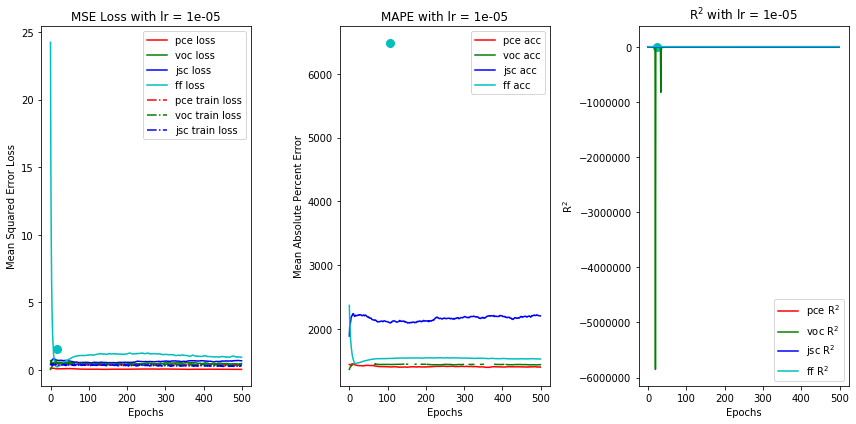

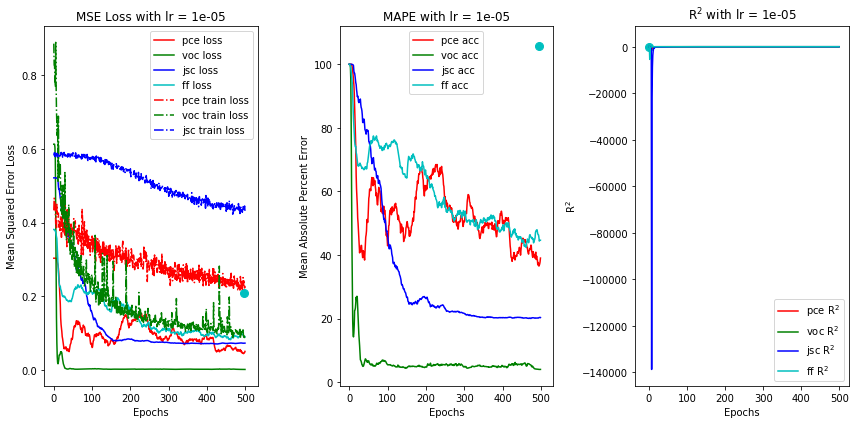

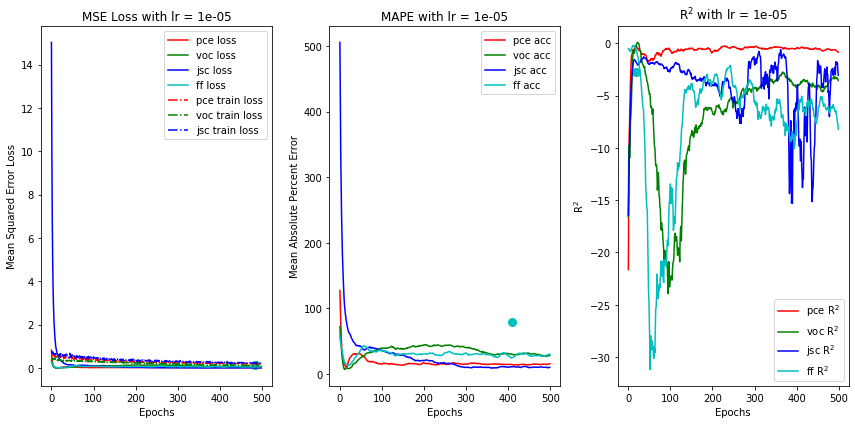

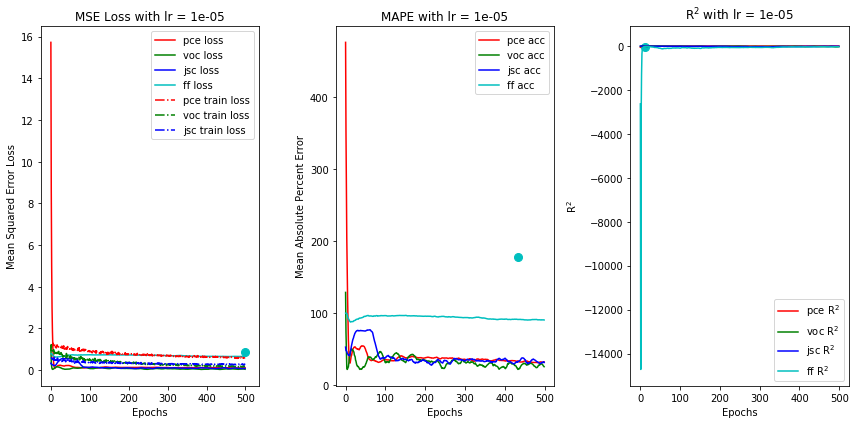

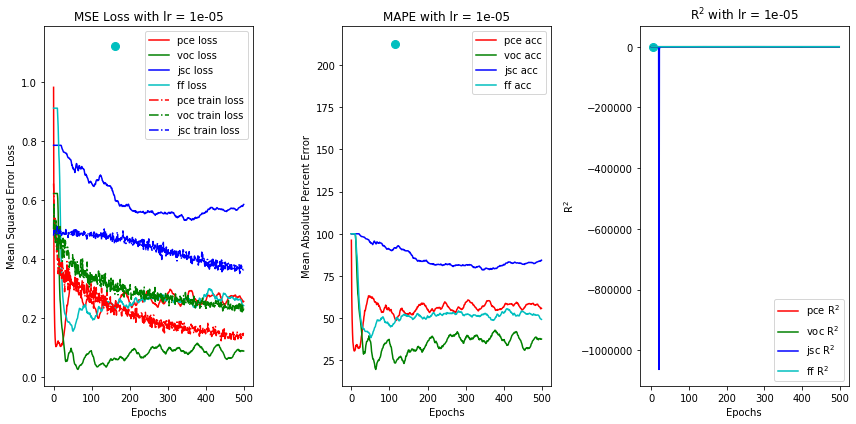

In [29]:
for key, fit_dict in data.items():
    plot_fit_results(fit_dict)